In [ ]:
!pip install catboost

In [ ]:
#!pip install shap

In [ ]:
!pip install category-encoders

ERROR: Operation cancelled by user


In [ ]:
#!pip install optuna

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import math

from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import itertools
import random
from tqdm import tqdm
import os
import scipy.stats as stats
#import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import category_encoders as ce

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GroupKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm

import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.optim.lr_scheduler import LambdaLR, CyclicLR, OneCycleLR
from torch.nn.functional import cosine_similarity
import torch.nn.functional as F

# import optuna
# from optuna.samplers import TPESampler

SEED = 41
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

warnings.filterwarnings(action = 'ignore')

In [ ]:
drive.mount('/content/drive')
hdatasetdir = '/content/drive/MyDrive/open(수정)/'
train = pd.read_csv(hdatasetdir + 'train.csv')
test = pd.read_csv(hdatasetdir + 'test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**선박의 식별자 관련 피처**
- ID: 선박식별 일련번호
- SHIPMANAGER: 선박 소유주
- FLAG: 선박의 국적

In [ ]:
train['ID_ALPH'] = train['ID'].str[:1]
#train['ID_NUMB'] = train['ID'].str[1:] # 뒷자리는 주민등록번호같은 정보이므로 학습에 불필요한 정보 이므로 나중에 제거?

test['ID_ALPH'] = test['ID'].str[:1]
#test['ID_NUMB'] = test['ID'].str[1:]

In [ ]:
print('train FLAG difference', set(train['FLAG'].unique()).difference(set(test['FLAG'].unique())))
print('test FLAG difference', set(test['FLAG'].unique()).difference(set(train['FLAG'].unique())))

print('train ID_ALPH difference', set(train['ID_ALPH'].unique()).difference(set(test['ID_ALPH'].unique())))
print('test ID_ALPH difference', set(test['ID_ALPH'].unique()).difference(set(train['ID_ALPH'].unique())))

# print('train ID_NUMB difference', set(train['ID_NUMB'].unique()).difference(set(test['ID_NUMB'].unique())))
# print('test ID_NUMB difference', set(test['ID_NUMB'].unique()).difference(set(train['ID_NUMB'].unique())))

train FLAG difference {'Guyana False', 'Moldova', 'Sao Tome & Principe False', 'Libya', 'Bulgaria', 'Equatorial Guinea', 'Azerbaijan', 'Comoros False'}
test FLAG difference {'Gambia'}
train ID_ALPH difference set()
test ID_ALPH difference set()


In [ ]:
train = train[~train['FLAG'].isin(['Guyana False', 'Moldova', 'Sao Tome & Principe False', 'Libya', 'Bulgaria', 'Equatorial Guinea', 'Azerbaijan', 'Comoros False'])]

In [ ]:
# temp = train.groupby(['YEAR'])['ID_ALPH'].unique().reset_index()
# temp['ID_ALPH_LEN'] = len(temp['ID_ALPH'])
# temp['ID_ALPH_LEN'] # 차량 번호 처럼 단순 식별 정보가 아니라, 패턴이 있는 의미 있는 정보라는 것을 확인

In [ ]:
train[train['FLAG'].str[-5:] == 'False'] # 학습에 도움이 안될것으로 판단 제거 (test 데이터를 볼 수 없다는 가정이라면 제거를 할 수 없음)

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,...,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR,ID_ALPH
35209,TRAIN_035209,RU,FAV3,Bulk,0.0,2017-03-15 11:59,A263585,20.0,25,26000,...,KVEM81,Equatorial Guinea False,NaN,NaN,NaN,NaN,13,0.000011,0.0,A
300962,TRAIN_300962,TW,EKP8,Cargo,0.0,2020-12-29 12:37,Y518484,10.0,35,1310,...,AGWE38,Togo False,-3.67,-8.22,18.7,4.876304,20,0.000427,0.0,Y


In [ ]:
# False: 국적 정보가 정확하지 않거나 부가 정보가 있는 경우 사용되는 마커일 수 있음
# 제거 혹은 False 마커 제거

train.loc[train['FLAG'].str.split(' ').str[1] == 'False', 'FLAG'] = train['FLAG'].str.split(' ').str[0]
test.loc[test['FLAG'].str.split(' ').str[1] == 'False', 'FLAG'] = test['FLAG'].str.split(' ').str[0]

In [ ]:
train.loc[1859, 'SHIPMANAGER'] = 'Jan-26'

In [ ]:
#train['SHIPMANAGER_IDEN'] = train['SHIPMANAGER'].str[:-2]
train['SHIPMANAGER_COMP'] = train['SHIPMANAGER'].str[-2:]

#test['SHIPMANAGER_IDEN'] = test['SHIPMANAGER'].str[:-2]
test['SHIPMANAGER_COMP'] = test['SHIPMANAGER'].str[-2:] # 선박의 회사의 고유성

In [ ]:
# print('train SHIPMANAGER_IDEN difference', set(train['SHIPMANAGER_IDEN'].unique()).difference(set(test['SHIPMANAGER_IDEN'].unique())))
# print('test SHIPMANAGER_IDEN difference', set(test['SHIPMANAGER_IDEN'].unique()).difference(set(train['SHIPMANAGER_IDEN'].unique())))

print('train SHIPMANAGER_COMP difference', set(train['SHIPMANAGER_COMP'].unique()).difference(set(test['SHIPMANAGER_COMP'].unique())))
print('test SHIPMANAGER_COMP difference', set(test['SHIPMANAGER_COMP'].unique()).difference(set(train['SHIPMANAGER_COMP'].unique())))

train SHIPMANAGER_COMP difference set()
test SHIPMANAGER_COMP difference set()


In [ ]:
# temp = train[train['SHIPMANAGER_COMP'] == 'an']
# find_key = ['BUILT', 'FLAG', 'SHIP_TYPE_CATEGORY', 'ID_ALPH', 'ID_NUMB']
# find_value = temp[find_key].values[0]
# find_condition = (train[find_key] == find_value).all(axis = 1)
# train.loc[find_condition, 'SHIPMANAGER_COMP'] # 조건 필터링을 통해 패턴에 따른 값을 채움 an -> 36

In [ ]:
# train.loc[train['SHIPMANAGER_COMP'] == 'an', 'SHIPMANAGER_COMP'] = '36'

**항구 관련 피처**
- APT_CO: 도착항의 소속국가(도착항 앞 2글자)
- ARI_PO: 도착항의 항구명(도착항 뒤 글자)
- DIST: 정박지와 접안지 사이의 거리 (km)
- PORT_SIZE: 접안지 폴리곤 영역의 크기 (km^2)

In [ ]:
train.loc[(train['ID'] == 'Z421423') & (train['DIST'] == 0)] # 특정 선박에서 빈번하게 발생, 고장일 가능성이 있음 CI_HOUR를 모두 0으로 처리

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,...,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR,ID_ALPH,SHIPMANAGER_COMP
6439,TRAIN_006439,RU,FCD5,Container,0.0,2021-10-01 10:21,Z421423,20.0,27,5220,...,Russia,-3.82,-7.08,16.3,4.524174,12,0.000399,0.748611,Z,67
66864,TRAIN_066864,RU,FCD5,Container,0.0,2021-10-01 14:09,Z421423,20.0,27,5220,...,Russia,0.93,-3.61,14.2,2.709169,16,0.000399,1.748889,Z,67
215246,TRAIN_215246,RU,FCD5,Container,0.0,2021-11-16 19:54,Z421423,20.0,27,5220,...,Russia,-0.37,-3.24,5.2,2.478001,21,0.000399,0.751389,Z,67
297812,TRAIN_297812,RU,FCD5,Container,0.0,2021-10-01 2:03,Z421423,20.0,27,5220,...,Russia,-3.82,-7.08,16.3,4.524174,4,0.000399,7.299167,Z,67
330801,TRAIN_330801,RU,FCD5,Container,0.0,2021-08-06 2:10,Z421423,20.0,27,5220,...,Russia,-2.17,1.51,23.2,2.154439,4,0.000399,0.000000,Z,67
350939,TRAIN_350939,RU,FCD5,Container,0.0,2021-11-16 22:54,Z421423,20.0,27,5220,...,Russia,0.10,4.39,7.4,3.021672,0,0.000399,8.248333,Z,67


In [ ]:
temp = train.loc[train['DIST'] == 0, 'CI_HOUR']
train.loc[temp.loc[temp != 0].index, 'ID'].value_counts() # 고장 일 가능성이 있음 CI_HOUR를 모두 0으로 처리

Z421423    5
C363524    2
I273647    1
O478876    1
Y714156    1
V572262    1
B244358    1
X455261    1
Z516167    1
B458578    1
B185346    1
B226876    1
U866847    1
G453373    1
R126247    1
W363516    1
N425156    1
L117585    1
J315117    1
V254463    1
J245783    1
M766643    1
R468154    1
Name: ID, dtype: int64

In [ ]:
#train.loc[train['DIST'] != 0, 'CI_HOUR']
train.loc[train['DIST'] == 0, 'CI_HOUR'].value_counts() # 거리가 0인데 대기시간이 0이 아닌경우 고장 일 수도 학습에 방해가 됨?, CI_HOUR 0으로 처리
# 데이터 오류, 센서 오류로 확인

0.000000      157256
0.050000           2
8.650278           1
755.989444         1
25.999167          1
8.248333           1
0.568611           1
7.299167           1
1.201667           1
0.099167           1
62.012778          1
0.751389           1
95.951667          1
11.499722          1
158.303333         1
280.732778         1
57.998889          1
5.050000           1
191.500278         1
21.300556          1
1.748889           1
388.824444         1
634.015278         1
10.000000          1
0.049167           1
0.551389           1
0.748611           1
143.203889         1
Name: CI_HOUR, dtype: int64

In [ ]:
# drop 0이 아닌
train.drop([train.loc[(train['DIST'] == 0) & (train['CI_HOUR'] != 0)].index], axis = 0, inplace = True)
#train.loc[(train['DIST'] == 0) & (train['CI_HOUR'] != 0), 'CI_HOUR'] = 0

In [ ]:
train[train['DIST'] != 0].shape, train[train['DIST'] == 0].shape # Stratified KFold 활용

((234631, 25), (157284, 25))

In [ ]:
train['Wating'] = np.nan
train.loc[train['DIST'] != 0, 'Wating'] = 1
train.loc[train['DIST'] == 0, 'Wating'] = 0

test['Wating'] = np.nan
test.loc[test['DIST'] != 0, 'Wating'] = 1
test.loc[test['DIST'] == 0, 'Wating'] = 0

In [ ]:
train.loc[train['ARI_PO'] == 'EKP8'] # 도착항의 소속국가 CN과 TW은 같은 도착항의 항구명을 가짐

# ARI_CO와 ARI_PO를 결합
train['ARI_CO_PO'] = train['ARI_CO'] + '-' + train['ARI_PO']
test['ARI_CO_PO'] = test['ARI_CO'] + '-' + test['ARI_PO']

# ARI_CO, ARI_PO 정보는 나중에 제거

In [ ]:
print('train ARI_CO difference', set(train['ARI_CO'].unique()).difference(set(test['ARI_CO'].unique())))
print('test ARI_CO difference', set(test['ARI_CO'].unique()).difference(set(train['ARI_CO'].unique())))

print('train ARI_PO difference', set(train['ARI_PO'].unique()).difference(set(test['ARI_PO'].unique())))
print('test ARI_PO difference', set(test['ARI_PO'].unique()).difference(set(train['ARI_PO'].unique())))

print('train ARI_CO_PO difference', set(train['ARI_CO_PO'].unique()).difference(set(test['ARI_CO_PO'].unique())))
print('test ARI_CO_PO difference', set(test['ARI_CO_PO'].unique()).difference(set(train['ARI_CO_PO'].unique())))

train ARI_CO difference set()
test ARI_CO difference set()
train ARI_PO difference set()
test ARI_PO difference set()
train ARI_CO_PO difference set()
test ARI_CO_PO difference set()


**시간 관련 피처**
- ATA: 정박지에 도착한 시점의 utc. 실제 정박 시각(Actual Time of Arrival, ATA) (hour)
- ATA_LT: 정박지에 도착한 시점의 현지 정박 시각(Local Time of Arrival, LTA)(단위:H) (hour)

In [ ]:
# UTC 시간차 구하기

def Calculate_Time_Related(df: pd.DataFrame) -> pd.DataFrame:
  df['ATA'] = pd.to_datetime(df['ATA'])

  # 시간 관련 변수 생성
  df['YEAR'] = df['ATA'].dt.year
  df['MONTH'] = df['ATA'].dt.month
  df['DAY'] = df['ATA'].dt.day
  df['DAY_OF_WEEK'] = df['ATA'].dt.dayofweek
  #df['WEEK'] = df['ATA'].dt.isocalendar().week.astype(np.int32)
  #df['HOLIDAY'] = (df['ATA'].dt.weekday >= 5).astype(int)
  df['HOUR'] = df['ATA'].dt.hour
  #df['MINUTE'] = df['ATA'].dt.minute
  #df['Sin_hour'] = np.sin(2 * np.pi * (df['HOUR'])/24.0)
  #df['Cos_hour'] = np.cos(2 * np.pi * (df['HOUR'])/24.0)

  # utc
  year = df['YEAR'].astype(str)
  month = df['MONTH'].astype(str)
  day = df['DAY'].astype(str)
  lta = df['ATA_LT'].values.astype(str)
  # minutes = df['MINUTE'].astype(str)
  minutes = '0'
  seconds = df['ATA'].dt.second.astype(str)

  lta_date = year + '-' + month + '-' + day + ' ' + lta + ':' + minutes + ':' + seconds

  df['LTA'] = pd.to_datetime(lta_date, format='%Y-%m-%d %H:%M:%S', errors='coerce')

  df['TIME_DIFF'] = df['LTA'] - df['ATA']
  df['TIME_DIFF'] = df['TIME_DIFF'].astype(str)
  df['TIME_DIFF'] = df['TIME_DIFF'].str.split(' ').str[2].str[:3]
  df['TIME_DIFF'] = df['TIME_DIFF'].apply(lambda text: re.sub(r'[+:]', '', text))
  df['TIME_DIFF'] = df['TIME_DIFF'].astype(int)

  # update
  df['TIME_DIFF'] = df.apply(lambda row: row['ATA'] - row['LTA'] if row['TIME_DIFF'] > 12 else row['LTA'] - row['ATA'], axis = 1)
  df['TIME_DIFF'] = df['TIME_DIFF'].astype(str)
  df['TIME_DIFF'] = df['TIME_DIFF'].str.split(' ').str[2].str[:3]
  df['TIME_DIFF'] = df['TIME_DIFF'].apply(lambda text: re.sub(r'[+:]', '', text))
  df['TIME_DIFF'] = df['TIME_DIFF'].astype(int)

  # country sign
  country_sign = {}
  ARI_CO = df['ARI_CO'].unique()
  ARI_sign = [True, True, True, True, True, True, True, True, False, True, False, True, True, True, False, True, True, False, True, False, True, True, False, False, True]
  for country, sign in zip(ARI_CO, ARI_sign):
      country_sign[country] = sign

      if sign:
        df.loc[df['ARI_CO'] == country, 'TIME_DIFF'] = df.loc[df['ARI_CO'] == country, 'TIME_DIFF']

      else:
        df.loc[df['ARI_CO'] == country, 'TIME_DIFF'] = -df.loc[df['ARI_CO'] == country, 'TIME_DIFF']

  df.drop(['LTA'], axis = 1, inplace = True)

  return df

train = Calculate_Time_Related(train)
test = Calculate_Time_Related(test)

In [ ]:
train['TIME_DIFF_ABS'] = np.abs(train['TIME_DIFF'])
test['TIME_DIFF_ABS'] = np.abs(test['TIME_DIFF'])

In [ ]:
set(train['TIME_DIFF'].unique()).difference(set(test['TIME_DIFF'].unique()))

set()

In [ ]:
# del train['TIME_DIFF']
# del test['TIME_DIFF']

In [ ]:
# # 현지 정박 시각
# train['LTA'] = train['ATA'] + pd.to_timedelta(train['TIME_DIFF'], unit = 'h')
# train['YEAR_LT'] = train['LTA'].dt.year
# train['MONTH_LT'] = train['LTA'].dt.month
# train['DAY_LT'] = train['LTA'].dt.day
# train['DAY_OF_WEEK_LT'] = train['LTA'].dt.dayofweek
# train['WEEK_LT'] = train['LTA'].dt.isocalendar().week.astype(np.int32)
# train['HOLIDAY_LT'] = (train['LTA'].dt.weekday >= 5).astype(int)
# train['HOUR_LT'] = train['LTA'].dt.hour
# train['MINUTE_LT'] = train['LTA'].dt.minute
# train['Sin_hour_LT'] = np.sin(2 * np.pi * (train['HOUR_LT'])/24.0)
# train['Cos_hour_LT'] = np.cos(2 * np.pi * (train['HOUR_LT'])/24.0)

# # 현지 정박 시각
# test['LTA'] = test['ATA'] + pd.to_timedelta(test['TIME_DIFF'], unit = 'h')
# test['YEAR_LT'] = test['LTA'].dt.year
# test['MONTH_LT'] = test['LTA'].dt.month
# test['DAY_LT'] = test['LTA'].dt.day
# test['DAY_OF_WEEK_LT'] = test['LTA'].dt.dayofweek
# test['WEEK_LT'] = test['LTA'].dt.isocalendar().week.astype(np.int32)
# test['HOLIDAY_LT'] = (test['LTA'].dt.weekday >= 5).astype(int)
# test['HOUR_LT'] = test['LTA'].dt.hour
# test['MINUTE_LT'] = test['LTA'].dt.minute
# test['Sin_hour_LT'] = np.sin(2 * np.pi * (test['HOUR_LT'])/24.0)
# test['Cos_hour_LT'] = np.cos(2 * np.pi * (test['HOUR_LT'])/24.0)

In [ ]:
del train['ARI_PO']
del test['ARI_PO']

In [ ]:
# 시간대 변수 생성
def Calculate_Timezone(hour):
  if 4 <= hour < 7:
    timezone = 0 #'새벽'
  elif 7 <= hour < 11:
    timezone = 1 #'아침'
  elif 11 <= hour < 14:
    timezone = 2 #'점심'
  elif 14 <= hour < 18:
    timezone = 3 #'오후'
  elif 18 <= hour < 22:
    timezone = 4 #'저녁'
  else:
    timezone = 5 #'야간'

  return timezone

train['TIMEZONE1'] = train['HOUR'].apply(Calculate_Timezone)
test['TIMEZONE1'] = test['HOUR'].apply(Calculate_Timezone)

def Calculate_Timezone(hour):
    if 6 <= hour < 12:
        return 0 # '오전'
    elif 12 <= hour < 18:
        return 1 #'오후'
    else:
        return 3 #'밤'

# train['TIMEZONE2'] = train['HOUR'].map(Calculate_Timezone)
# test['TIMEZONE2'] = test['HOUR'].map(Calculate_Timezone)

In [ ]:
# 계절 변수 생성
def Calculate_Season(month):
  if 3 <= month <= 5:
    season = 0 #'봄'
  elif 6 <= month <= 8:
    season = 1 #'여름'
  elif 9 <= month <= 11:
    season = 2 #'가을'
  else:
    season = 3 #'겨울'

  return season

train['SEASON'] = train['MONTH'].apply(Calculate_Season)
test['SEASON'] = test['MONTH'].apply(Calculate_Season)

In [ ]:
# # 도착 패턴을 분석할 수 있음
# # 어떤 계절, 시간대, UTC 시간차가 클 경우에는 대기 시간이 길어지고 그런것들을 분석 할 수 있음

# columns = ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'WEEK', 'HOLIDAY', 'HOUR', 'ATA', 'MINUTE', 'TIME_DIFF', 'TIMEZONE1', 'SEASON']
# plt.figure(figsize = (20, len(columns)))
# for i, col in enumerate(columns):
#   plt.subplot(len(columns), 1, i+1)
#   train.groupby([col])['CI_HOUR'].mean().plot()
#   plt.title(f'CI_HOUR by {col}')
#   plt.tight_layout()
#   plt.show()

**선박 특성 관련 피처**
- SHIP_TYPE_CATEGORY: 선종 통합 바탕으로 5대 선종으로 분류
- BREADTH
: 선박의 폭 (m)
- BUILT: 선박의 연령 (year)
- DEADWEIGHT: 선박의 재화중량톤수 (ton): 선박이 운반할 수 있는 중량을 측정
- DEPTH: 선박의 깊이 (m)
- DRAUGHT: 홀수(선박이 물 위에 떠 있을 때 선체가 가라앉는 깊이) 높이 (m)
- GT: 용적톤수(Gross Tonnage)값 (GT(m^3)): 선각으로 둘러싸인 선체 용적톤에서 상갑판 상부에 있는 추진, 항해, 안전, 위생에 관계되는 구역을 차감한 전 용량의 톤수
- LENGTH: 선박의 길이 (m)

In [ ]:
# TRAIN_356484에서 이유 모를 결측치가 발견됨
for col in ['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH']:
  print(train[train[col].isna() == True].index)

Int64Index([356484], dtype='int64')
Int64Index([356484], dtype='int64')
Int64Index([356484], dtype='int64')
Int64Index([356484], dtype='int64')


In [ ]:
train.loc[356484]

SAMPLE_ID                    TRAIN_356484
ARI_CO                                 TW
SHIP_TYPE_CATEGORY                  Cargo
DIST                                  0.0
ATA                   2022-11-08 04:10:00
ID                                A457875
BREADTH                               NaN
BUILT                                  28
DEADWEIGHT                           1500
DEPTH                                 NaN
DRAUGHT                               NaN
GT                                    500
LENGTH                                NaN
SHIPMANAGER                        GVPJ58
FLAG                                Japan
U_WIND                              -0.34
V_WIND                              -1.91
AIR_TEMPERATURE                      25.3
BN                               1.752807
ATA_LT                                 12
PORT_SIZE                         0.00099
CI_HOUR                               0.0
ID_ALPH                                 A
SHIPMANAGER_COMP                  

In [ ]:
# 결측치 행을 과감히 삭제
# train.drop([356484], axis = 0, inplace = True)

# 관련성이 있어 보이는 선박의 정보를 찾아 평균값으로 대체
train.loc[356484, 'BREADTH'] = train.loc[(train['SHIP_TYPE_CATEGORY'] == 'Cargo') & (train['BUILT'] == 28) & (train['DEADWEIGHT'] == 1500) & (train['GT'] == 500), 'BREADTH'].mean()
train.loc[356484, 'DEPTH'] = train.loc[(train['SHIP_TYPE_CATEGORY'] == 'Cargo') & (train['BUILT'] == 28) & (train['DEADWEIGHT'] == 1500) & (train['GT'] == 500), 'DEPTH'].mean()
train.loc[356484, 'DRAUGHT'] = train.loc[(train['SHIP_TYPE_CATEGORY'] == 'Cargo') & (train['BUILT'] == 28) & (train['DEADWEIGHT'] == 1500) & (train['GT'] == 500), 'DRAUGHT'].mean()
train.loc[356484, 'LENGTH'] = train.loc[(train['SHIP_TYPE_CATEGORY'] == 'Cargo') & (train['BUILT'] == 28) & (train['DEADWEIGHT'] == 1500) & (train['GT'] == 500), 'LENGTH'].mean()

In [ ]:
# # 선박의 규모 및 형태를 유추할 수 있음

# # 선박의 크기
# train['SIZE'] = train['LENGTH'] * train['BREADTH']
# test['SIZE'] = test['LENGTH'] * test['BREADTH']

# # # 선박의 총 부피
# # train['VOLUME'] = train['SIZE'] * train['DEPTH']
# # test['VOLUME'] = test['SIZE'] * test['DEPTH']

# # 외판의 면적
# train['TOPSIDE'] = 2 * (train['DEPTH'] - train['DRAUGHT']) * (train['LENGTH'] + 0.5 * train['BREADTH'])
# test['TOPSIDE'] = 2 * (test['DEPTH'] - test['DRAUGHT']) * (test['LENGTH'] + 0.5 * test['BREADTH'])

In [ ]:
# # 선박의 옆면 단면적
# train['SIDE_SINGLE_AREA'] = train['LENGTH']/1000 * train['DEPTH']/1000
# test['SIDE_SINGLE_AREA'] = test['LENGTH']/1000 * test['DEPTH']/1000

# # 선박의 앞면 단면적
# train['FRONT_SINGLE_AREA'] = train['BREADTH']/1000 * train['DEPTH']/1000
# test['FRONT_SINGLE_AREA'] = test['BREADTH']/1000 * test['DEPTH']/1000

In [ ]:
train['BUILT'].value_counts()

11    33878
12    27811
13    27213
10    25617
15    22952
      ...  
80        2
59        1
55        1
57        1
70        1
Name: BUILT, Length: 64, dtype: int64

In [ ]:
# # 나이의 역수
# train['BUILT_BACK'] = 1/train['BUILT']
# test['BUILT_BACK'] = 1/test['BUILT']

# train['BUILT_BACK'] = train['BUILT_BACK'].replace([np.inf, -np.inf], 1)
# test['BUILT_BACK'] = test['BUILT_BACK'].replace([np.inf, -np.inf], 1)

In [ ]:
train.loc[train['DIST'] == 0, 'PORT_SIZE'].min(), train.loc[train['DIST'] != 0, 'PORT_SIZE'].min()

(4.5e-06, 4.5e-06)

In [ ]:
train.loc[train['DIST'] == 0, 'PORT_SIZE'].mean(), train.loc[train['DIST'] != 0, 'PORT_SIZE'].mean()

(0.0008322305652641082, 0.0009060328932707101)

In [ ]:
train.loc[train['DIST'] == 0, 'PORT_SIZE'].min(), train.loc[train['DIST'] == 0, 'PORT_SIZE'].mean(), train.loc[train['DIST'] == 0, 'PORT_SIZE'].max(), train.loc[train['DIST'] != 0, 'PORT_SIZE'].min(), train.loc[train['DIST'] != 0, 'PORT_SIZE'].mean(), train.loc[train['DIST'] != 0, 'PORT_SIZE'].max()

(4.5e-06,
 0.0008322305652641082,
 0.002615416,
 4.5e-06,
 0.0009060328932707101,
 0.002615416)

In [ ]:
# # 거리가 0이라는 것은 선박이 접안되어있다는 정보인데, 폴리곤 영역에 접안되어있는 선박의 면적이 추가가 안되어있음 접안되어있는 선박의 면적까지 추가 시켜줌
train.loc[train['DIST'] == 0, 'PORT_SIZE'] = train.loc[train['DIST'] == 0, 'PORT_SIZE'] + (train.loc[train['DIST'] == 0, 'LENGTH'] / 1000) * train.loc[train['DIST'] == 0, 'BREADTH'] / 1000
test.loc[test['DIST'] == 0, 'PORT_SIZE'] = test.loc[test['DIST'] == 0, 'PORT_SIZE'] + (test.loc[test['DIST'] == 0, 'LENGTH'] / 1000) * test.loc[test['DIST'] == 0, 'BREADTH'] / 1000

In [ ]:
train.loc[train['DIST'] == 0, 'PORT_SIZE'].min(), train.loc[train['DIST'] == 0, 'PORT_SIZE'].mean(), train.loc[train['DIST'] == 0, 'PORT_SIZE'].max(), train.loc[train['DIST'] != 0, 'PORT_SIZE'].min(), train.loc[train['DIST'] != 0, 'PORT_SIZE'].mean(), train.loc[train['DIST'] != 0, 'PORT_SIZE'].max()

(0.0004305,
 0.007923422930666817,
 0.026615416,
 4.5e-06,
 0.0009060328932707101,
 0.002615416)

상관관계 관련 피쳐

In [ ]:
# # # 부피 대 용적 톤수 비율: 선박이 얼마나 가득 차있는지의 정도
# # train['VOLUME_FOR_BUILT'] = train['VOLUME'] / train['GT']
# # test['VOLUME_FOR_BUILT'] = test['VOLUME'] / test['GT']

# # 용적 톤수 대 재화 중량 톤수 비율: 화물의 밀도에 대한 정보
# train['GT_FOR_DEADWEIGHT'] = train['GT'] / train['DEADWEIGHT']
# test['GT_FOR_DEADWEIGHT'] = test['GT'] / test['DEADWEIGHT']

# # # 부피 대 재화 중량 톤수 비율: 화물의 부피 대비 무게
# # train['VOLUME_FOR_DEADWEIGHT'] = train['VOLUME'] / train['DEADWEIGHT']
# # test['VOLUME_FOR_DEADWEIGHT'] = test['VOLUME'] / test['DEADWEIGHT']

# # # 재화 중량 톤수 대 선박 연령 비율: 선박의 나이와 운반 능력 간의 관계
# # train['DEADWEIGHT_FOR_BUILT'] = train['DEADWEIGHT'] / train['BUILT']
# # test['DEADWEIGHT_FOR_BUILT'] = test['DEADWEIGHT'] / test['BUILT']

# # del train['VOLUME_FOR_BUILT']
# # del train['VOLUME_FOR_DEADWEIGHT']

# # del test['VOLUME_FOR_BUILT']
# # del test['VOLUME_FOR_DEADWEIGHT']

In [ ]:
# def Calculate_AggFunc(data: pd.DataFrame, columns: str, groupcolumns: list, aggfunc: list)->pd.DataFrame:
#   agg_data = data[[columns]+groupcolumns].groupby(columns).agg(aggfunc)
#   agg_data.columns = [key + '_' + i[0] + '_' + i[1] for i in agg_data.columns]
#   return agg_data

# def range_func(x):
#     max_val = np.max(x)
#     min_val = np.min(x)
#     range_val = max_val - min_val
#     return range_val

# agg_dict = {
#     'TIME_DIFF': [['DIST'], ['mean', range_func]],
#     'TIME_DIFF_ABS': [['DIST'], ['mean', range_func]],
#     'ARI_CO_PO': [['DIST'], ['mean', range_func]],
#     'SHIP_TYPE_CATEGORY': [['DIST'], ['mean', range_func]],
#     'SHIP_TYPE_CATEGORY': [['BUILT', 'LENGTH'], ['min', 'max', 'mean']], # 5대 선종별 통계량
#     'SHIP_TYPE_CATEGORY': [['BREADTH', 'DEPTH'], ['max', 'mean']], # 5대 선종별 폭, 깊이 통계량
#     'BUILT': [['DEADWEIGHT', 'GT'], ['min', 'max', 'mean']], # 선박의 연령에 따른 화물량 통계량,
#     'SHIP_TYPE_CATEGORY': [['DEADWEIGHT', 'GT'], ['min', 'max', 'mean']], # 5대 선종별 화물량 통계량
#     'SHIP_TYPE_CATEGORY': [['FLAG', 'SHIPMANAGER_COMP', 'ARI_CO_PO'], ['count']],
# }

# for key, value in agg_dict.items():
#   agg_data = Calculate_AggFunc(train, key, value[0], value[1]).reset_index()
#   agg_data_t = Calculate_AggFunc(test, key, value[0], value[1]).reset_index()
#   train = pd.merge(train, agg_data, how = 'left', left_on = key, right_on = key)
#   test = pd.merge(test, agg_data_t, how = 'left', left_on = key, right_on = key)

결측치 확인 및 처리

In [ ]:
train.isnull().sum()[train.isnull().sum() > 0]

U_WIND             163679
V_WIND             163679
AIR_TEMPERATURE    164621
BN                 163679
dtype: int64

In [ ]:
test.isnull().sum()[test.isnull().sum() > 0]

U_WIND             91725
V_WIND             91725
AIR_TEMPERATURE    92246
BN                 91725
dtype: int64

In [ ]:
# 결측치 비율
print(train['U_WIND'].isnull().sum() / train['U_WIND'].shape[0] * 100)
print(train['V_WIND'].isnull().sum() / train['V_WIND'].shape[0] * 100)
print(train['AIR_TEMPERATURE'].isnull().sum() / train['AIR_TEMPERATURE'].shape[0] * 100)
print(train['BN'].isnull().sum() / train['BN'].shape[0] * 100)

41.76390288710562
41.76390288710562
42.00426112805072
41.76390288710562


In [ ]:
train.columns

Index(['SAMPLE_ID', 'ARI_CO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ATA', 'ID',
       'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'PORT_SIZE', 'CI_HOUR', 'ID_ALPH', 'SHIPMANAGER_COMP',
       'Wating', 'ARI_CO_PO', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'HOUR',
       'TIME_DIFF', 'TIME_DIFF_ABS', 'TIMEZONE1', 'SEASON'],
      dtype='object')

In [ ]:
# plt.figure(figsize = (30, 30))
# for idx, col in enumerate(train.columns[1:]):
#   plt.subplot(len(train.columns), 1, idx + 1)
#   train.groupby([col])['CI_HOUR'].mean().plot()
#   plt.title(f'{col}')

# plt.show()

In [ ]:
train = train.reset_index().drop(['index'], axis = 1)

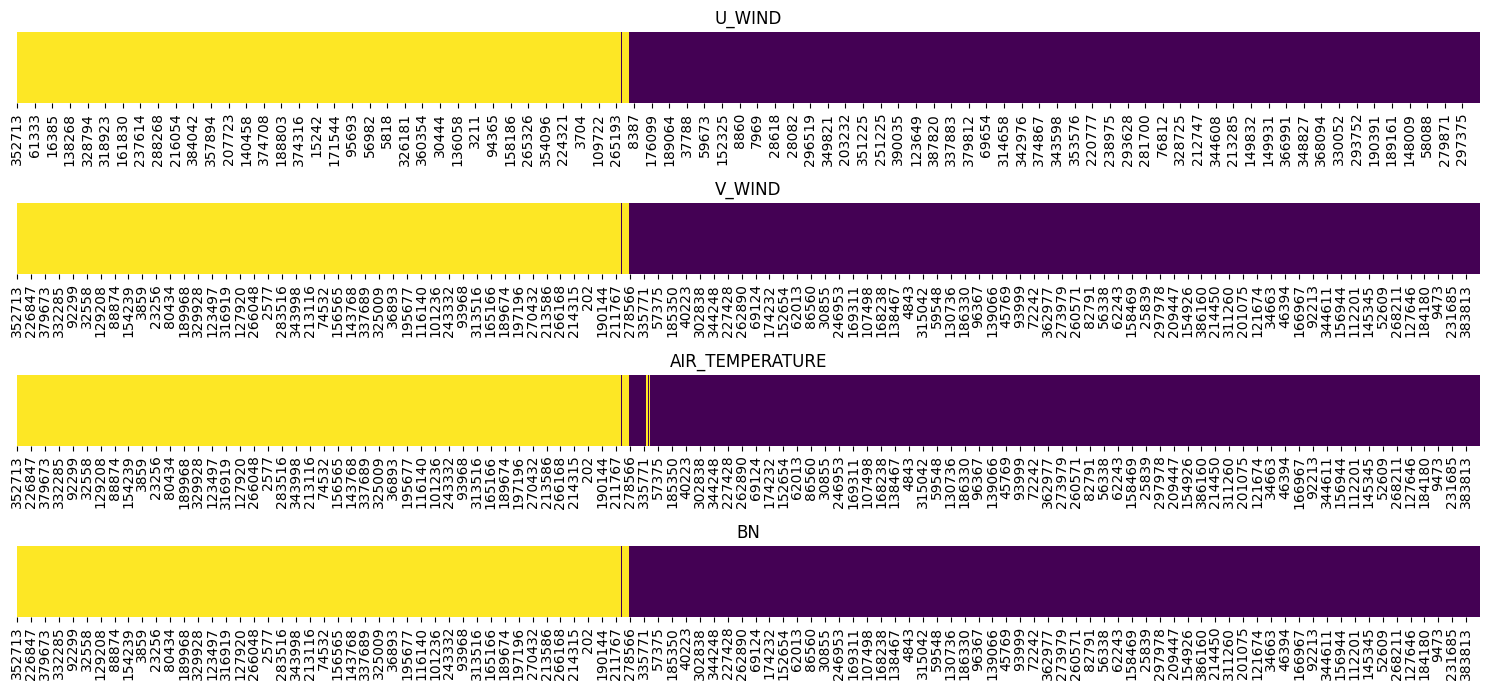

In [ ]:
# 결측치 패턴
plt.figure(figsize = (15, 7))
for idx, column in enumerate(['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']):
  plt.subplot(4, 1, idx+1)
  temp = train[[column]].isnull().any(axis = 1).reset_index()
  temp['ATA'] = train['ATA']
  temp = temp.sort_values(by = 'ATA', ascending = True)
  sns.heatmap(temp[[0]].transpose(), cmap = 'viridis',cbar = False, yticklabels=False)
  plt.title(f'{column}')
  plt.tight_layout()
plt.show()

# 시간적 패턴을 고려해서 결측치를 어떻게 처리할건지가 관건

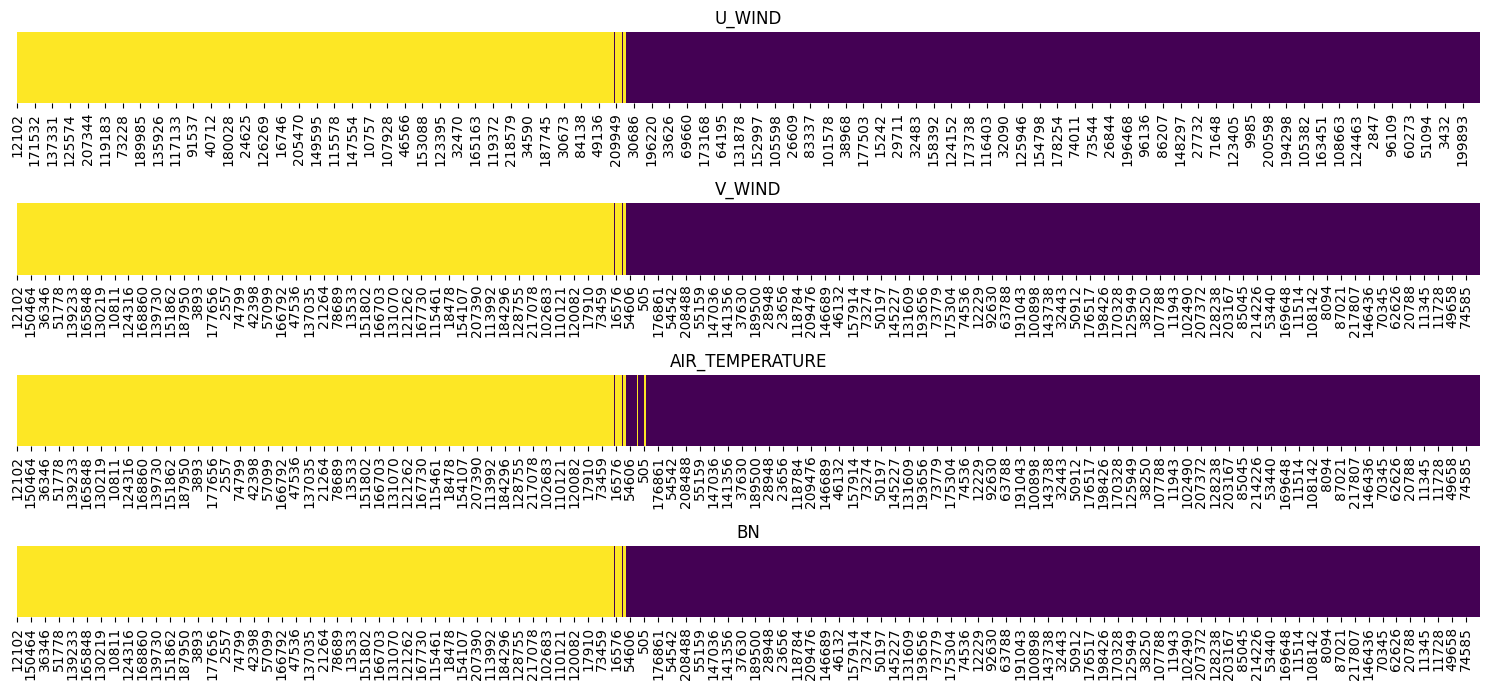

In [ ]:
# 결측치 패턴
plt.figure(figsize = (15, 7))
for idx, column in enumerate(['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']):
  plt.subplot(4, 1, idx+1)
  temp = test[[column]].isnull().any(axis = 1).reset_index()
  temp['ATA'] = test['ATA']
  temp = temp.sort_values(by = 'ATA', ascending = True)
  sns.heatmap(temp[[0]].transpose(), cmap = 'viridis',cbar = False, yticklabels=False)
  plt.title(f'{column}')
  plt.tight_layout()
plt.show()

# 시간적 패턴을 고려해서 결측치를 어떻게 처리할건지가 관건

In [ ]:
 # 결측치가 존재하는 기간 / 결측치가 존재하지 않은 기간 (일부 결측치가 포함)
print('U_WIND, V_WIND, BN')
print(train.loc[train[['U_WIND', 'V_WIND', 'BN']].isna().any(axis = 1), 'ATA'].min(), train.loc[train[['U_WIND', 'V_WIND', 'BN']].isna().any(axis = 1), 'ATA'].max(), '/', train.loc[train[['U_WIND', 'V_WIND', 'BN']].notna().any(axis = 1), 'ATA'].min(), train.loc[train[['U_WIND', 'V_WIND', 'BN']].notna().any(axis = 1), 'ATA'].max())
print(test.loc[test[['U_WIND', 'V_WIND', 'BN']].isna().any(axis = 1), 'ATA'].min(), test.loc[test[['U_WIND', 'V_WIND', 'BN']].isna().any(axis = 1), 'ATA'].max(), '/', test.loc[test[['U_WIND', 'V_WIND', 'BN']].notna().any(axis = 1), 'ATA'].min(), test.loc[test[['U_WIND', 'V_WIND', 'BN']].notna().any(axis = 1), 'ATA'].max())

  # 결측치가 존재하는 기간 / 결측치가 존재하지 않은 기간 (일부 결측치가 포함)
print('AIR_TEMPERATURE')
print(train.loc[train[['AIR_TEMPERATURE']].isna().any(axis = 1), 'ATA'].min(), train.loc[train[['AIR_TEMPERATURE']].isna().any(axis = 1), 'ATA'].max(), '/', train.loc[train[['AIR_TEMPERATURE']].notna().any(axis = 1), 'ATA'].min(), train.loc[train[['AIR_TEMPERATURE']].notna().any(axis = 1), 'ATA'].max())
print(test.loc[test[['AIR_TEMPERATURE']].isna().any(axis = 1), 'ATA'].min(), test.loc[test[['AIR_TEMPERATURE']].isna().any(axis = 1), 'ATA'].max(), '/', test.loc[test[['AIR_TEMPERATURE']].notna().any(axis = 1), 'ATA'].min(), test.loc[test[['AIR_TEMPERATURE']].notna().any(axis = 1), 'ATA'].max())

U_WIND, V_WIND, BN
2014-09-01 00:05:00 2019-01-16 23:39:00 / 2018-11-11 08:59:00 2023-02-28 14:55:00
2014-09-01 00:07:00 2019-01-16 23:57:00 / 2018-11-20 15:00:00 2023-02-28 14:52:00
AIR_TEMPERATURE
2014-09-01 00:05:00 2019-03-08 23:53:00 / 2018-11-11 08:59:00 2023-02-28 14:55:00
2014-09-01 00:07:00 2019-03-08 23:56:00 / 2018-11-20 15:00:00 2023-02-28 14:52:00


In [ ]:
# # 결측치가 존재하는 기간에서 일부 결측치를 전체 평균값으로 처리
# train.loc[(train.ATA > '2014-09-01') & (train.ATA < '2019-01-01'), 'U_WIND'] = np.nan
# train.loc[(train.ATA > '2014-09-01') & (train.ATA < '2019-01-01'), 'V_WIND'] = np.nan
# train.loc[(train.ATA > '2014-09-01') & (train.ATA < '2019-01-01'), 'BN'] = np.nan
# train.loc[(train.ATA > '2014-09-01') & (train.ATA < '2019-01-01'), 'AIR_TEMPERATURE'] = np.nan

# test.loc[(test.ATA > '2014-09-01') & (test.ATA < '2019-01-01'), 'U_WIND'] = np.nan
# test.loc[(test.ATA > '2014-09-01') & (test.ATA < '2019-01-01'), 'V_WIND'] = np.nan
# test.loc[(test.ATA > '2014-09-01') & (test.ATA < '2019-01-01'), 'BN'] = np.nan
# test.loc[(test.ATA > '2014-09-01') & (test.ATA < '2019-01-01'), 'AIR_TEMPERATURE'] = np.nan

# def fill_missing_process(row, notna_groupby_mean, step, col):
#     if step == 1:
#       matching_row = notna_groupby_mean[
#         (notna_groupby_mean['ARI_CO_PO'] == row['ARI_CO_PO']) &
#         (notna_groupby_mean['YEAR'] == row['YEAR']) &
#         (notna_groupby_mean['MONTH'] == row['MONTH']) &
#         (notna_groupby_mean['DAY'] == row['DAY']) &
#         (notna_groupby_mean['HOUR'] == row['HOUR'])
#       ]
#     elif step == 2:
#       matching_row = notna_groupby_mean[
#         (notna_groupby_mean['ARI_CO_PO'] == row['ARI_CO_PO']) &
#         (notna_groupby_mean['MONTH'] == row['MONTH']) &
#         (notna_groupby_mean['DAY'] == row['DAY']) &
#         (notna_groupby_mean['HOUR'] == row['HOUR'])
#       ]
#     elif step == 3:
#       matching_row = notna_groupby_mean[
#         (notna_groupby_mean['ARI_CO_PO'] == row['ARI_CO']) &
#         (notna_groupby_mean['MONTH'] == row['MONTH']) &
#         (notna_groupby_mean['HOUR'] == row['HOUR'])
#       ]
#     elif step == 4:
#       matching_row = notna_groupby_mean[
#         (notna_groupby_mean['ARI_CO_PO'] == row['ARI_CO_PO']) &
#         (notna_groupby_mean['YEAR'] == row['YEAR']) &
#         (notna_groupby_mean['MONTH'] == row['MONTH']) &
#         (notna_groupby_mean['DAY'] == row['DAY'])
#       ]
#     elif step == 5:
#       matching_row = notna_groupby_mean[
#         (notna_groupby_mean['ARI_CO_PO'] == row['ARI_CO_PO']) &
#         (notna_groupby_mean['YEAR'] == row['YEAR']) &
#         (notna_groupby_mean['MONTH'] == row['MONTH'])
#       ]
#     elif step == 6:
#       matching_row = notna_groupby_mean[
#         (notna_groupby_mean['ARI_CO_PO'] == row['ARI_CO_PO'])
#       ]

#     if not matching_row.empty:
#         return matching_row[col].values[0]
#     else:
#         return row[col]

# for col in ['U_WIND', 'V_WIND', 'BN', 'AIR_TEMPERATURE']:
#   print(col)

#   # if col in ['U_WIND', 'V_WIND', 'BN']:
#   #   train[col] = train[col].fillna(0)
#   #   test[col] = test[col].fillna(0)

#   #   print('fillna 0')
#   #   continue

#   # else:

#   condition = train[col][(train.ATA >= '2019-01-01') & (train.ATA < '2019-04-01') & train[col].notna()].index
#   notna_groupby_mean = train.loc[condition].groupby(['ARI_CO_PO', 'YEAR', 'MONTH', 'DAY', 'HOUR'])[col].median().reset_index() # mean

#   isna_condition = train.loc[(train.ATA >= '2019-01-01') & train[col].isna()].index
#   isna_condition_t = test.loc[(test.ATA >= '2019-01-01') & test[col].isna()].index

#   for i in range(1, 7):
#     train.loc[isna_condition, col] = train.loc[isna_condition].apply(lambda row: fill_missing_process(row, notna_groupby_mean, i, col), axis=1)
#     test.loc[isna_condition_t, col] = test.loc[isna_condition_t].apply(lambda row: fill_missing_process(row, notna_groupby_mean, i, col), axis=1)

#     isna_condition = train.loc[(train.ATA >= '2019-01-01') & train[col].isna()].index
#     isna_condition_t = test.loc[(test.ATA >= '2019-01-01') & test[col].isna()].index

#     print(f'프로세스 {i} 수행 후: {len(isna_condition)}, {len(isna_condition_t)}')

train.loc[(train.ATA >= '2019-01-01'), 'U_WIND'] = train.loc[(train.ATA >= '2019-01-01'), 'U_WIND'].fillna(train['U_WIND'].mean())
test.loc[(test.ATA >= '2019-01-01'), 'U_WIND'] = test.loc[(test.ATA >= '2019-01-01'), 'U_WIND'].fillna(train['U_WIND'].mean())

train.loc[(train.ATA >= '2019-01-01'), 'V_WIND'] = train.loc[(train.ATA >= '2019-01-01'), 'V_WIND'].fillna(train['V_WIND'].mean())
test.loc[(test.ATA >= '2019-01-01'), 'V_WIND'] = test.loc[(test.ATA >= '2019-01-01'), 'V_WIND'].fillna(train['V_WIND'].mean())

train.loc[(train.ATA >= '2019-01-01'), 'BN'] = train.loc[(train.ATA >= '2019-01-01'), 'BN'].fillna(train['BN'].mean())
test.loc[(test.ATA >= '2019-01-01'), 'BN'] = test.loc[(test.ATA >= '2019-01-01'), 'BN'].fillna(train['BN'].mean())

train.loc[(train.ATA >= '2019-01-01'), 'AIR_TEMPERATURE'] = train.loc[(train.ATA >= '2019-01-01'), 'AIR_TEMPERATURE'].fillna(train['AIR_TEMPERATURE'].mean())
test.loc[(test.ATA >= '2019-01-01'), 'AIR_TEMPERATURE'] = test.loc[(test.ATA >= '2019-01-01'), 'AIR_TEMPERATURE'].fillna(train['AIR_TEMPERATURE'].mean())

In [ ]:
 # 결측치가 존재하는 기간 / 결측치가 존재하지 않은 기간
print('U_WIND, V_WIND, BN')
print(train.loc[train[['U_WIND', 'V_WIND', 'BN']].isna().any(axis = 1), 'ATA'].min(), train.loc[train[['U_WIND', 'V_WIND', 'BN']].isna().any(axis = 1), 'ATA'].max(), '/', train.loc[train[['U_WIND', 'V_WIND', 'BN']].notna().any(axis = 1), 'ATA'].min(), train.loc[train[['U_WIND', 'V_WIND', 'BN']].notna().any(axis = 1), 'ATA'].max())
print(test.loc[test[['U_WIND', 'V_WIND', 'BN']].isna().any(axis = 1), 'ATA'].min(), test.loc[test[['U_WIND', 'V_WIND', 'BN']].isna().any(axis = 1), 'ATA'].max(), '/', test.loc[test[['U_WIND', 'V_WIND', 'BN']].notna().any(axis = 1), 'ATA'].min(), test.loc[test[['U_WIND', 'V_WIND', 'BN']].notna().any(axis = 1), 'ATA'].max())

  # 결측치가 존재하는 기간 / 결측치가 존재하지 않은 기간
print('AIR_TEMPERATURE')
print(train.loc[train[['AIR_TEMPERATURE']].isna().any(axis = 1), 'ATA'].min(), train.loc[train[['AIR_TEMPERATURE']].isna().any(axis = 1), 'ATA'].max(), '/', train.loc[train[['AIR_TEMPERATURE']].notna().any(axis = 1), 'ATA'].min(), train.loc[train[['AIR_TEMPERATURE']].notna().any(axis = 1), 'ATA'].max())
print(test.loc[test[['AIR_TEMPERATURE']].isna().any(axis = 1), 'ATA'].min(), test.loc[test[['AIR_TEMPERATURE']].isna().any(axis = 1), 'ATA'].max(), '/', test.loc[test[['AIR_TEMPERATURE']].notna().any(axis = 1), 'ATA'].min(), test.loc[test[['AIR_TEMPERATURE']].notna().any(axis = 1), 'ATA'].max())

U_WIND, V_WIND, BN
2014-09-01 00:05:00 2018-12-31 23:56:00 / 2018-11-11 08:59:00 2023-02-28 14:55:00
2014-09-01 00:07:00 2018-12-31 23:50:00 / 2018-11-20 15:00:00 2023-02-28 14:52:00
AIR_TEMPERATURE
2014-09-01 00:05:00 2018-12-31 23:56:00 / 2018-11-11 08:59:00 2023-02-28 14:55:00
2014-09-01 00:07:00 2018-12-31 23:50:00 / 2018-11-20 15:00:00 2023-02-28 14:52:00


중복 행 처리

In [ ]:
# duplicates = train.drop(['SAMPLE_ID', 'ATA', 'ATA_LT'], axis = 1)[train.drop(['SAMPLE_ID', 'ATA', 'ATA_LT'], axis = 1).duplicated()]
# print(duplicates.shape)
# print(train.shape)
# train = train.drop_duplicates(keep = 'last')
# print(train.shape)

**날씨 및 환경 관련 피처**
- U_WIND: 풍향 U벡터 (m/s)
- V_WIND: 풍향 v벡터 (m/s)
- AIR_TEMPERATURE (C)
: 기온
- BN: 보퍼트 풍력 계급 - https://ko.wikipedia.org/wiki/%EB%B3%B4%ED%8D%BC%ED%8A%B8_%ED%92%8D%EB%A0%A5_%EA%B3%84%EA%B8%89

In [ ]:
# 풍속 계산
train['Wind_Speed'] = np.sqrt(train.V_WIND**2 + train.U_WIND**2)
#train['Wind_Speed'] = 0.836 * train.BN**(3/2)
test['Wind_Speed'] = np.sqrt(test.V_WIND**2 + test.U_WIND**2)
#test['Wind_Speed'] = 0.836 * train.BN**(3/2)

# 방위각 계산
def get_rad(u, v):
  return math.atan2(u, v)

train['Radian'] = train.apply(lambda row: get_rad(row['U_WIND'], row['V_WIND']), axis = 1)
#train['Radian'] = np.arctan2(train.U_WIND, train.V_WIND) * (180/np.pi)
test['Radian'] = test.apply(lambda row: get_rad(row['U_WIND'], row['V_WIND']), axis = 1)
#test['Radian'] = np.arctan2(test.U_WIND, test.V_WIND) * (180/np.pi)

# 방위각을 도 단위로 변환
def get_deg(rad):
  return math.degrees(rad)

train['Degree'] = train['Radian'].apply(lambda rad: get_deg(rad))
train['Degree'] = train['Degree'].apply(lambda rad: 360+rad if rad < 0 else rad) # update
test['Degree'] = test['Radian'].apply(lambda rad: get_deg(rad))
test['Degree'] = test['Degree'].apply(lambda rad: 360+rad if rad < 0 else rad) # update

# 4, 8, 16 방위각에 따른 풍향 분류
# https://typhoon-air.tistory.com/545
def Get_Wind_Direction(deg, n_directions):
  if n_directions == 4:
      directions = [
          (0, 90),
          (90, 180),
          (180, 270),
          (270, 360)
    ]
  elif n_directions == 8:
      directions = [
          (0, 45), (45, 90),
          (90, 135), (135, 180),
          (180, 225), (225, 270),
          (270, 315), (315, 360)
    ]
  elif n_directions == 16:
    directions = [
          (0, 22.5), (22.5, 45), (45, 67.5), (67.5, 90),
          (90, 112.5), (112.5, 135), (135, 157.5), (157.5, 180),
          (180, 202.5), (202.5, 225), (225, 247.5), (247.5, 270),
          (270, 292.5), (292.5, 315), (315, 337.5), (337.5, 360)
    ]

  for i, (start, end) in enumerate(directions):
    if start <= deg < end:
      return i+1

  return np.nan

train['Wind_Direction'] = train['Degree'].apply(lambda x: Get_Wind_Direction(x, 4))
test['Wind_Direction'] = test['Degree'].apply(lambda x: Get_Wind_Direction(x, 4))

# 보퍼트 계급
def Get_BN_Rank(bn):
  if bn >= 0 and bn < 0.3:
    rank = 0
  elif bn >= 0.3 and bn < 1.5:
    rank = 1
  elif bn >= 1.5 and bn < 3.3:
    rank = 2
  elif bn >= 3.3 and bn < 5.5:
    rank = 3
  elif bn >= 5.5 and bn < 8.0:
    rank = 4
  elif bn >= 8.0 and bn < 10.8:
    rank = 5
  elif bn >= 10.8 and bn < 13.9:
    rank = 6
  elif bn >= 13.9 and bn < 17.2:
    rank = 7
  elif bn >= 17.2 and bn < 20.7:
    rank = 8
  elif bn >= 20.7 and bn < 24.5:
    rank = 9
  elif bn >= 24.5 and bn < 28.4:
    rank = 10
  elif bn >= 28.4 and bn < 32.6:
    rank = 11
  elif bn >= 32.6:
    rank = 12
  else:
    rank = np.nan

  return rank

train['BN_Rank'] = train['BN'].apply(Get_BN_Rank)
test['BN_Rank'] = test['BN'].apply(Get_BN_Rank)

# 기온 범주화
def Get_Temp_Rank(temp):
  if temp < -10:
    rank = 0 #'10미만'
  elif temp >= -10 and temp < 0:
    rank = 1 #'-10-0'
  elif temp >= 0 and temp < 10:
    rank = 2 #'0-10'
  elif temp >= 10 and temp < 20:
    rank = 3 #'10-20'
  elif temp >= 20 and temp < 30:
    rank = 4 #'20-30'
  elif temp >= 30 and temp < 40:
    rank = 5 #'30-40'
  elif temp >= 40:
    rank = 6 #'40이상'
  else:
    rank = np.nan

  return rank

train['AIR_TEMPERATURE_Rank'] = train['AIR_TEMPERATURE'].apply(Get_Temp_Rank)
test['AIR_TEMPERATURE_Rank'] = test['AIR_TEMPERATURE'].apply(Get_Temp_Rank)

In [ ]:
train.columns

Index(['SAMPLE_ID', 'ARI_CO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ATA', 'ID',
       'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'PORT_SIZE', 'CI_HOUR', 'ID_ALPH', 'SHIPMANAGER_COMP',
       'Wating', 'ARI_CO_PO', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'HOUR',
       'TIME_DIFF', 'TIME_DIFF_ABS', 'TIMEZONE1', 'SEASON', 'Wind_Speed',
       'Radian', 'Degree', 'Wind_Direction', 'BN_Rank',
       'AIR_TEMPERATURE_Rank'],
      dtype='object')

In [ ]:
del train['Radian']
del train['Degree']
del train['U_WIND']
del train['V_WIND']

del test['Radian']
del test['Degree']
del test['U_WIND']
del test['V_WIND']

In [ ]:
# 체감온도
# https://waste-of-movement.tistory.com/5

def calculate_wci(temperatures, windspeed):
    wci = 13.12+0.6215*temperatures-11.37*math.pow(windspeed, 0.16)+0.3965*temperatures*math.pow(windspeed, 0.16)
    return wci

train['WCI'] = train.apply(lambda x: calculate_wci(x.AIR_TEMPERATURE, x.Wind_Speed), axis = 1)
test['WCI'] = test.apply(lambda x: calculate_wci(x.AIR_TEMPERATURE, x.Wind_Speed), axis = 1)

In [ ]:
# # 풍량 = 풍속 * 단면적
# train['Wind_Volume_SIDE'] = train['Wind_Speed'] * train['SIDE_SINGLE_AREA']
# test['Wind_Volume_SIDE'] = test['Wind_Speed'] * test['SIDE_SINGLE_AREA']

# train['Wind_Volume_FRONT'] = train['Wind_Speed'] * train['FRONT_SINGLE_AREA']
# test['Wind_Volume_FRONT'] = test['Wind_Speed'] * test['FRONT_SINGLE_AREA']

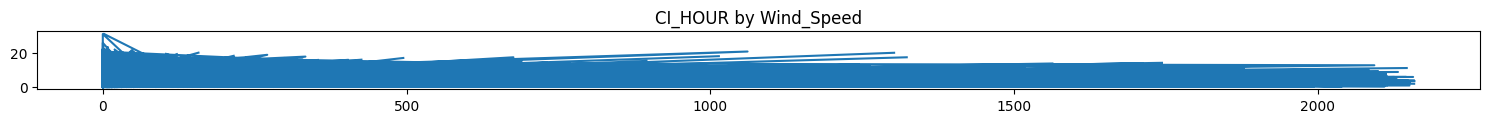

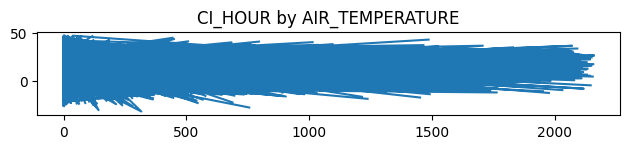

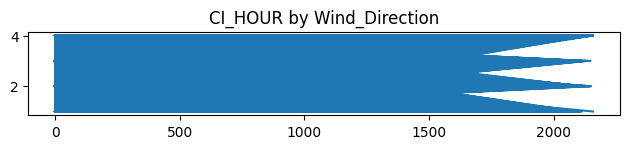

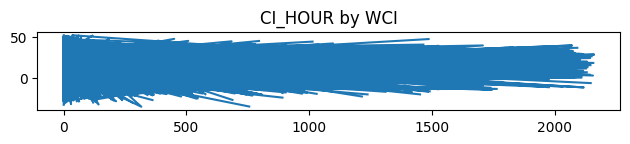

In [ ]:
columns = ['Wind_Speed', 'AIR_TEMPERATURE', 'Wind_Direction', 'WCI']
plt.figure(figsize = (15, len(columns)))
for i, col in enumerate(columns):
  plt.subplot(len(columns), 1, i+1)
  plt.plot(train['CI_HOUR'], train[col])
  plt.title(f'CI_HOUR by {col}')
  plt.tight_layout()
  plt.show()

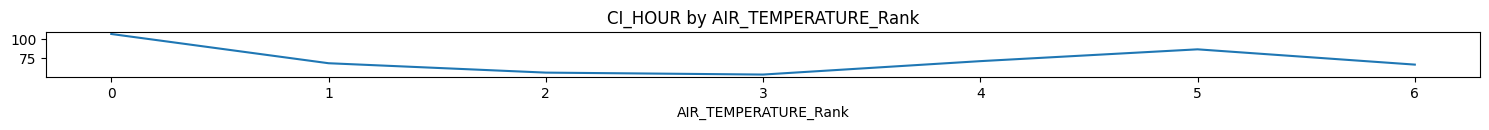

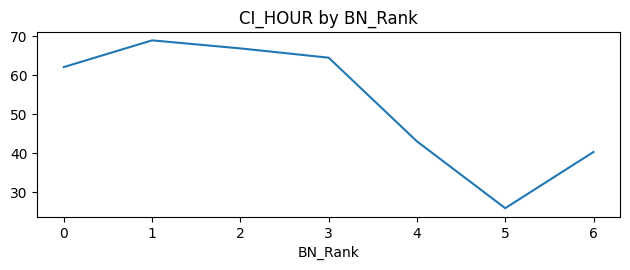

In [ ]:
columns = ['AIR_TEMPERATURE_Rank', 'BN_Rank']
plt.figure(figsize = (15, len(columns)))
for i, col in enumerate(columns):
  plt.subplot(len(columns), 1, i+1)
  train.groupby([col])['CI_HOUR'].mean().plot()
  plt.title(f'CI_HOUR by {col}')
  plt.tight_layout()
  plt.show()

In [ ]:
del train['YEAR']
del train['DAY']

del test['YEAR']
del test['DAY']

Encoding

In [ ]:
# 인코딩

needlabeling = ['BN_Rank', 'AIR_TEMPERATURE_Rank', 'TIME_DIFF', 'ID_ALPH', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'TIMEZONE1', 'SEASON', 'Wating']
#needlabeling = ['FLAG', 'ARI_CO_PO', 'SHIPMANAGER_COMP', 'BN_Rank', 'AIR_TEMPERATURE_Rank', 'ID_ALPH', 'Wating']
for col in needlabeling:
  if col in ['BN_Rank', 'AIR_TEMPERATURE_Rank', 'TIME_DIFF']:
    le = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    le.fit(np.array(train[col]).reshape(-1, 1))
    train[col] = le.transform(np.array(train[col]).reshape(-1, 1)).astype(int)
    test[col] = le.transform(np.array(test[col]).reshape(-1, 1)).astype(int)
    print(f'{col} apply ordinal encoding..')
  else:
    # le = LabelEncoder()
    # train[col] = le.fit_transform(train[col])
    # train[col] = train[col]
    # test[col] = le.transform(test[col])
    # test[col] = test[col]
    # print(f'{col} apply label encoding..')
    try:
      # le = LabelEncoder()
      # train[col] = le.fit_transform(train[col])
      # train[col] = train[col]
      # test[col] = le.transform(test[col])
      # test[col] = test[col]
      # print(f'{col} apply label encoding..')
      train[col] = train[col].astype(int)
      test[col] = test[col].astype(int)
      print(f'{col} apply astype int..')
    except:
      le = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
      le.fit(np.array(train[col]).reshape(-1, 1))
      train[col] = le.transform(np.array(train[col]).reshape(-1, 1)).astype(int)
      test[col] = le.transform(np.array(test[col]).reshape(-1, 1)).astype(int)
      print(f'{col} apply label encoding..')

BN_Rank apply ordinal encoding..
AIR_TEMPERATURE_Rank apply ordinal encoding..
TIME_DIFF apply ordinal encoding..
ID_ALPH apply label encoding..
MONTH apply astype int..
DAY_OF_WEEK apply astype int..
HOUR apply astype int..
TIMEZONE1 apply astype int..
SEASON apply astype int..
Wating apply astype int..


In [ ]:
# # 인코딩

# needdummy = ['TIME_DIFF_ABS', 'ID_ALPH', 'SEASON']
# for col in needdummy:
#   ohe = OneHotEncoder()
#   ohe.fit(np.array(train[col]).reshape(-1, 1))
#   ohe_train = ohe.transform(np.array(train[col]).reshape(-1, 1))
#   ohe_train_temp = pd.DataFrame(ohe_train.toarray(), columns=[f'{col}_{str(cat)}' for cat in ohe.categories_[0]])
#   train = pd.concat([train.drop(columns = [col], axis = 1), ohe_train_temp], axis = 1)
#   #train = np.hstack((train.drop(columns = [col], axis = 1), ohe_train_temp))
#   ohe_test = ohe.transform(np.array(test[col]).reshape(-1, 1))
#   ohe_test_temp = pd.DataFrame(ohe_test.toarray(), columns=[f'{col}_{str(cat)}' for cat in ohe.categories_[0]])
#   test = pd.concat([test.drop(columns = [col], axis = 1), ohe_test_temp], axis = 1)
#   #test = np.hstack((test.drop(columns = [col], axis = 1), ohe_test_temp))
#   print(f'{col} apply dummy encoding')

ADD Encoding

In [ ]:
for col in train.columns:
  if train[col].dtype == 'int':
    print(col)
    print(len(train[col].unique()))

cat_cols = ['FLAG', 'ARI_CO_PO', 'SHIPMANAGER_COMP', 'ID', 'SHIPMANAGER']

BUILT
64
DEADWEIGHT
1961
GT
1783
ATA_LT
24
ID_ALPH
26
Wating
2
MONTH
12
DAY_OF_WEEK
7
HOUR
24
TIME_DIFF
18
TIME_DIFF_ABS
11
TIMEZONE1
6
SEASON
4
BN_Rank
8
AIR_TEMPERATURE_Rank
8


In [ ]:
# 범주가 많지만 대기시간을 예측하는데 중요한 정보가 될 수 있는 변수 Target mean encoding + 정규화 or 랜덤 포레스트 인코딩 or Helmert 인코딩

def random_forest_encoding(train, test, target_col, cat_cols, SEED):
  train_encoded = train.copy()
  test_encoded = test.copy()

  for col in cat_cols:
    clf = RandomForestRegressor(n_estimators = 100, random_state = SEED)
    clf.fit(train_encoded[[col]], train_encoded[target_col])
    train_encoded[col] = clf.predict(train_encoded[[col]])
    test_encoded[col] = clf.predict(test_encoded[[col]])

  return train_encoded, test_encoded

#train, test = random_forest_encoding(train, test, 'CI_HOUR', cat_cols, SEED)

def helmert_encoding(train, test, cat_cols):
  train_encoded = train.copy()
  test_encoded = test.copy()

  encoder = ce.helmert_encoding(cols = cat_cols)
  train_encoded[cat_cols] = encoder.fit_transform(train_encoded[cat_cols])
  test_encoded[cat_cols] = encoder.transform(test_encoded[cat_cols])

  return train_encoded, test_encoded

#train, test = helmert_encoding(train, test, cat_cols)

# alpha 1, 5, 10, 50, 100
def target_encoding_smoothing(train, test, cat_cols): # alpha
  train_encoded = train.copy()
  test_encoded = test.copy()

  encoder = ce.TargetEncoder(cols = cat_cols) #  smoothing = alpha
  train_encoded[cat_cols] = encoder.fit_transform(train_encoded[cat_cols], train_encoded.CI_HOUR)
  test_encoded[cat_cols] = encoder.transform(test_encoded[cat_cols])

  return train_encoded, test_encoded

train, test = target_encoding_smoothing(train, test, cat_cols) # , alpha = 5

def frequency_encoding(train, test, cat_cols):
  train_encoded = train.copy()
  test_encoded = test.copy()

  for col in cat_cols:
    train_frequency_map = train_encoded[col].value_counts(normalize=True).to_dict()

    train_encoded[col] = train_encoded[col].map(train_frequency_map)
    test_encoded[col] = test_encoded[col].map(train_frequency_map)

  return train_encoded, test_encoded

#train, test = frequency_encoding(train, test, cat_cols)

In [ ]:
train[cat_cols], test[cat_cols]

(             FLAG   ARI_CO_PO  SHIPMANAGER_COMP          ID  SHIPMANAGER
 0       64.871946  109.019326         47.384196   67.615883    38.647711
 1       71.257135   64.673213         49.212817   52.999496    97.166903
 2       64.500805   55.686871         75.184697   24.498247    79.036670
 3       54.749401   45.479251         48.167847   10.206132    30.551237
 4       68.482039  109.019326         75.668912   38.046423    33.454474
 ...           ...         ...               ...         ...          ...
 391910  61.773754   19.513979         56.880777   20.507442    17.404066
 391911  77.495206  109.019326         81.119525  251.944410   251.944410
 391912  57.266256   55.006330         67.406488   63.388762    43.071971
 391913  41.074514   23.261018         54.704908   18.632048    15.871305
 391914  42.554790   23.261018         48.574332  157.977426    22.184304
 
 [391915 rows x 5 columns],
              FLAG   ARI_CO_PO  SHIPMANAGER_COMP          ID  SHIPMANAGER
 0      

클러스터링

In [ ]:
print('train')

print('Container')
print(train.loc[train['SHIP_TYPE_CATEGORY'] == 'Container', 'DEADWEIGHT'].min(), train.loc[train['SHIP_TYPE_CATEGORY'] == 'Container', 'DEADWEIGHT'].max())
print('Bulk')
print(train.loc[train['SHIP_TYPE_CATEGORY'] == 'Bulk', 'DEADWEIGHT'].min(), train.loc[train['SHIP_TYPE_CATEGORY'] == 'Bulk', 'DEADWEIGHT'].max())
print('Cargo')
print(train.loc[train['SHIP_TYPE_CATEGORY'] == 'Cargo', 'DEADWEIGHT'].min(), train.loc[train['SHIP_TYPE_CATEGORY'] == 'Cargo', 'DEADWEIGHT'].max())
print('Tanker')
print(train.loc[train['SHIP_TYPE_CATEGORY'] == 'Tanker', 'DEADWEIGHT'].min(), train.loc[train['SHIP_TYPE_CATEGORY'] == 'Tanker', 'DEADWEIGHT'].max())

print('test')

print('Container')
print(test.loc[test['SHIP_TYPE_CATEGORY'] == 'Container', 'DEADWEIGHT'].min(), test.loc[test['SHIP_TYPE_CATEGORY'] == 'Container', 'DEADWEIGHT'].max())
print('Bulk')
print(test.loc[test['SHIP_TYPE_CATEGORY'] == 'Bulk', 'DEADWEIGHT'].min(), test.loc[test['SHIP_TYPE_CATEGORY'] == 'Bulk', 'DEADWEIGHT'].max())
print('Cargo')
print(test.loc[test['SHIP_TYPE_CATEGORY'] == 'Cargo', 'DEADWEIGHT'].min(), test.loc[test['SHIP_TYPE_CATEGORY'] == 'Cargo', 'DEADWEIGHT'].max())
print('Tanker')
print(test.loc[test['SHIP_TYPE_CATEGORY'] == 'Tanker', 'DEADWEIGHT'].min(), test.loc[test['SHIP_TYPE_CATEGORY'] == 'Tanker', 'DEADWEIGHT'].max())

train
Container
1360 242000
Bulk
550 404000
Cargo
100 73300
Tanker
200 323000
test
Container
1040 242000
Bulk
700 404000
Cargo
100 97700
Tanker
200 323000


In [ ]:
for ship_type in train['SHIP_TYPE_CATEGORY'].unique():
  print(ship_type)
  #silhouette_scores = []
  #fig, ax = plt.subplots(1, 1)
  distance = []
  for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    subset = train[train['SHIP_TYPE_CATEGORY'] == ship_type]
    X = subset[['DEADWEIGHT']]
    kmeans.fit(X)
    distance.append(kmeans.inertia_)

  sns.lineplot(x= range(2, 10) , y= distance)

    # score = silhouette_score(X, kmeans.labels_)
    # silhouette_scores.append(score)

    # silhouette_vals = silhouette_samples(X, kmeans.labels_)
    # y_ticks = []
    # y_lower = y_upper = 0
    # for c_num in np.unique(kmeans.labels_):
    #   cluster_silhouette_vals = silhouette_vals[kmeans.labels_==c_num]
    #   y_upper += len(cluster_silhouette_vals)
    #   cluster_silhouette_vals.sort()

    #   ax.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1)
    #   y_lower += len(cluster_silhouette_vals)

  # # 실루엣 분석 그래프 그리기
  # plt.plot(range(2, 7), silhouette_scores, marker='o')
  plt.show()

In [ ]:
for ship_type in train['SHIP_TYPE_CATEGORY'].unique():

  n_cluster = 4

  subset = train[train['SHIP_TYPE_CATEGORY'] == ship_type]
  X = subset[['DEADWEIGHT']]
  kmeans = KMeans(n_clusters = n_cluster)
  kmeans.fit(X)

  subset['CLUSTER'] = kmeans.labels_

  print('CLUSTER 0:', subset.loc[subset['CLUSTER'] == 0, 'DEADWEIGHT'].min(), subset.loc[subset['CLUSTER'] == 0, 'DEADWEIGHT'].max())
  print('CLUSTER 1:', subset.loc[subset['CLUSTER'] == 1, 'DEADWEIGHT'].min(), subset.loc[subset['CLUSTER'] == 1, 'DEADWEIGHT'].max())
  print('CLUSTER 2:', subset.loc[subset['CLUSTER'] == 2, 'DEADWEIGHT'].min(), subset.loc[subset['CLUSTER'] == 2, 'DEADWEIGHT'].max())
  print('CLUSTER 3:', subset.loc[subset['CLUSTER'] == 3, 'DEADWEIGHT'].min(), subset.loc[subset['CLUSTER'] == 3, 'DEADWEIGHT'].max())

  plt.figure(figsize=(8, 6))
  plt.scatter(subset.index, subset['DEADWEIGHT'], c=subset['CLUSTER'], cmap='rainbow')
  plt.xlabel('DEADWEIGHT')
  plt.title(f'Clustering for {ship_type}')
  plt.show()

In [ ]:
# 선박의 DWT 크기 분포를 활용하여 클러스터링 진행 -> 세부 선박 종류를 유추

def get_type_cluster(row):
  ship_type = row['SHIP_TYPE_CATEGORY']
  dwt = row['DEADWEIGHT']

  if ship_type == 'Container':
    if (dwt >= 1360) & (dwt < 29700):
      cluster = (ship_type) + '0'
    elif (dwt >= 29700) & (dwt < 56200):
      cluster = ship_type + '1'
    elif (dwt >= 56200) & (dwt < 89900):
      cluster = ship_type + '2'
    elif (dwt >= 89900) & (dwt < 139000):
      cluster = ship_type + '3'
    else:
      cluster = ship_type + '4'
  elif ship_type == 'Bulk':
    if (dwt >= 550) & (dwt < 40500):
      cluster = ship_type + '0'
    elif (dwt >= 40500) & (dwt < 69700):
      cluster = ship_type + '1'
    elif (dwt >= 69700) & (dwt < 138000):
      cluster = ship_type + '2'
    elif (dwt >= 138000) & (dwt < 243000):
      cluster = ship_type + '3'
    else:
      cluster = ship_type + '4'

  elif ship_type == 'Cargo':
    if (dwt >= 100) & (dwt < 4920):
      cluster = ship_type + '0'
    elif (dwt >= 4920) & (dwt < 11100):
      cluster = ship_type + '1'
    elif (dwt >= 11100) & (dwt < 24000):
      cluster = ship_type + '2'
    elif (dwt >= 24000) & (dwt < 44600):
      cluster = ship_type + '3'
    else:
      cluster = ship_type + '4'

  else:
    if (dwt >= 200) & (dwt < 24600):
      cluster = ship_type + '0'
    elif (dwt >= 24600) & (dwt < 70200):
      cluster = ship_type + '1'
    elif (dwt >= 70200) & (dwt < 130000):
      cluster = ship_type + '2'
    elif (dwt >= 130000) & (dwt < 282000):
      cluster = ship_type + '3'
    else:
      cluster = ship_type + '4'

  return cluster

train['CLUSTER'] = train.apply(get_type_cluster, axis = 1)
test['CLUSTER'] = test.apply(get_type_cluster, axis = 1)

In [ ]:
#train['CI_HOUR'] = np.floor(train['CI_HOUR']) # 소수점 자리는 학습이 어려울 수도 자릿수 제거

In [ ]:
del train['CLUSTER']
del test['CLUSTER']

지연 가능성 점수

In [ ]:
class MyDatasetB(Dataset):
  def __init__(self, df, columns, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    sample = self.df[idx]

    if self.transform:
      sample = self.transform(sample)

    return sample

In [ ]:
class MyDatasetA(Dataset):
  def __init__(self, df, columns, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    sample = self.df[idx]

    if self.transform:
      sample = self.transform(sample)

    return sample

In [ ]:
class LayerNormalization(nn.Module):
  def __init__(self, features, epsilon=1e-6):
    super(LayerNormalization, self).__init__()
    self.gamma = nn.Parameter(torch.ones(features))
    self.beta = nn.Parameter(torch.zeros(features))
    self.epsilon = epsilon

  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.gamma * (x - mean) / (std + self.epsilon) + self.beta

class VAE(nn.Module):
  def __init__(self, input_dim, latent_dim):
    super(VAE, self).__init__()

    # encoder
    self.encoder = nn.Sequential(
      nn.Linear(input_dim, 128),
      LayerNormalization(128),
      nn.ReLU(),
      nn.Linear(128, 64),
      LayerNormalization(64),
      nn.ReLU(),
      nn.Linear(64, 32),
      LayerNormalization(32),
      nn.ReLU()
    )
    self.fc_mu = nn.Linear(32, latent_dim)
    self.fc_log_var = nn.Linear(32, latent_dim)

    # decoder
    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, 32),
      LayerNormalization(32),
      nn.ReLU(),
      nn.Linear(32, 64),
      LayerNormalization(64),
      nn.ReLU(),
      nn.Linear(64, 128),
      LayerNormalization(128),
      nn.ReLU(),
      nn.Linear(128, input_dim),
      nn.Sigmoid()
    )

  def encode(self, x):
    h = self.encoder(x)
    return self.fc_mu(h), self.fc_log_var(h)

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z):
    return self.decoder(z)

  def forward(self, x):
    mu, log_var = self.encode(x)
    z = self.reparameterize(mu, log_var)
    return self.decode(z), mu, log_var

In [ ]:
def z_score_normalization(data):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    normalized_data = (data - mean) / std
    return normalized_data

In [ ]:
state_columns = ['DIST', 'DEADWEIGHT', 'GT', 'Wind_Speed', 'WCI', 'AIR_TEMPERATURE', 'BN']
before_columns = [col for col in state_columns if col not in ['Wind_Speed', 'WCI', 'AIR_TEMPERATURE', 'BN']]

train_before = train.loc[train.ATA < '2019-01-01', before_columns].values
train_after = train.loc[train.ATA >= '2019-01-01', state_columns].values
test_before = test.loc[test.ATA < '2019-01-01', before_columns].values
test_after = test.loc[test.ATA >= '2019-01-01', state_columns].values

train_before_norm = z_score_normalization(train_before)
train_after_norm = z_score_normalization(train_after)
test_before_norm = z_score_normalization(test_before)
test_after_norm = z_score_normalization(test_after)

before_train_tensor = torch.tensor(train_before, dtype = torch.float32)
after_train_tensor = torch.tensor(train_after, dtype = torch.float32)
before_test_tensor = torch.tensor(test_before, dtype = torch.float32)
after_test_tensor = torch.tensor(test_after, dtype = torch.float32)

before_state_train = MyDatasetB(df=before_train_tensor, columns=state_columns)
after_state_train = MyDatasetA(df=after_train_tensor, columns=state_columns)
before_state_test = MyDatasetB(df=before_test_tensor, columns=state_columns)
after_state_test = MyDatasetA(df=after_test_tensor, columns=state_columns)

before_train_loader = DataLoader(before_state_train, batch_size = 32, shuffle = False)
after_train_loader = DataLoader(after_state_train, batch_size = 32, shuffle = False)
before_test_loader = DataLoader(before_state_test, batch_size = 32, shuffle = False)
after_test_loader = DataLoader(after_state_test, batch_size = 32, shuffle = False)

class Trainer():
  def __init__(self, train_loader, train_data, model, optimizer, scheduler, criterion, device, file_path):
    self.train_loader = train_loader
    self.train_data = train_data
    self.model = model
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.device = device
    self.criterion = criterion
    self.num_epochs = 50
    self.file_path = file_path

  def fit(self):
    #self.model.to(self.device)
    best_score = 0
    for epoch in range(self.num_epochs):
      self.model.train()
      for data in iter(self.train_loader):
        #data = data.to(self.device)
        self.optimizer.zero_grad()
        recon_batch, mu, log_var = self.model(data)
        loss = 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        #loss = self.criterion(recon_batch, data)
        loss.backward()
        self.optimizer.step()

      score = self.inference(self.model, self.train_data).mean()

      if self.scheduler is not None:
        self.scheduler.step(score)

      if best_score <= score:
        best_score = score
        print(file_path)
        torch.save(model.state_dict(), f'{self.file_path}')
        print('--- --- --- Best update --- --- ---')
        print(f'Epoch: [{epoch + 1}/{self.num_epochs}] Loss: [{loss.item()}] Score: [{score}]')

      print(f'Epoch: [{epoch + 1}/{self.num_epochs}] Loss: [{loss.item()}] Score: [{score}]')

    if os.path.isfile(self.file_path):
      print('file is already exist')
    else:
      torch.save(model.state_dict(), f'{self.file_path}')

  def inference(self, model, train_data):
    model.eval()
    #train_data = train_data.to(self.device)
    with torch.no_grad():
      inferenced_data, _, _ = model(train_data)
      inferenced_data = inferenced_data#.cpu().detach().numpy()
      real_data = train_data#.cpu().detach().numpy()
      score = cosine_similarity(inferenced_data, real_data)

    return score

device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
input_dim = len(before_columns)
latent_dim = 10
model = VAE(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
file_path = '/content/best_before_model.pth'
trainer = Trainer(before_train_loader, before_train_tensor, model, optimizer, scheduler, criterion, device, file_path)
trainer.fit()
model = VAE(input_dim, latent_dim)#.to(device)
model.load_state_dict(torch.load(f'{file_path}'))
before_train_scores = trainer.inference(model, before_train_tensor)
before_test_scores = trainer.inference(model, before_test_tensor)

input_dim = len(state_columns)
latent_dim = 10
model = VAE(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
file_path = '/content/best_after_model.pth'
trainer = Trainer(after_train_loader, after_train_tensor, model, optimizer, scheduler, criterion, device, file_path)
trainer.fit()
model = VAE(input_dim, latent_dim)#.to(device)
model.load_state_dict(torch.load(f'{file_path}'))
after_train_scores = trainer.inference(model, after_train_tensor)
after_test_scores = trainer.inference(model, after_test_tensor)

/content/best_before_model.pth
--- --- --- Best update --- --- ---
Epoch: [1/50] Loss: [-3.604445758298071e+20] Score: [0.6872269511222839]
Epoch: [1/50] Loss: [-3.604445758298071e+20] Score: [0.6872269511222839]
Epoch: [2/50] Loss: [-3.604450684110163e+20] Score: [0.6872005462646484]
/content/best_before_model.pth
--- --- --- Best update --- --- ---
Epoch: [3/50] Loss: [-3.604443999079466e+20] Score: [0.6874698996543884]
Epoch: [3/50] Loss: [-3.604443999079466e+20] Score: [0.6874698996543884]
Epoch: [4/50] Loss: [-3.604470387358533e+20] Score: [0.6874287724494934]
Epoch: [5/50] Loss: [-3.6044841092636475e+20] Score: [0.6872793436050415]
Epoch: [6/50] Loss: [-3.604481998201322e+20] Score: [0.6872702836990356]
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch: [7/50] Loss: [-3.6044872758571355e+20] Score: [0.6872386336326599]
Epoch: [8/50] Loss: [-3.6044932572003906e+20] Score: [0.6871519684791565]
Epoch: [9/50] Loss: [-3.6044964237938786e+20] Score: [0.687366008758544

In [ ]:
before_mean_delay = before_train_scores#.cpu().detach().numpy().mean()
before_std_delay = before_train_scores#.cpu().detach().numpy().std()
before_delay_probability = stats.norm.cdf(before_train_scores, loc=before_mean_delay, scale=before_std_delay)
before_delay_probability_percentage = before_delay_probability * 100

before_mean_delay_t = before_test_scores#.cpu().detach().numpy().mean()
before_std_delay_t = before_test_scores#.cpu().detach().numpy().std()
before_delay_probability_t = stats.norm.cdf(before_test_scores, loc=before_mean_delay_t, scale=before_std_delay_t)
before_delay_probability_percentage_t = before_delay_probability_t * 100

after_mean_delay = after_train_scores#.cpu().detach().numpy().mean()
after_std_delay = after_train_scores#.cpu().detach().numpy().std()
after_delay_probability = stats.norm.cdf(after_train_scores, loc=after_mean_delay, scale=after_std_delay)
after_delay_probability_percentage = after_delay_probability * 100

after_mean_delay_t = after_test_scores#.cpu().detach().numpy().mean()
after_std_delay_t = after_test_scores#.cpu().detach().numpy().std()
after_delay_probability_t = stats.norm.cdf(after_test_scores, loc=after_mean_delay_t, scale=after_std_delay_t)
after_delay_probability_percentage_t = after_delay_probability_t * 100

In [ ]:
before_X_train = train.loc[train.ATA < '2019-01-01', before_columns]
before_y_train = before_delay_probability_percentage
after_X_train = train.loc[train.ATA >= '2019-01-01', state_columns]
after_y_train = after_delay_probability_percentage

before_X_test = test.loc[test.ATA < '2019-01-01', before_columns]
before_y_test = before_delay_probability_percentage_t
after_X_test = test.loc[test.ATA >= '2019-01-01', state_columns]
after_y_test = after_delay_probability_percentage_t

In [ ]:
# model = XGBRegressor()
# kf = KFold(n_splits = 5, shuffle = True, random_state = SEED)
# scores = []
# test_preds = []
# for train_idx, val_idx, in tqdm(kf.split(before_X_train, before_y_train)):
#   X_train, X_val = before_X_train.iloc[train_idx], before_X_train.iloc[val_idx]
#   y_train, y_val = before_y_train[train_idx], before_y_train[val_idx]

#   model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)], verbose = 0)

#   val_pred = model.predict(X_val)

#   scores.append(mean_absolute_error(y_val, val_pred))
#   test_pred = model.predict(before_X_test)

#   test_preds.append(test_pred)

# before_test_prediction = np.mean(test_preds, axis = 0)

# print('Validation MAE Scores:', scores)
# print('Validation Mean MAE Score:', np.mean(scores))

In [ ]:
# model = XGBRegressor()
# kf = KFold(n_splits = 5, shuffle = True, random_state = SEED)
# scores = []
# test_preds = []
# for train_idx, val_idx, in tqdm(kf.split(after_X_train, after_y_train)):
#   X_train, X_val = after_X_train.iloc[train_idx], after_X_train.iloc[val_idx]
#   y_train, y_val = after_y_train[train_idx], after_y_train[val_idx]

#   model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)], verbose = 0)

#   val_pred = model.predict(X_val)

#   scores.append(mean_absolute_error(y_val, val_pred))
#   test_pred = model.predict(after_X_test)

#   test_preds.append(test_pred)

# after_test_prediction = np.mean(test_preds, axis = 0)

# print('Validation MAE Scores:', scores)
# print('Validation Mean MAE Score:', np.mean(scores))

In [ ]:
train['DELAY_PROB'] = 0
test['DELAY_PROB'] = 0

train.loc[train.ATA < '2019-01-01', 'DELAY_PROB'] = before_delay_probability_percentage
train.loc[train.ATA >= '2019-01-01', 'DELAY_PROB'] = after_delay_probability_percentage
test.loc[test.ATA < '2019-01-01', 'DELAY_PROB'] = before_delay_probability_percentage_t
test.loc[test.ATA >= '2019-01-01', 'DELAY_PROB'] = after_delay_probability_percentage_t

In [ ]:
train.isnull().sum()[train.isnull().sum() > 0].index

Index(['AIR_TEMPERATURE', 'BN', 'Wind_Speed', 'Wind_Direction', 'WCI'], dtype='object')

In [ ]:
# del train['U_WIND']
# del test['U_WIND']

# del train['V_WIND']
# del test['V_WIND']

# del train['AIR_TEMPERATURE']
# del test['AIR_TEMPERATURE']

# del train['Wind_Speed']
# del test['Wind_Speed']

# del train['WCI']
# del test['WCI']

# del train['BN']
# del test['BN']

del train['Wind_Direction']
del test['Wind_Direction']

Normalize

In [ ]:
# 선박의 수치적 특성 및 온도, 날씨에 관련된 정보는 스케일에 민감하므로, 정규화가 필요함

scaling_cols1 = ['BREADTH', 'DEADWEIGHT', 'GT', 'LENGTH', 'PORT_SIZE', 'DIST', 'BUILT', 'TIME_DIFF_ABS'] # 'GT_FOR_DEADWEIGHT', 'BUILT', 'BUILT_BACK', 'SIZE', 'TOPSIDE'

for col in train.columns:
  if col in scaling_cols1:
    scaler = StandardScaler()
    #scaler = QuantileTransformer(output_distribution = 'normal', n_quantiles=100)
    train[col] = scaler.fit_transform(train[col].values.reshape(-1, 1))
    test[col] = scaler.transform(test[col].values.reshape(-1, 1))

scaling_cols2 = ['AIR_TEMPERATURE', 'Wind_Speed', 'WCI', 'BN'] # 'U_WIND', 'V_WIND'

for col in train.columns:
  if col in scaling_cols2:
    scaler = StandardScaler()
    #scaler = QuantileTransformer(output_distribution = 'normal', n_quantiles=100)
    train[col] = scaler.fit_transform(train[col].values.reshape(-1, 1))
    test[col] = scaler.transform(test[col].values.reshape(-1, 1))

# Modeling

In [ ]:
# 'SHIPMANAGER', 'CLUSTER' 인코딩

needlabeling = list(train.columns[1:])
for col in needlabeling:
  if col in ['SHIP_TYPE_CATEGORY', 'CLUSTER']:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    train[col] = train[col]
    test[col] = le.transform(test[col])
    test[col] = test[col]
    print(f'{col} apply label encoding..')

SHIP_TYPE_CATEGORY apply label encoding..


In [ ]:
del train['ARI_CO']
del train['ID']
del train['SHIPMANAGER']

del test['ARI_CO']
del test['ID']
del test['SHIPMANAGER']

In [ ]:
isna_condition_before = (train.ATA >= '2014-09-01') & (train.ATA < '2019-01-01')
isna_condition_before_t = (test.ATA >= '2014-09-01') & (test.ATA < '2019-01-01')
train1 = train.loc[isna_condition_before]
test1 = test.loc[isna_condition_before_t]
train1.drop(['AIR_TEMPERATURE', 'BN', 'Wind_Speed', 'BN_Rank', 'AIR_TEMPERATURE_Rank', 'WCI'], axis = 1, inplace = True) # 'U_WIND', 'V_WIND'
test1.drop(['AIR_TEMPERATURE', 'BN', 'Wind_Speed', 'BN_Rank', 'AIR_TEMPERATURE_Rank', 'WCI'], axis = 1, inplace = True) # 'U_WIND', 'V_WIND'

isna_condition_after = (train.ATA >= '2019-01-01')
isna_condition_after_t = (test.ATA >= '2019-01-01')
train2 = train.loc[isna_condition_after]
test2 = test.loc[isna_condition_after_t]

In [ ]:
isna_condition = (train.ATA > '2014-09-01') & (train.ATA < '2019-01-01')
isna_condition_t = (test.ATA > '2014-09-01') & (test.ATA < '2019-01-01')

train1 = train.loc[isna_condition]
test1 = test.loc[isna_condition_t]
train1.drop(['AIR_TEMPERATURE', 'BN', 'Wind_Speed', 'BN_Rank', 'AIR_TEMPERATURE_Rank', 'WCI'], axis = 1, inplace = True) # 'U_WIND', 'V_WIND'
test1.drop(['AIR_TEMPERATURE', 'BN', 'Wind_Speed', 'BN_Rank', 'AIR_TEMPERATURE_Rank', 'WCI'], axis = 1, inplace = True) # 'U_WIND', 'V_WIND'
train2 = train.loc[~isna_condition]
test2 = test.loc[~isna_condition_t]

In [ ]:
corr_groups1 = [
    ['BREADTH', 'DEADWEIGHT', 'GT', 'LENGTH'] # 'DEPTH', 'DRAUGHT'
]

corr_groups2 = [
    ['BREADTH', 'DEADWEIGHT', 'GT', 'LENGTH'], # 'DEPTH', 'DRAUGHT'
    ['BN', 'Wind_Speed'],
    ['AIR_TEMPERATURE', 'WCI']
]

for i, group in enumerate(corr_groups1):
  print(group)
  pca = PCA()
  pca.fit(train1[group])
  print("주성분(PC)의 설명된 분산량:", pca.explained_variance_ratio_)

  n_components = len(group)//2
  pca = PCA(n_components = n_components)
  train_pca1 = pca.fit_transform(train1.loc[:, group])
  for g in range(0, n_components):
    train1[f'GROUP{i}_PCA{g}'] = train_pca1[:, g]
  train1.drop(group, axis = 1, inplace = True)
  test_pca1 = pca.transform(test1.loc[:, group])
  for g in range(0, n_components):
    test1[f'GROUP{i}_PCA{g}'] = test_pca1[:, g]
  test1.drop(group, axis = 1, inplace = True)
print('train1 pca completed')

for i, group in enumerate(corr_groups2):
  print(group)
  pca = PCA()
  pca.fit(train2[group])
  print("주성분(PC)의 설명된 분산량:", pca.explained_variance_ratio_)

  n_components = len(group) // 2
  pca = PCA(n_components = n_components)
  train_pca2 = pca.fit_transform(train2.loc[:, group])
  for g in range(0, n_components):
    train2[f'GROUP{i}_PCA{g}'] = train_pca2[:, g]
  train2.drop(group, axis = 1, inplace = True)
  test_pca2 = pca.transform(test2.loc[:, group])
  for g in range(0, n_components):
    test2[f'GROUP{i}_PCA{g}'] = test_pca2[:, g]
  test2.drop(group, axis = 1, inplace = True)

print('train2 pca completed')

['BREADTH', 'DEADWEIGHT', 'GT', 'LENGTH']
주성분(PC)의 설명된 분산량: [0.91667025 0.04927822 0.02403008 0.01002144]
train1 pca completed
['BREADTH', 'DEADWEIGHT', 'GT', 'LENGTH']
주성분(PC)의 설명된 분산량: [0.92126682 0.04734941 0.02024564 0.01113813]
['BN', 'Wind_Speed']
주성분(PC)의 설명된 분산량: [0.98778344 0.01221656]
['AIR_TEMPERATURE', 'WCI']
주성분(PC)의 설명된 분산량: [0.99338142 0.00661858]
train2 pca completed


In [ ]:
categorical_cols = ['ID_ALPH', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'TIMEZONE1', 'SEASON', 'Wating', 'HOLIDAY', 'SHIP_TYPE_CATEGORY', 'CLUSTER', 'BN_Rank', 'AIR_TEMPERATURE_Rank']
continous_cols = (train.columns[1:]).difference(categorical_cols + ['CI_HOUR'])

In [ ]:
categorical_cols

['ID_ALPH',
 'YEAR',
 'MONTH',
 'DAY_OF_WEEK',
 'HOUR',
 'TIMEZONE1',
 'SEASON',
 'Wating',
 'HOLIDAY',
 'SHIP_TYPE_CATEGORY',
 'CLUSTER',
 'BN_Rank',
 'AIR_TEMPERATURE_Rank']

In [ ]:
continous_cols

Index(['AIR_TEMPERATURE', 'ARI_CO_PO', 'ATA', 'ATA_LT', 'BN', 'BREADTH',
       'BUILT', 'DEADWEIGHT', 'DELAY_PROB', 'DEPTH', 'DIST', 'DRAUGHT', 'FLAG',
       'GT', 'LENGTH', 'PORT_SIZE', 'SHIPMANAGER_COMP', 'TIME_DIFF',
       'TIME_DIFF_ABS', 'WCI', 'Wind_Speed'],
      dtype='object')

In [ ]:
# train1 = train1.replace([np.inf, -np.inf], np.nan)
train1.isnull().sum()[train1.isnull().sum() > 0]

Series([], dtype: int64)

In [ ]:
#train2 = train2.replace([np.inf, -np.inf], np.nan)
train2.isnull().sum()[train2.isnull().sum() > 0]

Series([], dtype: int64)

In [ ]:
corr_train1 = train1.corr(method = 'pearson')
set(train1.columns).difference(set(corr_train1.index))

{'ATA', 'SAMPLE_ID'}

In [ ]:
corr_train1 = train1.corr(method = 'pearson')
corr_train1_col = corr_train1['CI_HOUR'].reset_index()
corr_train1_col = corr_train1_col.sort_values(by = ['CI_HOUR'], ascending = False)
corr_train1_drops = corr_train1_col.loc[np.abs(corr_train1_col.CI_HOUR) < 0.001, 'index']
print(corr_train1_col)
print('-----drops-----')
print(corr_train1_drops)

                 index   CI_HOUR
12             CI_HOUR  1.000000
15              Wating  0.305541
16           ARI_CO_PO  0.225369
1                 DIST  0.176090
18         DAY_OF_WEEK  0.110970
14    SHIPMANAGER_COMP  0.077029
9                 FLAG  0.076543
4           DEADWEIGHT  0.073232
7                   GT  0.055686
5                DEPTH  0.049742
2              BREADTH  0.042615
6              DRAUGHT  0.039094
8               LENGTH  0.034246
23              SEASON  0.015826
17               MONTH  0.012169
19                HOUR  0.008425
22           TIMEZONE1  0.005470
10              ATA_LT  0.002383
3                BUILT  0.000103
20           TIME_DIFF -0.008056
13             ID_ALPH -0.011896
21       TIME_DIFF_ABS -0.039066
0   SHIP_TYPE_CATEGORY -0.108604
11           PORT_SIZE -0.230855
24          DELAY_PROB       NaN
-----drops-----
3    BUILT
Name: index, dtype: object


In [ ]:
corr_train2 = train2.corr(method = 'pearson')
set(train2.columns).difference(set(corr_train2.index))

{'ATA', 'SAMPLE_ID'}

In [ ]:
corr_train2 = train2.corr(method = 'pearson')
corr_train2_col = corr_train2['CI_HOUR'].reset_index()
corr_train2_col = corr_train2_col.sort_values(by = ['CI_HOUR'], ascending = False)
corr_train2_drops = corr_train2_col.loc[np.abs(corr_train2_col.CI_HOUR) < 0.001, 'index']
print(corr_train2_col)
print('-----drops-----')
print(corr_train2_drops)

                   index   CI_HOUR
14               CI_HOUR  1.000000
17                Wating  0.290143
18             ARI_CO_PO  0.237809
1                   DIST  0.197980
20           DAY_OF_WEEK  0.111950
9                   FLAG  0.105691
4             DEADWEIGHT  0.085963
7                     GT  0.067447
16      SHIPMANAGER_COMP  0.066469
5                  DEPTH  0.058917
2                BREADTH  0.051196
6                DRAUGHT  0.046426
8                 LENGTH  0.043834
28  AIR_TEMPERATURE_Rank  0.035518
10       AIR_TEMPERATURE  0.035469
29                   WCI  0.033599
21                  HOUR  0.006983
3                  BUILT  0.006328
19                 MONTH  0.000864
12                ATA_LT -0.001084
15               ID_ALPH -0.005778
24             TIMEZONE1 -0.005938
25                SEASON -0.007427
27               BN_Rank -0.007785
22             TIME_DIFF -0.011570
11                    BN -0.013633
26            Wind_Speed -0.015834
23         TIME_DIFF

In [ ]:
vif1 = pd.DataFrame()
vif1["VIF Factor"] = [variance_inflation_factor(train1.drop(['ATA', 'SAMPLE_ID'], axis = 1).values, i) for i in range(train1.drop(['ATA', 'SAMPLE_ID'], axis = 1).shape[1])]
vif1["features"] = train1.drop(['ATA', 'SAMPLE_ID'], axis = 1).columns
print(vif1)

    VIF Factor            features
0     2.436926  SHIP_TYPE_CATEGORY
1     1.536609                DIST
2     7.290640             BREADTH
3     1.136827               BUILT
4    17.640038          DEADWEIGHT
5     3.547015               DEPTH
6     4.004276             DRAUGHT
7    25.568219                  GT
8    11.259872              LENGTH
9     1.122839                FLAG
10    1.168845              ATA_LT
11    5.225052           PORT_SIZE
12    1.156422             CI_HOUR
13    1.002136             ID_ALPH
14    1.138328    SHIPMANAGER_COMP
15    4.471060              Wating
16    1.287281           ARI_CO_PO
17    1.058865               MONTH
18    1.037402         DAY_OF_WEEK
19    1.078068                HOUR
20    2.285105           TIME_DIFF
21    2.382686       TIME_DIFF_ABS
22    1.193119           TIMEZONE1
23    1.058317              SEASON
24  186.043538          DELAY_PROB


In [ ]:
#vif1.loc[(vif1['VIF Factor'] == np.inf) | (vif1['VIF Factor'] == -np.inf), 'features']

In [ ]:
#drops1 = vif1.loc[vif1['VIF Factor'] > 50, 'features'].tolist()

In [ ]:
#drops1

In [ ]:
vif2 = pd.DataFrame()
vif2["VIF Factor"] = [variance_inflation_factor(train2.drop(['ATA', 'SAMPLE_ID'], axis = 1).values, i) for i in range(train2.drop(['ATA', 'SAMPLE_ID'], axis = 1).shape[1])]
vif2["features"] = train2.drop(['ATA', 'SAMPLE_ID'], axis = 1).columns
print(vif2)

    VIF Factor              features
0     1.792806    SHIP_TYPE_CATEGORY
1     1.399458                  DIST
2     9.488974               BREADTH
3     1.130597                 BUILT
4    14.723261            DEADWEIGHT
5     4.129204                 DEPTH
6     3.136684               DRAUGHT
7    19.682546                    GT
8    12.868996                LENGTH
9     1.147341                  FLAG
10   75.139878       AIR_TEMPERATURE
11   45.962374                    BN
12    1.216132                ATA_LT
13    3.712066             PORT_SIZE
14    1.152199               CI_HOUR
15    1.001192               ID_ALPH
16    1.082828      SHIPMANAGER_COMP
17    3.129814                Wating
18    1.368471             ARI_CO_PO
19    1.095229                 MONTH
20    1.037993           DAY_OF_WEEK
21    1.080610                  HOUR
22    1.710309             TIME_DIFF
23    1.841968         TIME_DIFF_ABS
24    1.235525             TIMEZONE1
25    1.185046                SEASON
2

In [ ]:
# # Function to calculate VIF
# def calculate_vif(data):
#   vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
#   x_var_names = data.columns
#   for i in range(0, x_var_names.shape[0]):
#     y = data[x_var_names[i]]
#     x = data[x_var_names.drop([x_var_names[i]])]
#     r_squared = sm.OLS(y,x).fit().rsquared
#     vif = round(1/(1-r_squared),2)
#     vif_df.loc[i] = [x_var_names[i], vif]

#   return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

# X=train[['DAY_OF_WEEK_0',
#        'DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4',
#        'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'HOUR_0', 'HOUR_1', 'HOUR_2',
#        'HOUR_3', 'HOUR_4', 'HOUR_5', 'HOUR_6', 'HOUR_7', 'HOUR_8', 'HOUR_9',
#        'HOUR_10', 'HOUR_11', 'HOUR_12', 'HOUR_13', 'HOUR_14', 'HOUR_15',
#        'HOUR_16', 'HOUR_17', 'HOUR_18', 'HOUR_19', 'HOUR_20', 'HOUR_21',
#        'HOUR_22', 'HOUR_23', 'TIMEZONE1_0', 'TIMEZONE1_1', 'TIMEZONE1_2',
#        'TIMEZONE1_3', 'TIMEZONE1_4', 'TIMEZONE1_5', 'SEASON_0', 'SEASON_1',
#        'SEASON_2', 'SEASON_3', 'Wating_0', 'Wating_1']].astype(int)
# calculate_vif(X)

In [ ]:
#vif2.loc[(vif2['VIF Factor'] == np.inf) | (vif2['VIF Factor'] == -np.inf), 'features']

In [ ]:
#drops2 = vif2.loc[vif2['VIF Factor'] > 100, 'features'].tolist()

In [ ]:
#drops2

feature selection

In [ ]:
train1.columns

Index(['SAMPLE_ID', 'SHIP_TYPE_CATEGORY', 'DIST', 'ATA', 'BREADTH', 'BUILT',
       'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'FLAG', 'ATA_LT',
       'PORT_SIZE', 'CI_HOUR', 'ID_ALPH', 'SHIPMANAGER_COMP', 'Wating',
       'ARI_CO_PO', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'TIME_DIFF_ABS',
       'TIMEZONE1', 'SEASON', 'DELAY_PROB'],
      dtype='object')

In [ ]:
X_train1 = train1.drop(['ATA', 'SAMPLE_ID', 'CI_HOUR'], axis = 1) # 'GT_FOR_DEADWEIGHT'
y_train1 = train1.CI_HOUR

X_train2 = train2.drop(['ATA', 'SAMPLE_ID', 'CI_HOUR'], axis = 1) # 'GT_FOR_DEADWEIGHT'
y_train2 = train2.CI_HOUR

X_test1 = test1[X_train1.columns]
X_test2 = test2[X_train2.columns]

In [ ]:
# X_train1 = train1.drop(['ATA', 'SAMPLE_ID', 'CI_HOUR'] + drops1, axis = 1)
# y_train1 = train1.CI_HOUR

# X_train2 = train2.drop(['ATA', 'SAMPLE_ID', 'CI_HOUR'] + drops2, axis = 1)
# y_train2 = train2.CI_HOUR

# X_test1 = test1[X_train1.columns]
# X_test2 = test2[X_train2.columns]

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_train1, y_train1, test_size = 0.2, random_state=SEED)
# k_best1 = SelectKBest(score_func=f_regression, k=25)
# X_train_k_best1 = k_best1.fit_transform(X_train1, y_train1)

In [ ]:
# selected_feature_indices1 = k_best1.get_support(indices=True)
# print("Selected feature indices:", selected_feature_indices1)
# selected_feature_names1 = X_train.columns[selected_feature_indices1]
# print("Selected feature names:", selected_feature_names1)
# print('All columns:', X_train.columns)

In [ ]:
# set(X_train.columns).difference(set(selected_feature_names1))

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_train2, y_train2, test_size = 0.2, random_state=SEED)
# k_best2 = SelectKBest(score_func=f_regression, k=35)
# X_train_k_best2 = k_best2.fit_transform(X_train2, y_train2)

In [ ]:
# selected_feature_indices2 = k_best2.get_support(indices=True)
# print("Selected feature indices:", selected_feature_indices2)
# selected_feature_names2 = X_train.columns[selected_feature_indices2]
# print("Selected feature names:", selected_feature_names2)
# print('All columns:', X_train.columns)

In [ ]:
# set(X_train.columns).difference(set(selected_feature_names2))

neural network feature selection

In [ ]:
'''def processSubset(x, y, feature_set):
    model = sm.OLS(y, x[list(feature_set)])
    regr = model.fit()
    AIC = regr.aic
    return {'model' : regr, 'AIC' : AIC}

def forward(x,y,predictors):
    remainingPredictors = [p for p in x.columns.difference(basic)
                           if p not in predictors]
    tic=time.time()
    results=[]
    for p in remainingPredictors:
        results.append(processSubset(x=x,y=y,feature_set=predictors+[p]+basic))
    #데이터프레임으로 변환
    models = pd.DataFrame(results)

    #AIC가 가장 낮은 것을 선택
    bestModel = models.loc[models['AIC'].argmin()] #index
    toc = time.time()
    print("Processed ", models.shape[0],"models on", len(predictors)+1,
          "predictors in",(toc-tic))
    print("Selected predictors:",bestModel['model'].model.exog_names,
          'AIC : ',bestModel[0])
    return bestModel

#전진선택법 모델
def forward_model(x,y):
    fModels = pd.DataFrame(columns=["AIC","model"])
    tic = time.time()
    #미리 정의된 데이터 변수
    predictors = []
    #변수1~10개 : 0~9 -> 1~10
    for i in range(1,len(x.columns.difference(basic))+1):
        forwardResult= forward(x,y,predictors)
        if i > 1:
            if forwardResult['AIC'] > fmodelBefore:
                break
        fModels.loc[i] = forwardResult
        predictors = fModels.loc[i]["model"].model.exog_names
        fmodelBefore = fModels.loc[i]["AIC"]
        predictors = [k for k in predictors if k not in basic]
    toc = time.time()
    print("Total elapesed time : ", (toc - tic), "seconds.")

    return (fModels['model'][len(fModels['model'])])'''

'def processSubset(x, y, feature_set):\n    model = sm.OLS(y, x[list(feature_set)])\n    regr = model.fit()\n    AIC = regr.aic\n    return {\'model\' : regr, \'AIC\' : AIC}\n\ndef forward(x,y,predictors):\n    remainingPredictors = [p for p in x.columns.difference(basic)\n                           if p not in predictors]\n    tic=time.time()\n    results=[]\n    for p in remainingPredictors:\n        results.append(processSubset(x=x,y=y,feature_set=predictors+[p]+basic))\n    #데이터프레임으로 변환\n    models = pd.DataFrame(results)\n\n    #AIC가 가장 낮은 것을 선택\n    bestModel = models.loc[models[\'AIC\'].argmin()] #index\n    toc = time.time()\n    print("Processed ", models.shape[0],"models on", len(predictors)+1,\n          "predictors in",(toc-tic))\n    print("Selected predictors:",bestModel[\'model\'].model.exog_names,\n          \'AIC : \',bestModel[0])\n    return bestModel\n\n#전진선택법 모델\ndef forward_model(x,y):\n    fModels = pd.DataFrame(columns=["AIC","model"])\n    tic = time.time()\n  

In [ ]:
def processSubset(X_train, X_val, y_train, y_val, feature_set):
    y_train = np.log1p(y_train)
    y_val = np.log1p(y_val)
    model = XGBRegressor(n_jobs=-1, random_state=SEED) # tree_method='gpu_hist', gpu_id=0, n_jobs=-1, random_state=SEED
    regr = model.fit(X_train[list(feature_set)], y_train, eval_set = [(X_train[list(feature_set)], y_train), (X_val[list(feature_set)], y_val)], verbose = 0)
    predictions = regr.predict(X_val[list(feature_set)])
    predictions = np.array(predictions)
    predictions = np.expm1(predictions)
    predictions = np.where(predictions < 0, 0, predictions)
    y_train = np.expm1(y_train)
    y_val = np.expm1(y_val)
    MAE = mean_absolute_error(y_val, predictions)
    return {'model': regr, 'MAE': MAE}

def backward(X_train, X_val, y_train, y_val, predictors):
    tic = time.time()
    results = []

    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val, feature_set=list(combo)))
    models = pd.DataFrame(results)

    best_model = models.loc[models['MAE'].argmin()]
    toc = time.time()

    print("Processed", models.shape[0], "models on", len(predictors) - 1, "predictors in", (toc - tic))
    print("Selected predictors:", best_model['model'].get_booster().feature_names, "MAE:", best_model['MAE'])
    return best_model

def backward_model(X_train, X_val, y_train, y_val):
    Bmodels = pd.DataFrame(columns=["model", "MAE"], index=range(1, len(X_train.columns)))
    tic = time.time()
    predictors = X_train.columns
    Bmodel_before = processSubset(X_train, X_val, y_train, y_val, predictors)['MAE']
    while len(predictors) > 1:
        Backward_result = backward(X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val, predictors=predictors)
        if Backward_result['MAE'] > Bmodel_before:
            break
        Bmodels.loc[len(predictors) - 1] = Backward_result
        predictors = list(Bmodels.loc[len(predictors) - 1]['model'].get_booster().feature_names)
        Bmodel_before = Backward_result["MAE"]

    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")

    return predictors

In [ ]:
def processSubset(X, y, feature_set):
    model = sm.OLS(y, X[list(feature_set)])
    regr = model.fit()
    AIC = regr.aic
    predictions = regr.predict(X[list(feature_set)])
    MAE = mean_absolute_error(y, predictions)
    return {'model' : regr, 'AIC' : AIC, 'MAE': MAE}

def forward(X,y,predictors):
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors :
        results.append(processSubset(X=X,y=y,feature_set=predictors+[p]))

    models = pd.DataFrame(results)

    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ",models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print("Selected predictors:",best_model["model"].model.exog_names,"AIC: ",best_model[0], "MAE:", best_model['MAE'])
    return best_model

def forward_model(X,y):
    Fmodels = pd.DataFrame(columns=["AIC","model", "MAE"])
    tic = time.time()

    predictors = []

    for i in range(1,len(X.columns)+1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1 :
            if Forward_result["AIC"] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:",(toc-tic), "seconds.")

    return (Fmodels['model'][len(Fmodels['model'])])

def backward(X,y,predictors):
    tic = time.time()
    results = []

    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X,y=y,feature_set=list(combo)))
    models = pd.DataFrame(results)

    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()

    print("Processed ",models.shape[0], "models on", len(predictors) - 1, "predictors in",(toc-tic))
    print("Selected predictors:",best_model['model'].model.exog_names,' AIC:',best_model[1], "MAE:", best_model['MAE'])
    return best_model

def backward_model(X,y) :
    Bmodels = pd.DataFrame(columns=["AIC", "model", "MAE"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X=X, y= y, predictors=predictors)
        if Backward_result['AIC'] > Bmodel_before :
            break
        Bmodels.loc[len(predictors) -1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]['model'].model.exog_names
        Bmodel_before = Backward_result["AIC"]
        predictors = [k for k in predictors]

    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return (Bmodels["model"].dropna().iloc[0])

In [ ]:
# def backward(X,y,predictors):
#     tic = time.time()
#     results = []

#     for combo in itertools.combinations(predictors, len(predictors) - 1):
#         results.append(processSubset(X=X,y=y,feature_set=list(combo)))
#     models = pd.DataFrame(results)

#     best_model = models.loc[models['MAE'].argmin()]
#     toc = time.time()

#     print("Processed ",models.shape[0], "models on", len(predictors) - 1, "predictors in",(toc-tic))
#     print("Selected predictors:",best_model['model'].model.exog_names,' AIC:',best_model[1], "MAE:", best_model['MAE'])
#     return best_model

# def backward_model(X,y) :
#     Bmodels = pd.DataFrame(columns=["AIC", "model", "MAE"], index = range(1,len(X.columns)))
#     tic = time.time()
#     predictors = X.columns
#     Bmodel_before = processSubset(X,y,predictors)['MAE']
#     while (len(predictors) > 1):
#         Backward_result = backward(X=X, y= y, predictors=predictors)
#         if Backward_result['MAE'] > Bmodel_before :
#             break
#         Bmodels.loc[len(predictors) -1] = Backward_result
#         predictors = Bmodels.loc[len(predictors) - 1]['model'].model.exog_names
#         Bmodel_before = Backward_result["MAE"]
#         predictors = [k for k in predictors]

#     toc = time.time()
#     print("Total elapsed time:",(toc-tic),"seconds.")
#     return (Bmodels["model"].dropna().iloc[0])

In [ ]:
#Forward_best_model1 = forward_model(X_train1, y_train1)
#print(Forward_best_model1.summary())

Backward_best_model1 = backward_model(X = X_train1, y = y_train1)
#print(Backward_best_model1.summary())

Processed  23 models on 22 predictors in 19.668699979782104
Selected predictors: ['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'FLAG', 'ATA_LT', 'PORT_SIZE', 'ID_ALPH', 'SHIPMANAGER_COMP', 'Wating', 'ARI_CO_PO', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'TIME_DIFF', 'TIMEZONE1', 'SEASON']  AIC: 2097189.6400601687 MAE: 67.86031331463052
Processed  22 models on 21 predictors in 12.49438738822937
Selected predictors: ['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'FLAG', 'ATA_LT', 'PORT_SIZE', 'ID_ALPH', 'SHIPMANAGER_COMP', 'Wating', 'ARI_CO_PO', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'TIME_DIFF', 'SEASON']  AIC: 2097192.041675768 MAE: 67.86112158233226
Total elapsed time: 33.208900690078735 seconds.


In [ ]:
# print('forward selected')
# print(Forward_best_model1.model.exog_names)
print('backward selected')
print(Backward_best_model1.model.exog_names)

backward selected
['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'FLAG', 'ATA_LT', 'PORT_SIZE', 'ID_ALPH', 'SHIPMANAGER_COMP', 'Wating', 'ARI_CO_PO', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'TIME_DIFF', 'TIMEZONE1', 'SEASON']


In [ ]:
set(train1.columns).difference(set(Backward_best_model1.model.exog_names))

{'ATA', 'CI_HOUR', 'DELAY_PROB', 'SAMPLE_ID', 'YEAR'}

In [ ]:
# 전진 선택법 실행 시
#X_train1[Forward_best_model1.model.exog_names], X_test1[Forward_best_model1.model.exog_names]
# 후진 선택법 실행 시
X_train1[Backward_best_model1.model.exog_names], X_test1[Backward_best_model1.model.exog_names]

(        SHIP_TYPE_CATEGORY      DIST   BREADTH     BUILT  DEADWEIGHT  DEPTH  \
 0                        2  0.373515 -0.050192  1.313464   -0.618393   10.0   
 1                        0 -0.624901 -0.050192 -0.248154   -0.435760   10.0   
 2                        2 -0.624901  1.775110 -0.390119    1.297676   30.0   
 6                        2  0.741936 -0.962843  2.165255   -0.893916   10.0   
 8                        1 -0.624901 -0.050192 -0.390119   -0.415293   20.0   
 ...                    ...       ...       ...       ...         ...    ...   
 391931                   2 -0.483212 -0.050192  1.171499   -0.597925   20.0   
 391932                   0  0.082072  0.862459 -0.248154    1.659793   20.0   
 391934                   2 -0.624901 -0.962843  1.739359   -0.893602   10.0   
 391937                   2 -0.319431 -0.050192  2.023290   -0.626265   10.0   
 391938                   2 -0.624901 -0.050192  0.035777   -0.204320   20.0   
 
         DRAUGHT        GT    LENGTH  

In [ ]:
#Forward_best_model2 = forward_model(X_train2, y_train2)
#print(Forward_best_model2.summary())

Backward_best_model2 = backward_model(X = X_train2, y = y_train2)
#print(Backward_best_model2.summary())

Processed  28 models on 27 predictors in 39.55144000053406
Selected predictors: ['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'FLAG', 'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'PORT_SIZE', 'ID_ALPH', 'SHIPMANAGER_COMP', 'Wating', 'ARI_CO_PO', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'TIME_DIFF', 'TIMEZONE1', 'SEASON', 'BN_Rank', 'WCI', 'DELAY_PROB']  AIC: 2998340.1621393617 MAE: 73.28805766323326
Processed  27 models on 26 predictors in 30.792125940322876
Selected predictors: ['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'FLAG', 'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'PORT_SIZE', 'ID_ALPH', 'SHIPMANAGER_COMP', 'Wating', 'ARI_CO_PO', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'TIME_DIFF', 'SEASON', 'BN_Rank', 'WCI', 'DELAY_PROB']  AIC: 2998338.3072155598 MAE: 73.28714263574604
Processed  26 models on 25 predictors in 28.364421367645264
Selected predictors: ['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'D

In [ ]:
# print('forward selected')
# print(Forward_best_model2.model.exog_names)
print('backward selected')
print(Backward_best_model2.model.exog_names)

backward selected
['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'FLAG', 'AIR_TEMPERATURE', 'BN', 'PORT_SIZE', 'ID_ALPH', 'SHIPMANAGER_COMP', 'Wating', 'ARI_CO_PO', 'MONTH', 'DAY_OF_WEEK', 'TIME_DIFF', 'SEASON', 'BN_Rank', 'WCI']


In [ ]:
set(train1.columns).difference(set(Backward_best_model1.model.exog_names))

{'ATA', 'CI_HOUR', 'DELAY_PROB', 'SAMPLE_ID', 'YEAR'}

In [ ]:
# 전진 선택법 실행 시
#X_train2[Forward_best_model2.model.exog_names], X_test2[Forward_best_model2.model.exog_names]
# 후진 선택법 실행 시
X_train2[Backward_best_model2.model.exog_names], X_test2[Backward_best_model2.model.exog_names]

(        SHIP_TYPE_CATEGORY      DIST   BREADTH     BUILT  DEADWEIGHT  DEPTH  \
 3                        2 -0.624901 -0.962843  0.461672   -0.892185   10.0   
 4                        2  0.249255  1.775110 -0.674049    0.825350   20.0   
 5                        0  0.990151  0.862459 -1.099945    1.880212   20.0   
 7                        1 -0.624901 -0.050192  0.461672   -0.267297   20.0   
 10                       0 -0.042214 -0.050192 -0.532084   -0.449930   20.0   
 ...                    ...       ...       ...       ...         ...    ...   
 391928                   0  1.172762  1.775110 -0.957980    2.305305   20.0   
 391929                   2 -0.388747  0.862459 -0.816014   -0.187002   20.0   
 391933                   0 -0.312980 -0.050192  1.597394    0.085373   20.0   
 391935                   0 -0.434645 -1.875494 -0.390119   -0.951225   10.0   
 391936                   0  1.659619 -0.050192 -0.957980   -0.051602   20.0   
 
         DRAUGHT        GT    LENGTH  

In [ ]:
# MAE score BackWard Selection1

X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size = 0.2, random_state = SEED)
Backward_best_model1 = backward_model(X_train = X_train, X_val = X_val, y_train = y_train, y_val = y_val)
# print('forward selected')
# print(Forward_best_model1)
print('backward selected')
print(Backward_best_model1)

Processed 24 models on 23 predictors in 290.165974855423
Selected predictors: ['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'FLAG', 'ATA_LT', 'PORT_SIZE', 'ID_ALPH', 'Wating', 'ARI_CO_PO', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'TIME_DIFF', 'TIME_DIFF_ABS', 'TIMEZONE1', 'SEASON', 'DELAY_PROB'] MAE: 41.73257501396569
Processed 23 models on 22 predictors in 215.96925854682922
Selected predictors: ['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'FLAG', 'ATA_LT', 'PORT_SIZE', 'ID_ALPH', 'Wating', 'ARI_CO_PO', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'TIME_DIFF', 'TIME_DIFF_ABS', 'TIMEZONE1', 'SEASON'] MAE: 41.73257501396569
Processed 22 models on 21 predictors in 389.6964612007141
Selected predictors: ['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'FLAG', 'ATA_LT', 'PORT_SIZE', 'ID_ALPH', 'Wating', 'ARI_CO_PO', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'TI

In [ ]:
set(train1.columns).difference(set(Backward_best_model1))

{'ATA', 'CI_HOUR', 'DELAY_PROB', 'SAMPLE_ID', 'SHIPMANAGER_COMP'}

In [ ]:
difference1 = ['ATA',
 'BUILT_BACK',
 'CI_HOUR',
 'GT_FOR_DEADWEIGHT',
 'HOLIDAY',
 'SAMPLE_ID',
 'SHIPMANAGER_COMP',
 'SHIP_TYPE_CATEGORY',
 'SIZE']

In [ ]:
Backward_best_model1 = [col for col in train1.columns if col not in difference1]

In [ ]:
# MAE score BackWard Selection2

X_train, X_val, y_train, y_val = train_test_split(X_train2, y_train2, test_size = 0.2, random_state = SEED)
Backward_best_model2 = backward_model(X_train = X_train, X_val = X_val, y_train = y_train, y_val = y_val)
# print('forward selected')
# print(Forward_best_model2)
print('backward selected')
print(Backward_best_model2)

Processed 30 models on 29 predictors in 619.1045334339142
Selected predictors: ['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'PORT_SIZE', 'ID_ALPH', 'SHIPMANAGER_COMP', 'Wating', 'ARI_CO_PO', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'TIME_DIFF', 'TIME_DIFF_ABS', 'TIMEZONE1', 'SEASON', 'Wind_Speed', 'BN_Rank', 'AIR_TEMPERATURE_Rank', 'WCI', 'DELAY_PROB'] MAE: 46.56361409685228
Processed 29 models on 28 predictors in 437.32498240470886
Selected predictors: ['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'PORT_SIZE', 'ID_ALPH', 'SHIPMANAGER_COMP', 'Wating', 'ARI_CO_PO', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'TIME_DIFF', 'TIME_DIFF_ABS', 'TIMEZONE1', 'SEASON', 'Wind_Speed', 'BN_Rank', 'AIR_TEMPERATURE_Rank', 'WCI'] MAE: 46.56361409685228
Processed 28 models on 27 predictors in 396.96040058135986
Selected predictors: ['SHIP_TYPE_C

In [ ]:
set(train2.columns).difference(set(Backward_best_model2))

{'ATA', 'CI_HOUR', 'DELAY_PROB', 'FLAG', 'SAMPLE_ID'}

In [ ]:
difference2 = ['ATA',
 'BUILT',
 'CI_HOUR',
 'DRAUGHT',
 'GT_FOR_DEADWEIGHT',
 'HOLIDAY',
 'SAMPLE_ID',
 'SHIP_TYPE_CATEGORY',
 'WCI']

In [ ]:
Backward_best_model2 = [col for col in train2.columns if col not in difference2]

In [ ]:
X_train1 = train1[Backward_best_model1]
X_test1 = test1[Backward_best_model1]
test1_sample_id = test1.SAMPLE_ID
y_train1 = train1.CI_HOUR
anchored1 = train1['CI_HOUR'].apply(lambda x: 1 if x > 0 else 0)
#anchored1 = train1.Wating
#anchored1 = train1.HOLIDAY
groups1 = train1.SHIP_TYPE_CATEGORY
#groups1 = train1.CLUSTER
#groups1 = train1['WEEK'].astype(str) + '_' + train1['YEAR'].astype(str)

X_train2 = train2[Backward_best_model2]
X_test2 = test2[Backward_best_model2]
test2_sample_id = test2.SAMPLE_ID
y_train2 = train2.CI_HOUR
anchored2 = train2['CI_HOUR'].apply(lambda x: 1 if x > 0 else 0)
#anchored2 = train2.Wating
#anchored2 = train2.HOLIDAY
groups2 = train2.SHIP_TYPE_CATEGORY
#groups2 = train2.CLUSTER
#groups2 = train2['WEEK'].astype(str) + '_' + train2['YEAR'].astype(str)

In [ ]:
X_train1.columns

Index(['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH',
       'DRAUGHT', 'GT', 'LENGTH', 'FLAG', 'ATA_LT', 'PORT_SIZE', 'ID_ALPH',
       'Wating', 'ARI_CO_PO', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'TIME_DIFF',
       'TIME_DIFF_ABS', 'TIMEZONE1', 'SEASON'],
      dtype='object')

In [ ]:
X_train2.columns

Index(['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH',
       'DRAUGHT', 'GT', 'LENGTH', 'AIR_TEMPERATURE', 'BN', 'ATA_LT',
       'PORT_SIZE', 'ID_ALPH', 'SHIPMANAGER_COMP', 'Wating', 'ARI_CO_PO',
       'MONTH', 'DAY_OF_WEEK', 'HOUR', 'TIME_DIFF', 'TIME_DIFF_ABS',
       'TIMEZONE1', 'SEASON', 'Wind_Speed', 'BN_Rank', 'AIR_TEMPERATURE_Rank',
       'WCI'],
      dtype='object')

In [ ]:
def model_feature_importances(model, model_name, X_train, y_train):
  feature_importances = model.feature_importances_
  sorted_idx = feature_importances.argsort()

  plt.figure(figsize = (15, len(X_train.columns)))
  plt.title(f'Feature importances {model_name}')
  plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align = 'center')
  plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
  plt.xlabel('Importance')
  plt.show()

  return feature_importances

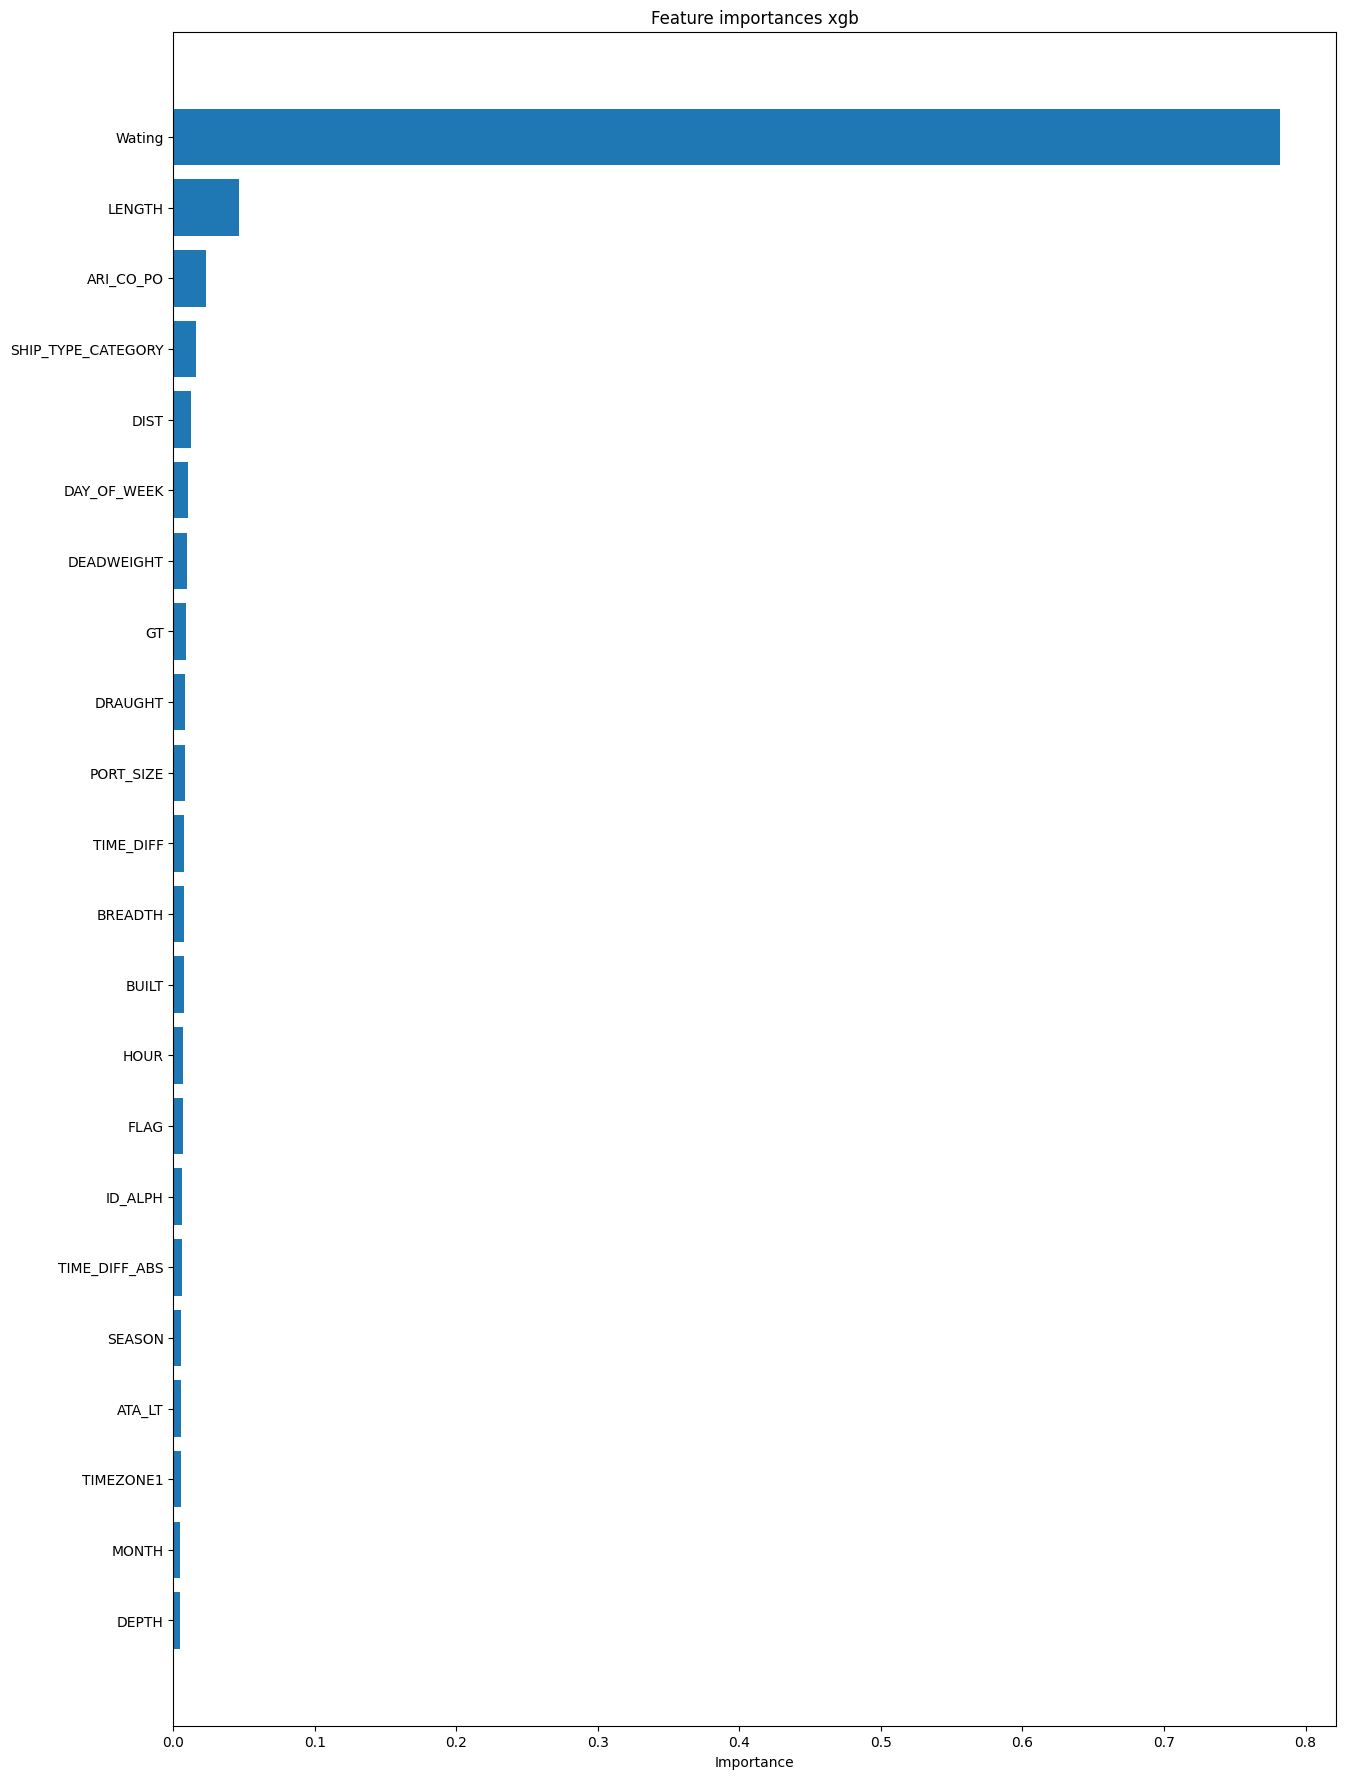

In [ ]:
reg = XGBRegressor(n_jobs=-1, random_state=SEED)
reg = reg.fit(X_train1, y_train1)
feature_importances1 = model_feature_importances(reg, 'xgb', X_train1, y_train1)

In [ ]:
X_train1_importanced = X_train1[X_train1.columns[feature_importances1 > 0]]
X_test1_importanced = X_test1[X_test1.columns[feature_importances1 > 0]]

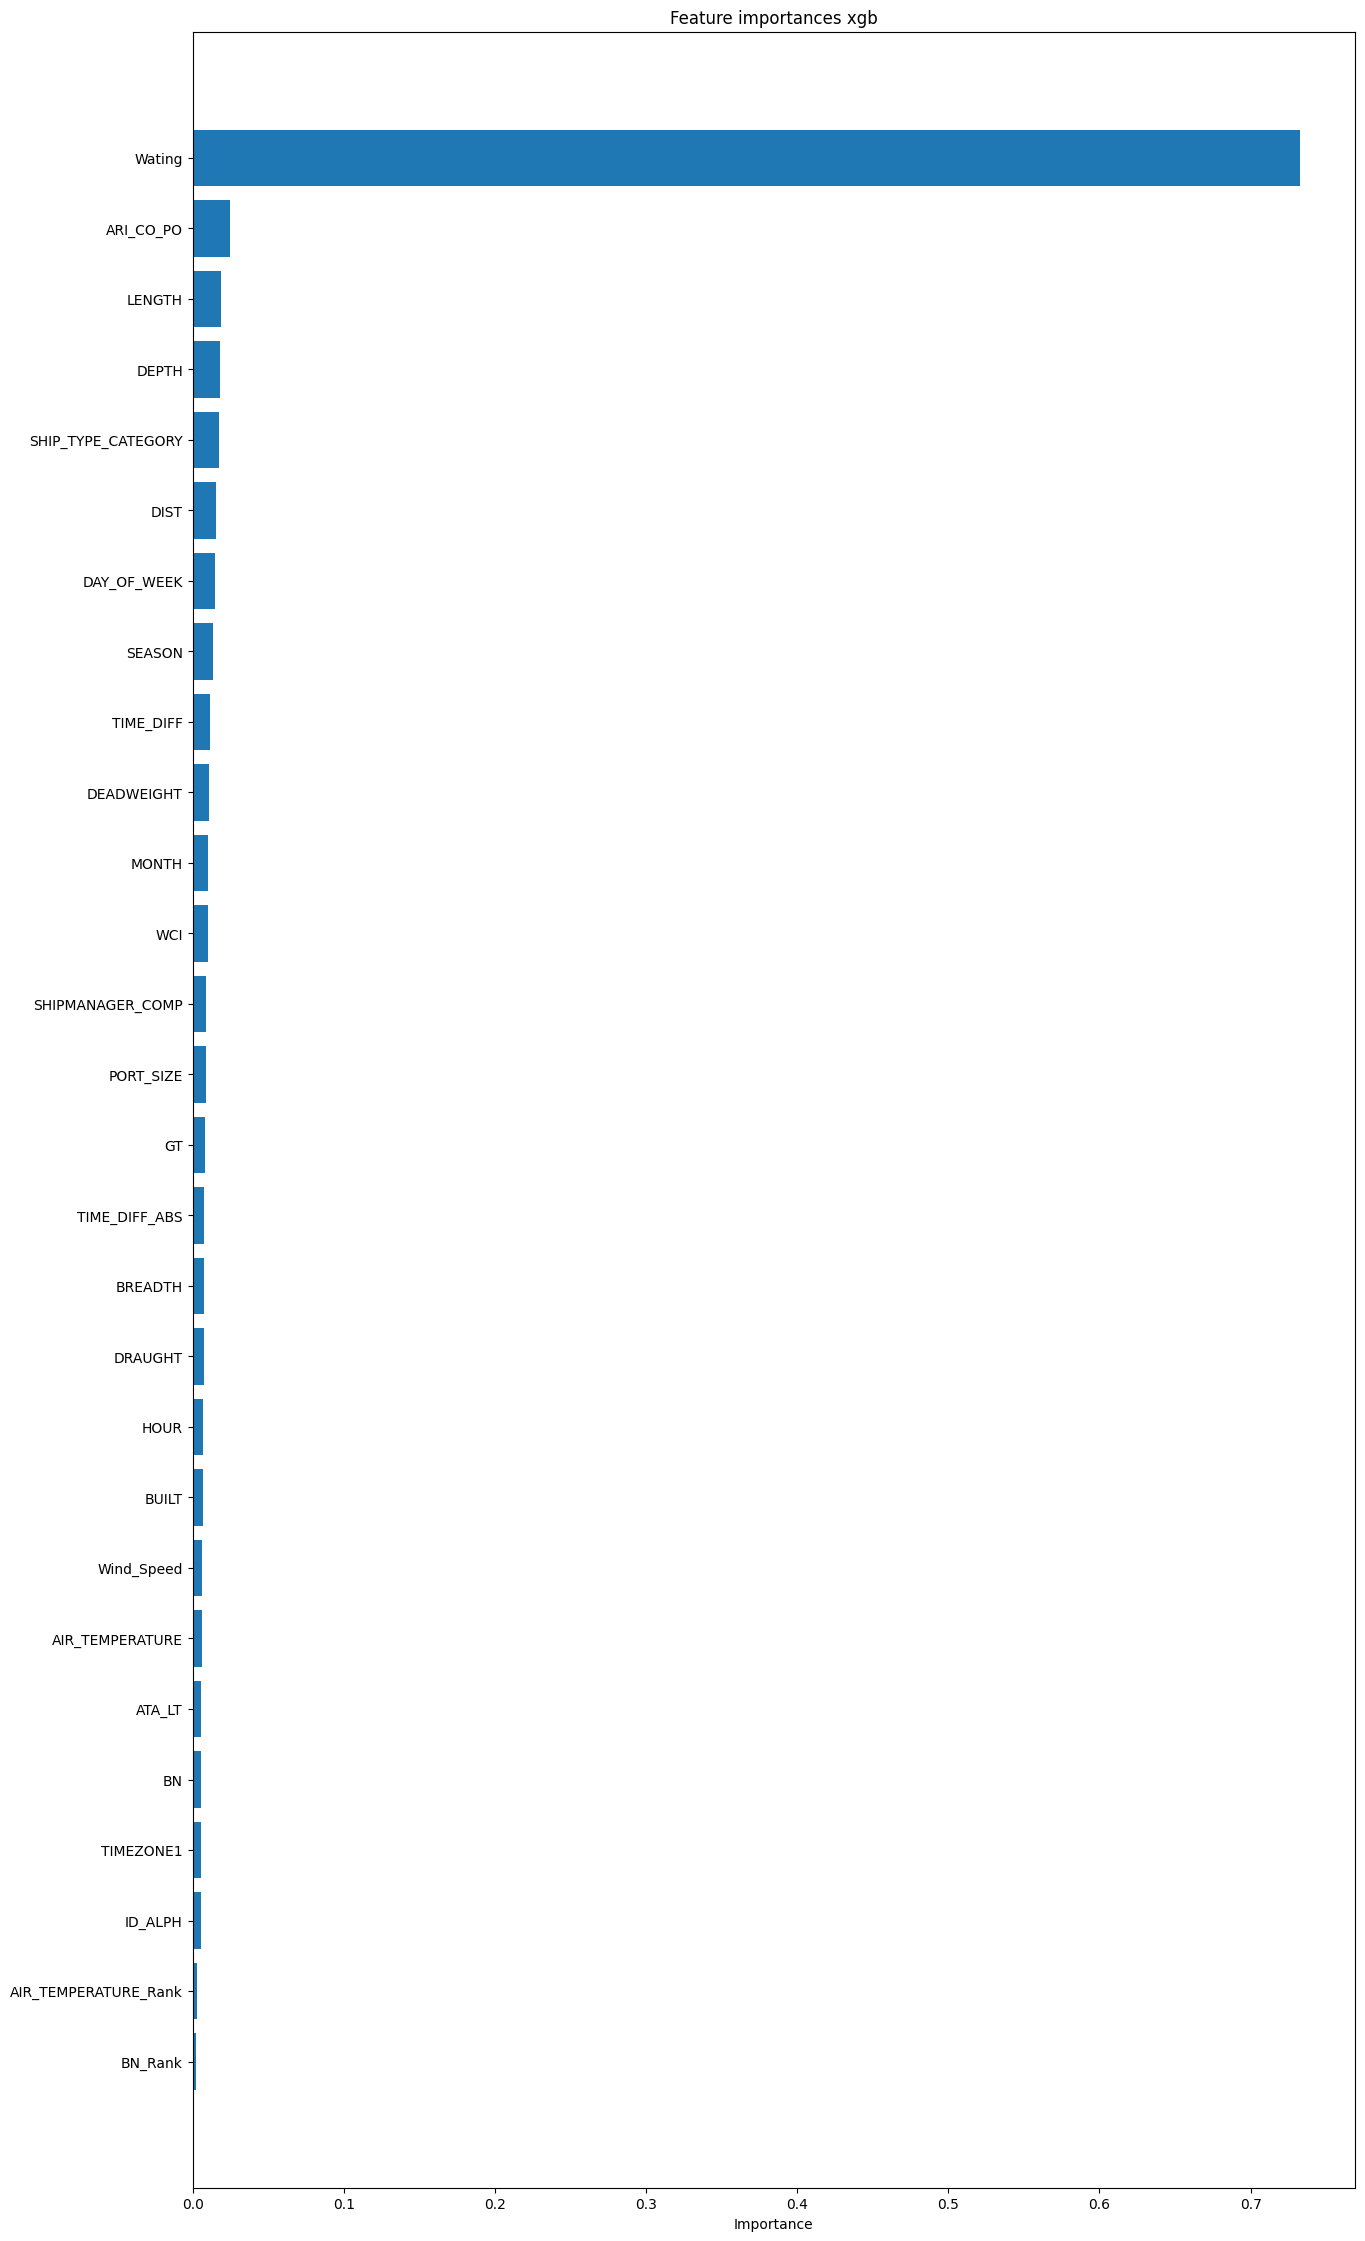

In [ ]:
reg = XGBRegressor(n_jobs=-1, random_state=SEED)
reg = reg.fit(X_train2, y_train2)
feature_importances2 = model_feature_importances(reg, 'xgb', X_train2, y_train2)

In [ ]:
X_train2_importanced = X_train2[X_train2.columns[feature_importances2 > 0]]
X_test2_importanced = X_test2[X_test2.columns[feature_importances2 > 0]]

PolynomialFeatures

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train1_importanced = pd.DataFrame(poly.fit_transform(X_train1_importanced))
X_test1_importanced = pd.DataFrame(poly.transform(X_test1_importanced))

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train2_importanced = pd.DataFrame(poly.fit_transform(X_train2_importanced))
X_test2_importanced = pd.DataFrame(poly.transform(X_test2_importanced))

sample weight

In [ ]:
OLS = sm.OLS(y_train1.values.reshape(-1, 1), X_train1_importanced)
result1 = OLS.fit()
influence1 = OLSInfluence(result1)

In [ ]:
weight1 = (influence1.cooks_distance[0]).to_numpy()
weight1

array([1.29393109e-06, 2.31191618e-08, 1.34007996e-06, ...,
       2.15752302e-07, 1.42413142e-06, 3.13566488e-08])

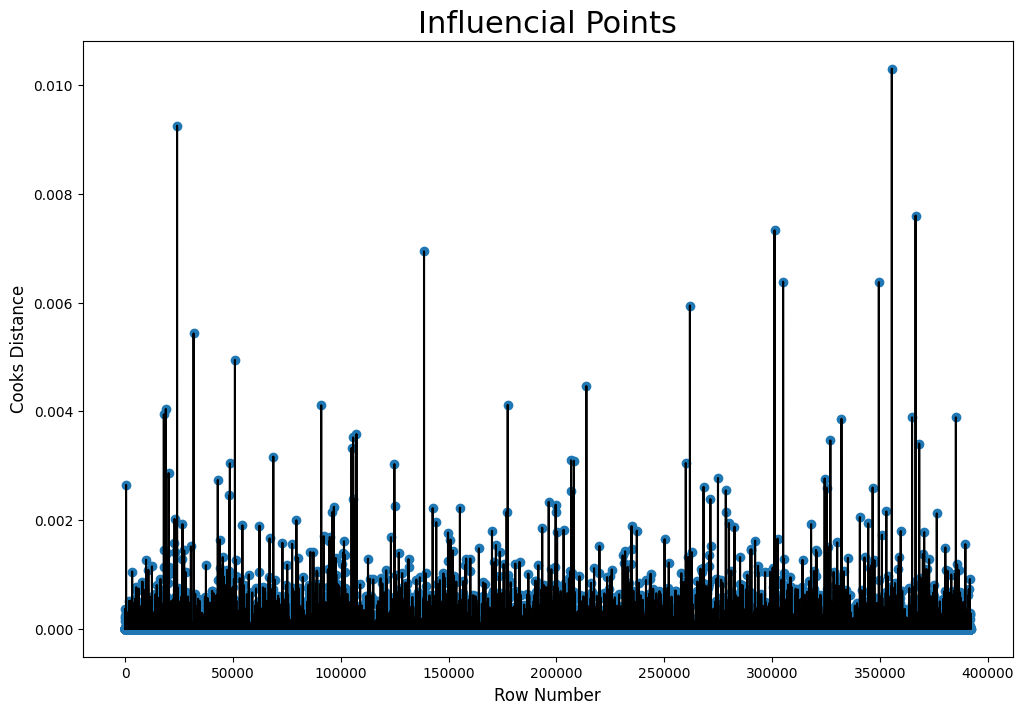

In [ ]:
# Draw plot
plt.figure(figsize = (12, 8))
plt.scatter(y_train1.index, weight1)
plt.plot(y_train1.index, weight1, color='black')
plt.xlabel('Row Number', fontsize = 12)
plt.ylabel('Cooks Distance', fontsize = 12)
plt.title('Influencial Points', fontsize = 22)
plt.show()

In [ ]:
for i in range(len(weight1)):
    if weight1[i] < weight1.mean():
        weight1[i] = 0.3
    elif weight1[i] < 0.0015:
        weight1[i] = 0.2
    else:
        weight1[i] = 0.1

In [ ]:
weight1

array([0.3, 0.3, 0.3, ..., 0.3, 0.3, 0.3])

In [ ]:
OLS = sm.OLS(y_train2.values.reshape(-1, 1), X_train2_importanced)
result2 = OLS.fit()
influence2 = OLSInfluence(result2)

In [ ]:
weight2 = (influence2.cooks_distance[0]).to_numpy()
weight2

array([1.05000648e-08, 5.20158799e-07, 5.59935691e-07, ...,
       1.36903148e-04, 1.67749700e-06, 7.03516309e-06])

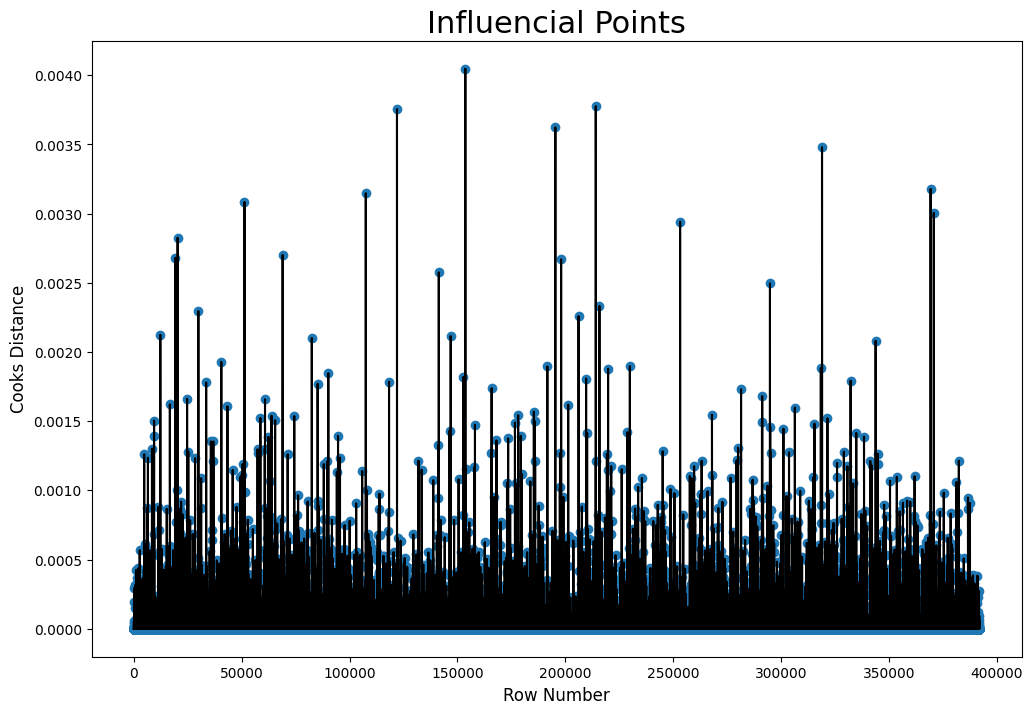

In [ ]:
# Draw plot
plt.figure(figsize = (12, 8))
plt.scatter(y_train2.index, weight2)
plt.plot(y_train2.index, weight2, color='black')
plt.xlabel('Row Number', fontsize = 12)
plt.ylabel('Cooks Distance', fontsize = 12)
plt.title('Influencial Points', fontsize = 22)
plt.show()

In [ ]:
for i in range(len(weight2)):
    if weight2[i] < weight2.mean():
        weight2[i] = 0.3
    elif weight2[i] < 0.00055:
        weight2[i] = 0.2
    else:
        weight2[i] = 0.1

In [ ]:
weight2

array([0.3, 0.3, 0.3, ..., 0.3, 0.3, 0.3])

In [ ]:
class TensorData(Dataset):
  def __init__(self, X, y = None):
    self.X = torch.FloatTensor(X)
    if y is not None:
      self.y = torch.FloatTensor(y)
    else:
      self.y = None

  def __getitem__(self, index):
    if self.y is not None:
      return self.X[index], self.y[index]
    else:
      return self.X[index]

  def __len__(self):
    return len(self.y)

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, X_catetorical, X_continous, y = None):
    self.X_categorical = torch.LongTensor(X_catetorical.values)
    self.X_continous = torch.FloatTensor(X_continous.values)
    if y is not None:
      self.y = torch.FloatTensor(y.values)
    else:
      self.y = None

  def __getitem__(self, idx):
    if self.y is not None:
      return self.X_categorical[idx], self.X_continous[idx], self.y[idx]
    else:
      return self.X_categorical[idx], self.X_continous[idx]

  def __len__(self):
    if self.y is not None:
        return len(self.y)
    else:
        return len(self.X_categorical)

In [ ]:
# CNN
class DCNNRegressor(nn.Module):
  def __init__(self, batch_size, inputs, outputs):
    super(DCNNRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs
    self.input_layer = nn.Conv1d(inputs, batch_size, 1, stride = 1)
    self.max_pooling_layer = nn.MaxPool1d(1)
    self.conv_layer1 = nn.Conv1d(batch_size, 128, 1, stride = 3)
    self.conv_layer2 = nn.Conv1d(128, 256, 1, stride = 3)
    self.conv_layer3 = nn.Conv1d(256, 512, 1, stride = 3)
    self.flatten_layer = nn.Flatten()
    self.linear_layer = nn.Linear(512, 128)
    self.output_layer = nn.Linear(128, outputs)

  def forward(self, input):
    input = input.reshape((self.batch_size, self.inputs, 1))

    output = nn.functional.relu(self.input_layer(input))

    output = self.max_pooling_layer(output)
    output = nn.functional.relu(self.conv_layer1(output))

    output = self.max_pooling_layer(output)
    output = nn.functional.relu(self.conv_layer2(output))

    output = self.max_pooling_layer(output)
    output = nn.functional.relu(self.conv_layer3(output))

    output = self.flatten_layer(output)

    output = nn.functional.relu(self.linear_layer(output))

    output = self.output_layer(output)
    return output

class CNNRegressor(nn.Module):
    def __init__(self, input_dim):
        super(CNNRegressor, self).__init__()
        self.input_dim = input_dim
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.pool = nn.MaxPool1d(kernel_size=1)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.batch_norm1(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.batch_norm2(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class Regressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100, 25)
        self.fc4 = nn.Linear(25, 1)
        #self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        #x = self.dropout(F.relu(self.fc2(x)))
        return x

In [ ]:
needlabeling = list(X_train1_importanced.columns[1:])
for col in needlabeling:
  if col in categorical_cols:
    print(col)
    le = LabelEncoder()
    X_train1_importanced[col] = le.fit_transform(X_train1_importanced[col])
    X_train1_importanced[col] = X_train1_importanced[col] + 1
    X_test1_importanced[col] = le.transform(X_test1_importanced[col])
    X_test1_importanced[col] = X_test1_importanced[col] + 1
    print(f'{col} apply binary encoding..')

ID_ALPH
ID_ALPH apply binary encoding..
Wating
Wating apply binary encoding..
YEAR
YEAR apply binary encoding..
MONTH
MONTH apply binary encoding..
DAY_OF_WEEK
DAY_OF_WEEK apply binary encoding..
HOUR
HOUR apply binary encoding..
TIMEZONE1
TIMEZONE1 apply binary encoding..
SEASON
SEASON apply binary encoding..
CLUSTER
CLUSTER apply binary encoding..


In [ ]:
needlabeling = list(X_train2_importanced.columns[1:])
for col in needlabeling:
  if col in categorical_cols:
    print(col)
    le = LabelEncoder()
    X_train2_importanced[col] = le.fit_transform(X_train2_importanced[col])
    X_train2_importanced[col] = X_train2_importanced[col] + 1
    X_test2_importanced[col] = le.transform(X_test2_importanced[col])
    X_test2_importanced[col] = X_test2_importanced[col] + 1
    print(f'{col} apply binary encoding..')

ID_ALPH
ID_ALPH apply binary encoding..
Wating
Wating apply binary encoding..
YEAR
YEAR apply binary encoding..
MONTH
MONTH apply binary encoding..
DAY_OF_WEEK
DAY_OF_WEEK apply binary encoding..
HOUR
HOUR apply binary encoding..
TIMEZONE1
TIMEZONE1 apply binary encoding..
SEASON
SEASON apply binary encoding..
BN_Rank
BN_Rank apply binary encoding..
AIR_TEMPERATURE_Rank
AIR_TEMPERATURE_Rank apply binary encoding..
CLUSTER
CLUSTER apply binary encoding..


In [ ]:
# # 인코딩

# needlabeling = list(train.columns[1:])
# rank_variable = ['BN_Rank', 'AIR_TEMPERATURE_Rank', 'TIME_DIFF']
# for col in needlabeling:
#   # 순서형 변수 - ordinal encoding 0 ~ ?
#   if col in rank_variable:
#     le = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
#     le.fit(np.array(train[col]).reshape(-1, 1))
#     train[col] = le.transform(np.array(train[col]).reshape(-1, 1))
#     test[col] = le.transform(np.array(test[col]).reshape(-1, 1))
#     print(f'{col} apply label encoding..')

#   # 명목형 변수 - label encoding 1 ~ ?, one-hot encoding, binary encoding, target encoding, Frequency encoding
#   elif col in ['ID_ALPH', 'SHIPMANAGER_COMP', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'TIME_DIFF_ABS', 'TIMEZONE1', 'TIMEZONE2', 'SEASON', 'Wating', 'HOLIDAY', 'Wind_Direction']:
#     le = LabelEncoder()
#     train[col] = le.fit_transform(train[col])
#     train[col] = train[col]
#     test[col] = le.transform(test[col])
#     test[col] = test[col]
#     print(f'{col} apply binary encoding..')

In [ ]:
# # Embedding

# class CNNRegressorWithEmbedding(nn.Module):
#   def __init__(self, embedding_sizes, continous_dim, hidden_dim):
#     super(CNNRegressorWithEmbedding, self).__init__()

#     # 임베딩 레이어 정의
#     self.embeddings = nn.ModuleList([nn.Embedding(embedding_size, int(embedding_size ** 0.25)) for embedding_size in embedding_sizes])

#     # 합친 임베딩 레이어 출력의 차원 계산
#     embedding_dim = sum([int(embedding_size ** 0.25) for embedding_size in embedding_sizes])

#     # 신경망의 입력 차원
#     input_dim = embedding_dim + continous_dim

#     # 신경망 정의
#     self.cnn = nn.Sequential(
#         nn.Conv1d(in_channels = input_dim, out_channels = hidden_dim, kernel_size = 3),
#         nn.ReLU(),
#         nn.MaxPool1d(2),
#         nn.Flatten(),
#         nn.Linear(hidden_dim, 1)
#     )

#   def forward(self, categorical_data, continous_data):
#     # 임베딩 레이어 적용
#     embeddings = [embedding(categorical_data[:, i]) for i, embedding in enumerate(self.embeddings)]
#     embedded_x = torch.cat(embeddings, dim = 1)

#     # 임베딩된 특성과 연속형 데이터를 합침
#     x = torch.cat([embedded_x, continous_data], dim = 1)

#     # CNN 레이어 전달
#     x = self.cnn(x)

#     return x

class CNNRegressorWithEmbedding(nn.Module):
  def __init__(self, embedding_sizes, continous_dim):
    super(CNNRegressorWithEmbedding, self).__init__()
    self.embeddings = nn.ModuleList([nn.Embedding(num_classes, embedding_dim) for num_classes, embedding_dim in embedding_sizes])
    self.continous_dim = continous_dim
    self.conv1 = nn.Conv1d(sum(embedding_dim for _, embedding_dim in embedding_sizes) + continous_dim, 64, kernel_size = 1)
    self.fc1 = nn.Linear(64, 32)
    self.fc2 = nn.Linear(32, 1)

  def forward(self, x_categorical, x_continous):
    embeddings_x = [emb(x_categorical[:, i]) for i, emb in enumerate(self.embeddings)]
    embeddings_x = torch.cat(embeddings_x, dim = 1)
    x = torch.cat([embeddings_x, x_continous], dim = 1)
    x = x.unsqueeze(1)
    x = x.permute(0, 2, 1)
    x = torch.relu(self.conv1(x))
    x = x.max(dim=2)[0]
    x = torch.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
# def z_score_normalization(data):
#     mean = data.mean(axis=0)
#     std = data.std(axis=0)
#     normalized_data = (data - mean) / std
#     return normalized_data

# # X_train1_importanced = z_score_normalization(X_train1_importanced)
# # X_test1_importanced = z_score_normalization(X_test1_importanced)

# X_train1_importanced = torch.Tensor(X_train1_importanced.values)
# X_test1_importanced = torch.Tensor(X_test1_importanced.values)

# y_train1 = torch.Tensor(y_train1.values)

Embedding factor

In [ ]:
X_train1_categorical_cols = [col for col in X_train1_importanced.columns if col in categorical_cols]
X_train1_continous_cols = [col for col in X_train1_importanced.columns if col in continous_cols]

In [ ]:
embedding_sizes1 = {}
for col in X_train1_categorical_cols:
  num_unique = X_train1_importanced[col].nunique()
  embedding_size = min(50, num_unique // 2 + 1)
  embedding_sizes1[col] = (num_unique+1, embedding_size)

In [ ]:
embedding_sizes1

{'SHIP_TYPE_CATEGORY': (5, 3),
 'ID_ALPH': (27, 14),
 'Wating': (3, 2),
 'YEAR': (6, 3),
 'MONTH': (13, 7),
 'DAY_OF_WEEK': (8, 4),
 'HOUR': (25, 13),
 'TIMEZONE1': (7, 4),
 'SEASON': (5, 3),
 'CLUSTER': (21, 11)}

In [ ]:
X_train2_categorical_cols = [col for col in X_train2_importanced.columns if col in categorical_cols]
X_train2_continous_cols = [col for col in X_train2_importanced.columns if col in continous_cols]

In [ ]:
embedding_sizes2 = {}
for col in X_train2_categorical_cols:
  num_unique = X_train2_importanced[col].nunique()
  embedding_size = min(50, num_unique // 2 + 1)
  embedding_sizes2[col] = (num_unique+1, embedding_size)

In [ ]:
embedding_sizes2

{'ID_ALPH': (27, 14),
 'Wating': (3, 2),
 'YEAR': (6, 3),
 'MONTH': (13, 7),
 'DAY_OF_WEEK': (8, 4),
 'HOUR': (25, 13),
 'TIMEZONE1': (7, 4),
 'SEASON': (5, 3),
 'BN_Rank': (8, 4),
 'AIR_TEMPERATURE_Rank': (8, 4),
 'CLUSTER': (21, 11)}

In [ ]:
# a = nn.ModuleList([nn.Embedding(num_classes, embedding_dim) for num_classes, embedding_dim in list(embedding_sizes1.values())])
# #[emb(categorical_inputs[:, i]) for i, emb in enumerate(a)]
# for i, emb in enumerate(a):
#   print(categorical_inputs[:, i])
#   print(emb)
#   embeddings_x = [emb(categorical_inputs[:, i])]
#   embeddings_x = torch.cat(embeddings_x, dim = 1)
#   print(embeddings_x.shape)

In [ ]:
# a = nn.ModuleList([nn.Embedding(num_classes, embedding_dim) for num_classes, embedding_dim in list(embedding_sizes2.values())])
# #[emb(categorical_inputs[:, i]) for i, emb in enumerate(a)]
# for i, emb in enumerate(a):
#   print(categorical_inputs[:, i])
#   print(emb)
#   embeddings_x = [emb(categorical_inputs[:, i])]
#   embeddings_x = torch.cat(embeddings_x, dim = 1)
#   print(embeddings_x.shape)

In [ ]:
# max_allowed_value = np.array(y_train1).flatten().astype('float64')[~np.isinf(np.array(y_train1).flatten().astype('float64'))].max()
# max_allowed_value

In [ ]:
#kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED)
kf = KFold(n_splits = 5, shuffle = True)

ensemble_predictions1 = []
scores1 = []
num_epochs = 50 # 10 20 50 100

#y_train1 = np.log1p(y_train1)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train1_importanced)):
  X_train, X_val = X_train1_importanced.iloc[train_idx], X_train1_importanced.iloc[val_idx]
  y_train, y_val = y_train1.iloc[train_idx], y_train1.iloc[val_idx]

  #train_dataset = TensorData(X_train, y_train)
  #val_dataset = TensorData(X_val, y_val)
  train_dataset = CustomDataset(X_train[X_train1_categorical_cols], X_train[X_train1_continous_cols], y_train)
  val_dataset = CustomDataset(X_val[X_train1_categorical_cols], X_val[X_train1_continous_cols], y_val)

  batch_size = 64
  file_path = f'/content/fold{fold+1}_cnn1.pth'

  train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
  val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

  num_continous_features = len(X_train1_continous_cols)

  #model = Regressor(X_train.shape[1])
  #model = DCNNRegressor(batch_size, X_train.shape[1], 1)
  #model = CNNRegressor(X_train.shape[1])
  model = CNNRegressorWithEmbedding(embedding_sizes1.values(), num_continous_features)
  optimizer = optim.Adam(model.parameters(), lr=0.0001)
  #optimizer = optim.SGD(model.parameters(), lr=0.0001)
  #criterion = nn.L1Loss()
  criterion = nn.MSELoss()
  #scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

  best_model = None
  best_mae = float('inf')

  for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
      categorical_inputs, continous_inputs, targets = batch
      #print(categorical_inputs.shape, continous_inputs.shape, targets.shape)
      #categorical_inputs = [torch.Tensor([value - 1 for value in index]) for index in categorical_inputs]
      #categorical_inputs = torch.cat(categorical_inputs, dim = 0)
      #inputs = inputs.view(inputs.size(0), inputs.size(1), 1)

      optimizer.zero_grad()
      outputs = model(categorical_inputs, continous_inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

    model.eval()
    total_loss = 0.0
    val_preds = []
    with torch.no_grad():
      for batch in val_loader:
        categorical_inputs, continous_inputs, targets = batch
        #inputs = inputs.view(inputs.size(0), inputs.size(1), 1)
        outputs = model(categorical_inputs, continous_inputs)
        val_preds.extend(outputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

    average_loss = total_loss / len(val_loader)

    val_preds = np.array(val_preds)
    #y_val = np.expm1(y_val)
    #val_preds = np.expm1(val_preds)
    # max_allowed_value = np.array(val_preds).flatten().astype('float64')[~np.isinf(np.array(val_preds).flatten().astype('float64'))].max()
    #val_preds = np.clip(val_preds, a_min=None, a_max=max_allowed_value)
    val_preds = np.where(val_preds < 0, 0, val_preds)
    mae = mean_absolute_error(y_val, val_preds)
    scores1.append(mae)

    if scheduler is not None:
      scheduler.step(mae)

    if mae < best_mae:
      best_mae = mae
      best_model = model.state_dict()
      torch.save(best_model, f'{file_path}')
      print('--- --- --- Best update --- --- ---')
      print(f'Epoch: [{epoch + 1}/{num_epochs}] Average Loss: [{average_loss}] MAE Score: [{mae}]')

    print(f'Epoch: [{epoch + 1}/{num_epochs}] Average Loss: [{average_loss}] MAE Score: [{mae}]')

--- --- --- Best update --- --- ---
Epoch: [1/50] Average Loss: [27781.4102824134] MAE Score: [75.07773423622463]
Epoch: [1/50] Average Loss: [27781.4102824134] MAE Score: [75.07773423622463]
Epoch: [2/50] Average Loss: [27762.446453749075] MAE Score: [75.3903632657721]
Epoch: [3/50] Average Loss: [27753.553323298045] MAE Score: [75.50777931450303]
Epoch: [4/50] Average Loss: [27747.82868936452] MAE Score: [75.59234215440341]


KeyboardInterrupt: ignored

In [ ]:
#test_dataset = TensorData(torch.Tensor(X_test1_importanced))
test_dataset = CustomDataset(X_test1_importanced[X_train1_categorical_cols], X_test1_importanced[X_train1_continous_cols])
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
pred1 = []
with torch.no_grad():
  for batch in test_loader:
    categorical_inputs, continous_inputs = batch
    #inputs = inputs.view(inputs.size(0), inputs.size(1), 1)
    outputs = model(categorical_inputs, continous_inputs)
    pred1.extend(outputs.numpy())

pred1 = np.array(pred1)
#pred1 = np.expm1(pred1)
#pred1 = np.clip(pred1, a_min=None, a_max=max_allowed_value)
pred1 = np.where(pred1 < 0, 0, pred1)
ensemble_predictions1.append(pred1)

final_predictions1 = np.mean(ensemble_predictions1, axis = 0)

In [ ]:
final_predictions1

In [ ]:
#kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED)
kf = KFold(n_splits = 5, shuffle = True)

ensemble_predictions2 = []
scores2 = []
num_epochs = 50 # 10 20 50 100

#y_train1 = np.log1p(y_train1)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train2_importanced)):
  X_train, X_val = X_train2_importanced.iloc[train_idx], X_train2_importanced.iloc[val_idx]
  y_train, y_val = y_train2.iloc[train_idx], y_train2.iloc[val_idx]

  #train_dataset = TensorData(X_train, y_train)
  #val_dataset = TensorData(X_val, y_val)
  train_dataset = CustomDataset(X_train[X_train2_categorical_cols], X_train[X_train2_continous_cols], y_train)
  val_dataset = CustomDataset(X_val[X_train2_categorical_cols], X_val[X_train2_continous_cols], y_val)

  batch_size = 64
  file_path = f'/content/fold{fold+1}_cnn2.pth'

  train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
  val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

  num_continous_features = len(X_train2_continous_cols)

  #model = Regressor(X_train.shape[1])
  #model = DCNNRegressor(batch_size, X_train.shape[1], 1)
  #model = CNNRegressor(X_train.shape[1])
  model = CNNRegressorWithEmbedding(embedding_sizes2.values(), num_continous_features)
  optimizer = optim.Adam(model.parameters(), lr=0.0001)
  #optimizer = optim.SGD(model.parameters(), lr=0.0001)
  criterion = nn.MSELoss()
  #scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

  best_model = None
  best_mae = float('inf')

  for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
      categorical_inputs, continous_inputs, targets = batch
      #print(categorical_inputs.shape, continous_inputs.shape, targets.shape)

      #categorical_inputs = [torch.Tensor([value - 1 for value in index]) for index in categorical_inputs]
      #categorical_inputs = torch.cat(categorical_inputs, dim = 0)
      #inputs = inputs.view(inputs.size(0), inputs.size(1), 1)

      optimizer.zero_grad()
      outputs = model(categorical_inputs, continous_inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

    model.eval()
    total_loss = 0.0
    val_preds = []
    with torch.no_grad():
      for batch in val_loader:
        categorical_inputs, continous_inputs, targets = batch
        #inputs = inputs.view(inputs.size(0), inputs.size(1), 1)
        outputs = model(categorical_inputs, continous_inputs)
        val_preds.extend(outputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

    average_loss = total_loss / len(val_loader)

    val_preds = np.array(val_preds)
    #y_val = np.expm1(y_val)
    #val_preds = np.expm1(val_preds)
    # max_allowed_value = np.array(val_preds).flatten().astype('float64')[~np.isinf(np.array(val_preds).flatten().astype('float64'))].max()
    #val_preds = np.clip(val_preds, a_min=None, a_max=max_allowed_value)
    val_preds = np.where(val_preds < 0, 0, val_preds)
    mae = mean_absolute_error(y_val, val_preds)
    scores2.append(mae)

    if mae < best_mae:
      best_mae = mae
      best_model = model.state_dict()
      torch.save(best_model, f'{file_path}')
      print('--- --- --- Best update --- --- ---')
      print(f'Epoch: [{epoch + 1}/{num_epochs}] Average Loss: [{average_loss}] MAE Score: [{mae}]')

    print(f'Epoch: [{epoch + 1}/{num_epochs}] Average Loss: [{average_loss}] MAE Score: [{mae}]')

    if scheduler is not None:
      scheduler.step(mae)

In [ ]:
#test_dataset = TensorData(torch.Tensor(X_test1_importanced))
test_dataset = CustomDataset(X_test2_importanced[X_train2_categorical_cols], X_test2_importanced[X_train2_continous_cols])
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
pred2 = []
with torch.no_grad():
  for batch in test_loader:
    categorical_inputs, continous_inputs = batch
    #inputs = inputs.view(inputs.size(0), inputs.size(1), 1)
    outputs = model(categorical_inputs, continous_inputs)
    pred2.extend(outputs.numpy())

pred2 = np.array(pred2)
#pred1 = np.expm1(pred1)
#pred1 = np.clip(pred1, a_min=None, a_max=max_allowed_value)
pred2 = np.where(pred2 < 0, 0, pred2)
ensemble_predictions2.append(pred2)

final_predictions2 = np.mean(ensemble_predictions2, axis = 0)

In [ ]:
final_predictions2

XGB Hyperparameter for optuna

In [ ]:
#X_train1[X_train1.isin([np.inf, -np.inf]).any(axis=1)]

In [ ]:
#y_train1[y_train1.isin([np.inf, -np.inf])]

In [ ]:
y_train2 = np.log1p(y_train2)

In [ ]:
def objective(trial):
  # params = {
  #     "n_estimators": 2000,
  #     "subsample": trial.suggest_discrete_uniform("subsample",0.6,1,0.1),
  #     "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree",0.6,1,0.1),
  #     "eta": trial.suggest_loguniform("eta",1e-3,0.1),
  #     'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.2),
  #     'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
  #     'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
  #     "max_depth": trial.suggest_int("max_depth",1,11),
  #     "min_child_weight": trial.suggest_int("min_child_weight",1,300),
  #     "tree_method": 'gpu_hist'
  # }

  params = {
      "n_estimators": trial.suggest_int("n_estimators", 1000, 5000, step = 100),
      "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
      "max_depth": trial.suggest_int("max_depth", 1,15),
      'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
      "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
      "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
      "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.9, step=0.1),
      "random_state": SEED,
    }

  scores = []
  kf = KFold(n_splits = 10, shuffle = True, random_state = SEED)

  for fold, (train_idx, val_idx) in enumerate(kf.split(X_train2_importanced)):
    X_train, X_val = X_train2_importanced.iloc[train_idx], X_train2_importanced.iloc[val_idx]
    y_train, y_val = y_train2.iloc[train_idx], y_train2.iloc[val_idx]

    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)], early_stopping_rounds = 100, verbose = 0)

    val_pred = model.predict(X_val)
    val_pred = np.expm1(val_pred)
    val_pred = np.where(val_pred < 0, 0, val_pred)

    mae = mean_absolute_error(y_val, val_pred)
    scores.append(mae)
    print(f'FOLD: {fold+1}, MAE: {mae}')

  print(f'Trial done: average mean on folds: {np.mean(scores)}')
  return np.mean(scores)

In [ ]:
n_trials = 20
tpesampler = TPESampler(seed = SEED)

FIT_XGB = True

if FIT_XGB:
    study = optuna.create_study(direction="minimize",study_name = 'XGB', sampler = tpesampler)
    study.optimize(objective, n_trials=n_trials)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-10-25 03:26:22,724] A new study created in memory with name: XGB


FOLD: 1, MAE: 32.70569221145707
FOLD: 2, MAE: 32.207168445233116
FOLD: 3, MAE: 32.119356097941456
FOLD: 4, MAE: 32.4480190074427
FOLD: 5, MAE: 32.60553618605594
FOLD: 6, MAE: 31.7409752810985
FOLD: 7, MAE: 32.5338621709875
FOLD: 8, MAE: 32.068650689244606
FOLD: 9, MAE: 32.056411339205205


[I 2023-10-25 03:49:01,526] Trial 0 finished with value: 32.20315847132276 and parameters: {'n_estimators': 2000, 'learning_rate': 0.005563486246588564, 'max_depth': 11, 'min_child_weight': 14, 'lambda_l1': 10, 'lambda_l2': 60, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 32.20315847132276.


FOLD: 10, MAE: 31.545913284561436
Trial done: average mean on folds: 32.20315847132276
FOLD: 1, MAE: 33.670458514947775
FOLD: 2, MAE: 33.19360972106912
FOLD: 3, MAE: 33.477026480432244
FOLD: 4, MAE: 33.93110183273601
FOLD: 5, MAE: 33.65634479848314
FOLD: 6, MAE: 32.57317463959676
FOLD: 7, MAE: 32.95358941295497
FOLD: 8, MAE: 32.734229848047754
FOLD: 9, MAE: 33.65618776518358


[I 2023-10-25 03:55:17,774] Trial 1 finished with value: 33.29965560207223 and parameters: {'n_estimators': 3700, 'learning_rate': 0.09182733703821878, 'max_depth': 7, 'min_child_weight': 100, 'lambda_l1': 25, 'lambda_l2': 15, 'feature_fraction': 0.4}. Best is trial 0 with value: 32.20315847132276.


FOLD: 10, MAE: 33.15083300727094
Trial done: average mean on folds: 33.29965560207223
FOLD: 1, MAE: 32.790294923849345
FOLD: 2, MAE: 32.37590229596313
FOLD: 3, MAE: 32.4620972586452
FOLD: 4, MAE: 32.7930828032874
FOLD: 5, MAE: 32.83933023374705
FOLD: 6, MAE: 31.843144493829055
FOLD: 7, MAE: 32.900904598871186
FOLD: 8, MAE: 32.05736819518703
FOLD: 9, MAE: 32.3065481923864


[I 2023-10-25 04:18:57,812] Trial 2 finished with value: 32.41659885895129 and parameters: {'n_estimators': 2900, 'learning_rate': 0.007882526313348943, 'max_depth': 11, 'min_child_weight': 95, 'lambda_l1': 75, 'lambda_l2': 40, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 32.20315847132276.


FOLD: 10, MAE: 31.797315593747026
Trial done: average mean on folds: 32.41659885895129
FOLD: 1, MAE: 33.75920898973842
FOLD: 2, MAE: 33.0089062509072
FOLD: 3, MAE: 33.33328568645035
FOLD: 4, MAE: 33.41446115983505
FOLD: 5, MAE: 33.57298833413248
FOLD: 6, MAE: 32.550348641289155
FOLD: 7, MAE: 33.06890410585404
FOLD: 8, MAE: 33.48522425170151
FOLD: 9, MAE: 33.56386651454192


[I 2023-10-25 04:34:57,927] Trial 3 finished with value: 33.2472062323121 and parameters: {'n_estimators': 3900, 'learning_rate': 0.04275404571907904, 'max_depth': 6, 'min_child_weight': 70, 'lambda_l1': 45, 'lambda_l2': 35, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 32.20315847132276.


FOLD: 10, MAE: 32.714868388670865
Trial done: average mean on folds: 33.2472062323121
FOLD: 1, MAE: 28.692318304371824
FOLD: 2, MAE: 28.976804909614835
FOLD: 3, MAE: 28.795946316090905
FOLD: 4, MAE: 28.89780102100105
FOLD: 5, MAE: 29.195760658571317
FOLD: 6, MAE: 28.57730469764962
FOLD: 7, MAE: 28.73455061393508
FOLD: 8, MAE: 28.30895901690023
FOLD: 9, MAE: 28.246114406485944


[I 2023-10-25 04:40:39,653] Trial 4 finished with value: 28.656572249578534 and parameters: {'n_estimators': 1400, 'learning_rate': 0.07439383659278212, 'max_depth': 2, 'min_child_weight': 38, 'lambda_l1': 30, 'lambda_l2': 65, 'feature_fraction': 0.9}. Best is trial 4 with value: 28.656572249578534.


FOLD: 10, MAE: 28.140162551164494
Trial done: average mean on folds: 28.656572249578534
FOLD: 1, MAE: 33.47730667592489
FOLD: 2, MAE: 32.993859081103984
FOLD: 3, MAE: 33.52383804878178
FOLD: 4, MAE: 33.74612075526944
FOLD: 5, MAE: 33.717345446510905
FOLD: 6, MAE: 32.054960386630974
FOLD: 7, MAE: 33.635137323686706
FOLD: 8, MAE: 32.51438186849756
FOLD: 9, MAE: 33.47378795190528


[I 2023-10-25 04:47:37,201] Trial 5 finished with value: 33.12465790997193 and parameters: {'n_estimators': 2100, 'learning_rate': 0.05864024017483205, 'max_depth': 14, 'min_child_weight': 237, 'lambda_l1': 20, 'lambda_l2': 35, 'feature_fraction': 0.7}. Best is trial 4 with value: 28.656572249578534.


FOLD: 10, MAE: 32.10984156140774
Trial done: average mean on folds: 33.12465790997193
FOLD: 1, MAE: 31.251685771093907
FOLD: 2, MAE: 31.23812688926741
FOLD: 3, MAE: 31.35181385070815
FOLD: 4, MAE: 31.63025662152904
FOLD: 5, MAE: 31.970366534681812
FOLD: 6, MAE: 30.681799416269666
FOLD: 7, MAE: 31.371876553190575
FOLD: 8, MAE: 30.93605102808009
FOLD: 9, MAE: 30.751195103377224


[I 2023-10-25 04:57:46,033] Trial 6 finished with value: 31.168879602431296 and parameters: {'n_estimators': 2400, 'learning_rate': 0.04660774615852524, 'max_depth': 4, 'min_child_weight': 85, 'lambda_l1': 85, 'lambda_l2': 90, 'feature_fraction': 0.30000000000000004}. Best is trial 4 with value: 28.656572249578534.


FOLD: 10, MAE: 30.505624256115144
Trial done: average mean on folds: 31.168879602431296
FOLD: 1, MAE: 34.03549301306663
FOLD: 2, MAE: 32.866733875018404
FOLD: 3, MAE: 33.54930948735597
FOLD: 4, MAE: 33.93094881723539
FOLD: 5, MAE: 34.12773361975008
FOLD: 6, MAE: 32.47158239243438
FOLD: 7, MAE: 33.497245054354416
FOLD: 8, MAE: 32.677586224599544
FOLD: 9, MAE: 33.14564098561927


[I 2023-10-25 05:05:18,941] Trial 7 finished with value: 33.33200193417609 and parameters: {'n_estimators': 2100, 'learning_rate': 0.052991745489794795, 'max_depth': 14, 'min_child_weight': 181, 'lambda_l1': 70, 'lambda_l2': 25, 'feature_fraction': 0.4}. Best is trial 4 with value: 28.656572249578534.


FOLD: 10, MAE: 33.017745872326856
Trial done: average mean on folds: 33.33200193417609
FOLD: 1, MAE: 33.94398364183185
FOLD: 2, MAE: 33.20574685140451
FOLD: 3, MAE: 33.003381345257075
FOLD: 4, MAE: 33.34153299376269
FOLD: 5, MAE: 33.74739551820545
FOLD: 6, MAE: 32.57528196058684
FOLD: 7, MAE: 33.524952997294236
FOLD: 8, MAE: 32.696137682780304
FOLD: 9, MAE: 33.56873230931248


[I 2023-10-25 05:11:23,592] Trial 8 finished with value: 33.26099742837762 and parameters: {'n_estimators': 1600, 'learning_rate': 0.06671505252115448, 'max_depth': 15, 'min_child_weight': 205, 'lambda_l1': 90, 'lambda_l2': 95, 'feature_fraction': 0.8}. Best is trial 4 with value: 28.656572249578534.


FOLD: 10, MAE: 33.00282898334069
Trial done: average mean on folds: 33.26099742837762
FOLD: 1, MAE: 28.69775237051843
FOLD: 2, MAE: 28.945489523621006
FOLD: 3, MAE: 28.76346130146896
FOLD: 4, MAE: 28.817781678226474
FOLD: 5, MAE: 29.226665381002892
FOLD: 6, MAE: 28.388919828214096
FOLD: 7, MAE: 28.69916373251301
FOLD: 8, MAE: 28.159959306131654
FOLD: 9, MAE: 28.153217376185804


[I 2023-10-25 05:31:12,231] Trial 9 finished with value: 28.598593905553948 and parameters: {'n_estimators': 4400, 'learning_rate': 0.0036826079438034825, 'max_depth': 4, 'min_child_weight': 80, 'lambda_l1': 35, 'lambda_l2': 50, 'feature_fraction': 0.4}. Best is trial 9 with value: 28.598593905553948.


FOLD: 10, MAE: 28.133528557657158
Trial done: average mean on folds: 28.598593905553948
FOLD: 1, MAE: 26.640193990077627
FOLD: 2, MAE: 26.699320819996487
FOLD: 3, MAE: 26.484581971148952
FOLD: 4, MAE: 26.534916167340505
FOLD: 5, MAE: 26.868596066630204
FOLD: 6, MAE: 26.421992016933054
FOLD: 7, MAE: 26.381781771188
FOLD: 8, MAE: 26.01892741244267
FOLD: 9, MAE: 26.036133939882344


[I 2023-10-25 05:47:46,764] Trial 10 finished with value: 26.407550714929176 and parameters: {'n_estimators': 5000, 'learning_rate': 0.02494824481502867, 'max_depth': 1, 'min_child_weight': 284, 'lambda_l1': 0, 'lambda_l2': 5, 'feature_fraction': 0.2}. Best is trial 10 with value: 26.407550714929176.


FOLD: 10, MAE: 25.98906299365191
Trial done: average mean on folds: 26.407550714929176
FOLD: 1, MAE: 28.690272786064956
FOLD: 2, MAE: 28.968550315972408
FOLD: 3, MAE: 28.807984418866305
FOLD: 4, MAE: 28.857987865365562
FOLD: 5, MAE: 29.19571989126315
FOLD: 6, MAE: 28.546839539306184
FOLD: 7, MAE: 28.74685723887418
FOLD: 8, MAE: 28.274736250521183
FOLD: 9, MAE: 28.27731490698273


[I 2023-10-25 06:05:54,793] Trial 11 finished with value: 28.652400559248566 and parameters: {'n_estimators': 5000, 'learning_rate': 0.02284531824511382, 'max_depth': 2, 'min_child_weight': 284, 'lambda_l1': 0, 'lambda_l2': 5, 'feature_fraction': 0.2}. Best is trial 10 with value: 26.407550714929176.


FOLD: 10, MAE: 28.157742379268967
Trial done: average mean on folds: 28.652400559248566
FOLD: 1, MAE: 26.612343319747026
FOLD: 2, MAE: 26.66668843554895
FOLD: 3, MAE: 26.453341183064527
FOLD: 4, MAE: 26.503949321184976
FOLD: 5, MAE: 26.843641040878996
FOLD: 6, MAE: 26.39393043722826
FOLD: 7, MAE: 26.34633334973266
FOLD: 8, MAE: 25.987308874964533
FOLD: 9, MAE: 26.005560373229343


[I 2023-10-25 06:22:13,941] Trial 12 finished with value: 26.37704887015509 and parameters: {'n_estimators': 5000, 'learning_rate': 0.023119501557547488, 'max_depth': 1, 'min_child_weight': 149, 'lambda_l1': 50, 'lambda_l2': 80, 'feature_fraction': 0.2}. Best is trial 12 with value: 26.37704887015509.


FOLD: 10, MAE: 25.957392365971632
Trial done: average mean on folds: 26.37704887015509
FOLD: 1, MAE: 26.70079359393739
FOLD: 2, MAE: 26.74747048443679
FOLD: 3, MAE: 26.532063966356933
FOLD: 4, MAE: 26.579667105795643
FOLD: 5, MAE: 26.9241955090017
FOLD: 6, MAE: 26.47234175955215
FOLD: 7, MAE: 26.43937599801564
FOLD: 8, MAE: 26.06748002621953
FOLD: 9, MAE: 26.091590358389904


[I 2023-10-25 06:37:55,463] Trial 13 finished with value: 26.460260220994922 and parameters: {'n_estimators': 4800, 'learning_rate': 0.029350380747926612, 'max_depth': 1, 'min_child_weight': 139, 'lambda_l1': 60, 'lambda_l2': 75, 'feature_fraction': 0.2}. Best is trial 12 with value: 26.37704887015509.


FOLD: 10, MAE: 26.04762340824355
Trial done: average mean on folds: 26.460260220994922
FOLD: 1, MAE: 30.83952395130374
FOLD: 2, MAE: 30.90762008490247
FOLD: 3, MAE: 30.972336438799214
FOLD: 4, MAE: 31.12914083997648
FOLD: 5, MAE: 31.567306613094306
FOLD: 6, MAE: 30.393414462039694
FOLD: 7, MAE: 31.023434246705
FOLD: 8, MAE: 30.271759006327862
FOLD: 9, MAE: 30.320476704636484


[I 2023-10-25 06:54:59,157] Trial 14 finished with value: 30.75111123809777 and parameters: {'n_estimators': 4000, 'learning_rate': 0.027359111612247005, 'max_depth': 4, 'min_child_weight': 285, 'lambda_l1': 50, 'lambda_l2': 0, 'feature_fraction': 0.2}. Best is trial 12 with value: 26.37704887015509.


FOLD: 10, MAE: 30.086100033192473
Trial done: average mean on folds: 30.75111123809777
FOLD: 1, MAE: 33.28946412377308
FOLD: 2, MAE: 32.6542288424524
FOLD: 3, MAE: 32.54878648596759
FOLD: 4, MAE: 33.114341370556254
FOLD: 5, MAE: 33.208858609185455
FOLD: 6, MAE: 32.34531577497671
FOLD: 7, MAE: 32.91247766143868
FOLD: 8, MAE: 32.559128659615936
FOLD: 9, MAE: 32.69367086288947


[I 2023-10-25 07:14:07,869] Trial 15 finished with value: 32.78105401994854 and parameters: {'n_estimators': 3400, 'learning_rate': 0.01811119452795307, 'max_depth': 9, 'min_child_weight': 149, 'lambda_l1': 100, 'lambda_l2': 80, 'feature_fraction': 0.5}. Best is trial 12 with value: 26.37704887015509.


FOLD: 10, MAE: 32.484267808629866
Trial done: average mean on folds: 32.78105401994854
FOLD: 1, MAE: 26.78336527378213
FOLD: 2, MAE: 26.82804068684099
FOLD: 3, MAE: 26.61023348653862
FOLD: 4, MAE: 26.66021781614742
FOLD: 5, MAE: 27.006772625092445
FOLD: 6, MAE: 26.563590660702566
FOLD: 7, MAE: 26.512384955735246
FOLD: 8, MAE: 26.14682230096871
FOLD: 9, MAE: 26.170084205380476


[I 2023-10-25 07:29:07,460] Trial 16 finished with value: 26.539884503483286 and parameters: {'n_estimators': 4600, 'learning_rate': 0.0363624732713366, 'max_depth': 1, 'min_child_weight': 243, 'lambda_l1': 0, 'lambda_l2': 55, 'feature_fraction': 0.30000000000000004}. Best is trial 12 with value: 26.37704887015509.


FOLD: 10, MAE: 26.117333023644207
Trial done: average mean on folds: 26.539884503483286
FOLD: 1, MAE: 31.168793932241734
FOLD: 2, MAE: 31.22040899220424
FOLD: 3, MAE: 31.37013007919936
FOLD: 4, MAE: 31.545084025663304
FOLD: 5, MAE: 31.758584805112502
FOLD: 6, MAE: 30.693467264004845
FOLD: 7, MAE: 31.330033496412295
FOLD: 8, MAE: 30.751517967748615
FOLD: 9, MAE: 30.599822808405136


[I 2023-10-25 07:48:42,064] Trial 17 finished with value: 31.085907369247014 and parameters: {'n_estimators': 4300, 'learning_rate': 0.01579664047884337, 'max_depth': 5, 'min_child_weight': 190, 'lambda_l1': 40, 'lambda_l2': 100, 'feature_fraction': 0.5}. Best is trial 12 with value: 26.37704887015509.


FOLD: 10, MAE: 30.421230321478088
Trial done: average mean on folds: 31.085907369247014
FOLD: 1, MAE: 29.9646115793798
FOLD: 2, MAE: 30.002219302756895
FOLD: 3, MAE: 30.082482576819977
FOLD: 4, MAE: 30.248108010608526
FOLD: 5, MAE: 30.583917305726573
FOLD: 6, MAE: 29.53364576426522
FOLD: 7, MAE: 30.03390895667415
FOLD: 8, MAE: 29.389343699823723
FOLD: 9, MAE: 29.42561233163335


[I 2023-10-25 08:01:10,033] Trial 18 finished with value: 29.8486842070632 and parameters: {'n_estimators': 3200, 'learning_rate': 0.032868304943026797, 'max_depth': 3, 'min_child_weight': 125, 'lambda_l1': 15, 'lambda_l2': 75, 'feature_fraction': 0.2}. Best is trial 12 with value: 26.37704887015509.


FOLD: 10, MAE: 29.222992542943835
Trial done: average mean on folds: 29.8486842070632
FOLD: 1, MAE: 32.36748228341822
FOLD: 2, MAE: 32.05178979331755
FOLD: 3, MAE: 32.09555173427618
FOLD: 4, MAE: 32.4871811944203
FOLD: 5, MAE: 32.52211050568786
FOLD: 6, MAE: 31.461020317779248
FOLD: 7, MAE: 32.40332547188372
FOLD: 8, MAE: 31.654469793382823
FOLD: 9, MAE: 31.772295369402354


[I 2023-10-25 08:07:25,629] Trial 19 finished with value: 32.02645539513871 and parameters: {'n_estimators': 1000, 'learning_rate': 0.03800500452211262, 'max_depth': 9, 'min_child_weight': 241, 'lambda_l1': 60, 'lambda_l2': 15, 'feature_fraction': 0.30000000000000004}. Best is trial 12 with value: 26.37704887015509.


FOLD: 10, MAE: 31.44932748781877
Trial done: average mean on folds: 32.02645539513871
Number of finished trials: 20
Best trial:
  Value: 26.37704887015509
  Params: 
    n_estimators: 5000
    learning_rate: 0.023119501557547488
    max_depth: 1
    min_child_weight: 149
    lambda_l1: 50
    lambda_l2: 80
    feature_fraction: 0.2


LGBM Hyperparameter for optuna

In [ ]:
def mae(y_true, y_pred):
  return mean_absolute_error(y_true, y_pred)

def feval_mae(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'MAE', mae(y_true, y_pred), False

def objective(trial, train):
  params = {
        'boosting_type': 'gbdt',
        'objective': 'mae',
        'metric': 'custom',
        'n_estimators':trial.suggest_int('n_estimators', 10, 2500),
        'verbosity': -1,
        'extra_trees': True,
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),
        'max_depth': trial.suggest_int('max_depth', 1, 18),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.9, 1.0),  # Added upper limit,
        'path_smooth' : trial.suggest_float('path_smooth', 1, 25),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 0.0, 10.0),
        'bagging_freq': 5,
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 0.3),
        'min_data_in_bin':1,
        'min_data_in_leaf':1
  }

  scores = []
  kf = KFold(n_splits = 10, shuffle = True, random_state = SEED)

  for fold, (train_idx, val_idx) in enumerate(kf.split(X_train1_importanced)):
    X_train, X_val = X_train1_importanced.iloc[train_idx], X_train1_importanced.iloc[val_idx]
    y_train, y_val = y_train1.iloc[train_idx], y_train1.iloc[val_idx]

    train_dataset = lgb.Dataset(X_train, y_train) # , weight = train_weights
    val_dataset = lgb.Dataset(X_val, y_val)

    model = lgb.train(params = params,
                          num_boost_round = 2000,
                          train_set = train_dataset,
                          valid_sets = [train_dataset, val_dataset],
                          #verbose_eval = 0,
                          #early_stopping_rounds=100,
                          feval = feval_mae)

    val_pred = model.predict(X_val)
    val_pred = np.expm1(val_pred)
    val_pred = np.where(val_pred < 0, 0, val_pred)

    mae = mean_absolute_error(y_val, val_pred)
    scores.append(mae)
    print(f'FOLD: {fold+1}, MAE: {mae}')

  print(f'Trial done: average mean on folds: {np.mean(scores)}')

In [ ]:
# n_trials = 10
# tpesampler = TPESampler(seed = SEED)

# FIT_LGB = True

# if FIT_LGB:
#     study = optuna.create_study(direction="minimize",study_name = 'LGB', sampler = tpesampler)
#     study.optimize(objective, n_trials=n_trials)

#     print("Number of finished trials: {}".format(len(study.trials)))

#     print("Best trial:")
#     trial = study.best_trial

#     print("  Value: {}".format(trial.value))

#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))

CatBoost hyperparameter for optuna

In [ ]:
cat_features =

def objective(trial):
  # params = {
  #     'objective' :  'RMSE',
  #     'n_estimators':trial.suggest_int("n_estimators", 1000, 10000),
  #     # 'iterations':trial.suggest_int("iterations", 30, 400),
  #     'od_wait':trial.suggest_int('od_wait', 500, 2300),
  #     'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
  #     'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
  #     'random_strength': trial.suggest_uniform('random_strength',10,50),
  #     # 'subsample': trial.suggest_uniform('subsample',0.1,1),
  #     # 'random_state': trial.suggest_int('random_state', 0, 100),
  #     'depth': trial.suggest_int('depth',1, 15),
  #     'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
  #     'random_state' : SEED,
  #     'task_type' : "GPU",
  #     # 'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
  #     # 'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
  #     # 'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.4, 1.0),
  #     'verbose' : False
  # }

  # params = {
  #     "random_state":SEED,
  #     objective='MAE',
  #     #"cat_features" :  cfg.model.cat_features,
  #     'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
  #     'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
  #     "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
  #     "max_depth":trial.suggest_int("max_depth", 1, 15),
  #     'random_strength' :trial.suggest_int('random_strength', 0, 100),
  #     "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
  #     "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
  #     "max_bin": trial.suggest_int("max_bin", 200, 500),
  #     'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
  # }

  params = {
    "learning_rate" : trial.suggest_float("learning_rate", 0.001,0.1),
    "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.1, 1),
    "depth": trial.suggest_int("depth", 1, 15),
    "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
    "iterations": trial.suggest_int("iterations", 1000, 5000, step = 100),
    "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
    "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    #"border_count": trial.suggest_int("border_count", 30, 250),
    "bootstrap_type": trial.suggest_categorical(
        "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
    ),

  }

  scores = []
  kf = KFold(n_splits = 10, shuffle = True, random_state = SEED)

  for fold, (train_idx, val_idx) in enumerate(kf.split(X_train1_importanced)):
    X_train, X_val = X_train1_importanced.iloc[train_idx], X_train1_importanced.iloc[val_idx]
    y_train, y_val = y_train1.iloc[train_idx], y_train1.iloc[val_idx]

    model = CatBoostRegressor(**params, objective='MAE', eval_metric='SMAPE', grow_policy='SymmetricTree', cat_features = categorical_cols)
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], use_best_model = True, verbose = 0, early_stopping_rounds = 100)

    val_pred = model.predict(X_val)
    val_pred = np.expm1(val_pred)
    val_pred = np.where(val_pred < 0, 0, val_pred)

    mae = mean_absolute_error(y_val, val_pred)
    scores.append(mae)
    print(f'FOLD: {fold+1}, MAE: {mae}')

  print(f'Trial done: average mean on folds: {np.mean(scores)}')
  return np.mean(scores)

SyntaxError: ignored

In [ ]:
n_trials = 20

#skoptsampler = optuna.integration.SkoptSampler(independent_sampler=optuna.samplers.RandomSampler(SEED))
tpesampler = TPESampler(seed = SEED)

FIT_CAT = True

if FIT_CAT:
    study = optuna.create_study(direction="minimize",study_name = 'CAT', sampler = tpesampler) # , sampler = sampler
    study.optimize(objective, n_trials=n_trials)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [ ]:
xgb_params1 = {
    'n_estimators': 1000,
    'learning_rate': 0.08272914108609261,
    'max_depth': 1,
    'min_child_weight': 296,
    'lambda_l1': 0,
    'lambda_l2': 80,
    'feature_fraction': 0.8,
}

xgb_params2 = {
    'n_estimators': 5000,
    'learning_rate': 0.023119501557547488,
    'max_depth': 1,
    'min_child_weight': 149,
    'lambda_l1': 50,
    'lambda_l2': 80,
    'feature_fraction': 0.2
}

In [ ]:
X_train1_cat_features = [col for col in X_train1_importanced if col in categorical_cols]

In [ ]:
X_train2_cat_features = [col for col in X_train2_importanced if col in categorical_cols]

In [ ]:
def get_stacking_ml_datasets(model, X_train_n, y_train_n, X_test_n, n_folds, fitting = True):
  #kf = KFold(n_splits = n_folds, shuffle = True, random_state = SEED)
  groups_n = X_train_n.SHIP_TYPE_CATEGORY.values
  #kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED)
  kf = KFold(n_splits = 10, shuffle = True, random_state = SEED)
  #kf = GroupKFold(n_splits = n_folds)
  y_train_n = np.log1p(y_train_n)

  train_fold_pred = np.zeros((X_train_n.shape[0], n_folds))
  test_fold_pred = np.zeros((X_test_n.shape[0], n_folds))
  scores = []

  #for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_n, y_train_n, groups = np.array(groups_n))):
  for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_n, y_train_n)):
    X_train, X_val = X_train_n.iloc[train_idx], X_train_n.iloc[val_idx]
    y_train, y_val = y_train_n.iloc[train_idx], y_train_n.iloc[val_idx]

    if fitting == True:
      model.fit(X_train, y_train)

    val_pred = model.predict(X_val)
    val_pred = np.expm1(val_pred)
    val_pred = np.where(val_pred < 0, 0, val_pred)

    train_pred = model.predict(X_train_n)
    #train_pred = np.expm1(train_pred)
    #train_pred = np.where(train_pred < 0, 0, train_pred)

    #train_fold_pred[train_idx, fold] = train_pred
    #train_fold_pred[val_idx, fold] = val_pred
    train_fold_pred[:, fold] = train_pred

    scores.append(mean_absolute_error(y_val, val_pred))
    test_pred = model.predict(X_test_n)
    #test_pred = np.expm1(test_pred)
    #test_pred = np.where(test_pred < 0, 0, test_pred)

    test_fold_pred[:, fold] = test_pred

  test_pred_mean = np.mean(test_fold_pred, axis = 1)

  print('Validation MAE Scores:', scores)
  print('Validation Mean MAE Score:', np.mean(scores))

  return train_fold_pred, test_fold_pred

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import Lars, LassoLars, OrthogonalMatchingPursuit
from sklearn.linear_model import BayesianRidge, ARDRegression, PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [ ]:
lr = LinearRegression(n_jobs=-1)
ridge = Ridge(random_state=SEED)
lasso = Lasso(random_state=SEED)
en = ElasticNet(random_state=SEED)
lar = Lars(random_state=SEED)
llar = LassoLars(random_state=SEED)
omp = OrthogonalMatchingPursuit()
br = BayesianRidge()
ard = ARDRegression()
par = PassiveAggressiveRegressor(random_state=SEED)
ransac = RANSACRegressor(random_state=SEED)
tr = TheilSenRegressor(n_jobs=-1, random_state=SEED)
huber = HuberRegressor()
kr = KernelRidge()
svm = SVR()
knn = KNeighborsRegressor(n_jobs=-1)
dt = DecisionTreeRegressor(random_state=SEED)
et = ExtraTreeRegressor(random_state=SEED)
bagging = BaggingRegressor(n_jobs=-1, random_state=SEED)
ets = ExtraTreesRegressor(n_jobs=-1, random_state=SEED)
rf = RandomForestRegressor(n_jobs=-1, random_state=SEED)
ada = AdaBoostRegressor(random_state=SEED)
gbr = GradientBoostingRegressor(random_state=SEED)
hgbr = HistGradientBoostingRegressor(random_state=SEED)
xgboost = XGBRegressor(n_jobs=-1, random_state=SEED) # tree_method='gpu_hist', gpu_id=0,
lightgbm = LGBMRegressor(n_jobs=-1, random_state=SEED)
catboost =CatBoostRegressor(verbose=False, random_state=SEED) # task_type="GPU", devices='0',
mlp = MLPRegressor(random_state=SEED)

In [ ]:
# base_ml = [
#     lr, ridge, omp, br, ard,
#     bagging, gbr, hgbr, xgboost, lightgbm, catboost
# ]

# base_ml = [
#     lasso, en
# ]

base_ml = [
    bagging, gbr, hgbr, xgboost, lightgbm, catboost
]

In [ ]:
meta_ml_X_test1 = []
meta_ml_X_train1 = []

for estimator in base_ml:
  print(estimator)
  temp_X_train1, temp_X_test1 = get_stacking_ml_datasets(estimator, X_train1_importanced, y_train1, X_test1_importanced, 4)
  meta_ml_X_test1.append(temp_X_test1)
  meta_ml_X_train1.append(temp_X_train1)

meta_ml_X_test1 = np.hstack(meta_ml_X_test1)
meta_ml_X_train1 = np.hstack(meta_ml_X_train1)

AdaBoostRegressor(random_state=41)
Validation MAE Scores: [26.634676082918503, 23.472290339443234, 27.78007205479695, 26.532586268357107]
Validation Mean MAE Score: 26.104906186378948
GradientBoostingRegressor(random_state=41)
Validation MAE Scores: [28.38648024461434, 33.48789240139331, 33.644052087682326, 18.725068595724316]
Validation Mean MAE Score: 28.560873332353573
HistGradientBoostingRegressor(random_state=41)
Validation MAE Scores: [30.304937591916495, 38.10956142378257, 37.09999801346965, 21.80368914871148]
Validation Mean MAE Score: 31.829546544470052
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             ma

In [ ]:
#meta_clf1 = LinearRegression()
#meta_clf1 = XGBRegressor(n_jobs=-1, random_state=SEED)
meta_clf1 = GradientBoostingRegressor(random_state=SEED)
meta_clf1.fit(meta_ml_X_train1, y_train1)
prediction1 = meta_clf1.predict(meta_ml_X_test1)

In [ ]:
meta_ml_X_test2 = []
meta_ml_X_train2 = []

for estimator in base_ml:
  print(estimator)
  temp_X_train2, temp_X_test2 = get_stacking_ml_datasets(estimator, X_train2_importanced, y_train2, X_test2_importanced, 4)
  meta_ml_X_test2.append(temp_X_test2)
  meta_ml_X_train2.append(temp_X_train2)

meta_ml_X_test2 = np.hstack(meta_ml_X_test2)
meta_ml_X_train2 = np.hstack(meta_ml_X_train2)

AdaBoostRegressor(random_state=41)
Validation MAE Scores: [29.963667634520476, 28.41753819730495, 23.609499830840946, 27.578665654765413]
Validation Mean MAE Score: 27.392342829357947
GradientBoostingRegressor(random_state=41)
Validation MAE Scores: [35.70681994169793, 26.937340695454097, 27.434672819964426, 20.01762147154445]
Validation Mean MAE Score: 27.524113732165226
HistGradientBoostingRegressor(random_state=41)
Validation MAE Scores: [38.831601013281805, 27.433636568157493, 26.811551188657976, 23.16115999655205]
Validation Mean MAE Score: 29.059487191662328
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             

In [ ]:
#meta_clf2 = LinearRegression()
#meta_clf2 = XGBRegressor(n_jobs=-1, random_state=SEED)
meta_clf2 = GradientBoostingRegressor(random_state=SEED)
meta_clf2.fit(meta_ml_X_train2, y_train2)
prediction2 = meta_clf2.predict(meta_ml_X_test2)

In [ ]:
#model = lgb.LGBMRegressor()
#model = XGBRegressor(**xgb_params1)
model = XGBRegressor(n_jobs=-1, random_state=SEED)
#model = GradientBoostingRegressor(random_state=SEED)
#model = CatBoostRegressor(**cat_params1)
#model = CatBoostRegressor(objective='MAE', eval_metric='SMAPE', grow_policy='SymmetricTree')
#model = LinearRegression()

#kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED)
kf = KFold(n_splits = 10, shuffle = True, random_state = SEED)
#kf = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = SEED)
#kf = GroupKFold(n_splits = 4)

y_train1 = np.log1p(y_train1)

ensemble_predictions1 = []
scores1 = []

#for train_idx, val_idx in tqdm(kf.split(X_train1_importanced, y_train1, groups = np.array(groups1.values))):
for train_idx, val_idx in tqdm(kf.split(X_train1_importanced)):
  X_train, X_val = X_train1_importanced.iloc[train_idx], X_train1_importanced.iloc[val_idx]
  y_train, y_val = y_train1.iloc[train_idx], y_train1.iloc[val_idx]
  #weight_tr1 = weight1[train_idx]

  #model.fit(X_train, y_train, sample_weight = weight_tr1)
  model.fit(X_train, y_train) # early_stopping_rounds = 200, sample_weight = weight_tr1

  val_pred = model.predict(X_val)
  val_pred = np.expm1(val_pred)
  val_pred = np.where(val_pred < 0, 0, val_pred)

  scores1.append(mean_absolute_error(y_val, val_pred))
  pred1 = model.predict(X_test1_importanced)
  #pred1 = np.expm1(pred1)
  #pred1 = np.where(pred1 < 0, 0, pred1)

  ensemble_predictions1.append(pred1)

final_predictions1 = np.mean(ensemble_predictions1, axis = 0)
final_predictions1 = np.expm1(final_predictions1)

print('Validation MAE Scores:', scores1)
print('Validation Mean MAE Score:', np.mean(scores1))

5it [00:01,  3.30it/s]

Validation MAE Scores: [9.038308445834028, 8.992700077753387, 8.999532179820298, 9.154792942019878, 9.037705882815349]
Validation Mean MAE Score: 9.044607905648586


In [ ]:
# model = XGBRegressor()
# ensemble_predictions1 = []
# scores1 = []
# kf = []

# n_splits = len(train1.YEAR.unique())
# train1_years = train1.YEAR.unique()
# for i in range(n_splits):
#   if i == 0:
#     train_years = [train1_years[0], train1_years[1], train1_years[2], train1_years[3]]
#     val_years = [train1_years[4]]
#   elif i == 1:
#     train_years = [train1_years[0], train1_years[1], train1_years[2], train1_years[4]]
#     val_years = [train1_years[3]]
#   elif i == 2:
#     train_years = [train1_years[0], train1_years[1], train1_years[3], train1_years[4]]
#     val_years = [train1_years[2]]
#   elif i == 3:
#     train_years = [train1_years[0], train1_years[2], train1_years[3], train1_years[4]]
#     val_years = [train1_years[1]]
#   elif i == 4:
#     train_years = [train1_years[1], train1_years[2], train1_years[3], train1_years[4]]
#     val_years = [train1_years[0]]

#   train_indices = np.where(np.isin(train1_years, train_years))[0]
#   val_indices = np.where(np.isin(train1_years, val_years))[0]

#   kf.append((train_indices, val_indices))

# for fold, (train_idx, val_idx) in enumerate(kf):
#   print(f"Fold {fold + 1}: Train Years {train1_years[train_idx]}, Validation Years {train1_years[val_idx]}")
#   X_train, X_val = X_train1_importanced.iloc[train_idx], X_train1_importanced.iloc[val_idx]
#   y_train, y_val = y_train1.iloc[train_idx], y_train1.iloc[val_idx]

#   model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)], verbose = 0)

#   val_pred1 = model.predict(X_val)
#   val_pred1 = np.where(val_pred1 < 1, 0, val_pred1)

#   scores1.append(mean_absolute_error(y_val, val_pred1))
#   pred1 = model.predict(X_test1_importanced)
#   pred1 = np.where(pred1 < 1, 0, pred1)

#   ensemble_predictions1.append(pred1)

# final_predictions1 = np.mean(ensemble_predictions1, axis = 0)

# print('Validation MAE Scores:', scores1)
# print('Validation Mean MAE Score:', np.mean(scores1))

In [ ]:
#model = lgb.LGBMRegressor()
#model = XGBRegressor(**xgb_params2)
model = XGBRegressor(n_jobs=-1, random_state=SEED)
#model = GradientBoostingRegressor(random_state=SEED)
#model = CatBoostRegressor(**cat_params2)
#model = CatBoostRegressor()
#model = CatBoostRegressor(objective='MAE', eval_metric='SMAPE', grow_policy='SymmetricTree')
#model = LinearRegression()

#kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED)
kf = KFold(n_splits = 10, shuffle = True, random_state = SEED)
#kf = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = SEED)
#kf = GroupKFold(n_splits = 4)

y_train2 = np.log1p(y_train2)

ensemble_predictions2 = []
scores2 = []

#for train_idx, val_idx in tqdm(kf.split(X_train2_importanced, y_train2, groups = np.array(groups2.values))):
for train_idx, val_idx in tqdm(kf.split(X_train2_importanced)):
  X_train, X_val = X_train2_importanced.iloc[train_idx], X_train2_importanced.iloc[val_idx]
  y_train, y_val = y_train2.iloc[train_idx], y_train2.iloc[val_idx]
  #weight_tr2 = weight2[train_idx]

  #model.fit(X_train, y_train, sample_weight = weight_tr2)
  model.fit(X_train, y_train) #  early_stopping_rounds = 200, sample_weight = weight_tr2
  # , use_best_model = True, verbose = 0, early_stopping_rounds = 100

  val_pred = model.predict(X_val)
  val_pred = np.expm1(val_pred)
  val_pred = np.where(val_pred < 0, 0, val_pred)

  scores2.append(mean_absolute_error(y_val, val_pred))
  pred2 = model.predict(X_test2_importanced)
  #pred2 = np.expm1(pred2)
  #pred2 = np.where(pred2 < 0, 0, pred2)

  ensemble_predictions2.append(pred2)

final_predictions2 = np.mean(ensemble_predictions2, axis = 0)
final_predictions2 = np.expm1(final_predictions2)

print('Validation MAE Scores:', scores2)
print('Validation Mean MAE Score:', np.mean(scores2))

5it [00:01,  4.22it/s]

Validation MAE Scores: [11.681137988491344, 11.712372150146388, 11.760385548856794, 11.466636989130008, 11.401959369410072]
Validation Mean MAE Score: 11.604498409206922


In [ ]:
# model = XGBRegressor()
# ensemble_predictions2 = []
# scores2 = []
# kf = []

# n_splits = len(train2.YEAR.unique())
# train2_years = train2.YEAR.unique()
# for i in range(n_splits):
#   if i == 0:
#     train_years = [train2_years[0], train2_years[1], train2_years[2], train2_years[3]]
#     val_years = [train2_years[4]]
#   elif i == 1:
#     train_years = [train2_years[0], train2_years[1], train2_years[2], train2_years[4]]
#     val_years = [train2_years[3]]
#   elif i == 2:
#     train_years = [train2_years[0], train2_years[1], train2_years[3], train2_years[4]]
#     val_years = [train2_years[2]]
#   elif i == 3:
#     train_years = [train2_years[0], train2_years[2], train2_years[3], train2_years[4]]
#     val_years = [train2_years[1]]
#   elif i == 4:
#     train_years = [train2_years[1], train2_years[2], train2_years[3], train2_years[4]]
#     val_years = [train2_years[0]]

#   train_indices = np.where(np.isin(train2_years, train_years))[0]
#   val_indices = np.where(np.isin(train2_years, val_years))[0]

#   kf.append((train_indices, val_indices))

# for fold, (train_idx, val_idx) in enumerate(kf):
#   print(f"Fold {fold + 1}: Train Years {train2_years[train_idx]}, Validation Years {train2_years[val_idx]}")
#   X_train, X_val = X_train2_importanced.iloc[train_idx], X_train2_importanced.iloc[val_idx]
#   y_train, y_val = y_train2.iloc[train_idx], y_train2.iloc[val_idx]

#   model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)], verbose = 0)

#   val_pred2 = model.predict(X_val)
#   val_pred2 = np.where(val_pred2 < 1, 0, val_pred2)

#   scores2.append(mean_absolute_error(y_val, val_pred2))
#   pred2 = model.predict(X_test2_importanced)
#   pred2 = np.where(pred2 < 1, 0, pred2)

#   ensemble_predictions2.append(pred2)

# final_predictions2 = np.mean(ensemble_predictions2, axis = 0)

# print('Validation MAE Scores:', scores2)
# print('Validation Mean MAE Score:', np.mean(scores2))

automl

In [ ]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.7/285.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.3/372.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 7.8 MB/s et

In [ ]:
import ray
ray.init()

2023-10-29 15:53:58,439	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.12
Ray version:,2.3.1
Dashboard:,http://127.0.0.1:8265


In [ ]:
import autogluon.core as ag
print(ag.__version__)

0.8.2


In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [ ]:
y_train1 = np.log1p(y_train1)
y_train2 = np.log1p(y_train2)

In [ ]:
train1_df = pd.concat([X_train1_importanced, y_train1], axis = 1)
train2_df = pd.concat([X_train2_importanced, y_train2], axis = 1)

In [ ]:
train1_td = TabularDataset(train1_df)
test1_td = TabularDataset(X_test1_importanced)

train2_td = TabularDataset(train2_df)
test2_td = TabularDataset(X_test2_importanced)

In [ ]:
predictor1 = TabularPredictor(label='CI_HOUR', eval_metric='mae').fit(train1_td, time_limit=3600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20231029_204735/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels/ag-20231029_204735/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   79.74 GB / 115.66 GB (68.9%)
Train Data Rows:    391915
Train Data Columns: 20
Label Column: CI_HOUR
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (7.677923941444224, 0.0, 2.1631, 2.09892)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify probl

(_ray_fit pid=23138) [1000]	valid_set's l1: 0.517951
(_ray_fit pid=23137) [1000]	valid_set's l1: 0.523311
(_ray_fit pid=32046) [1000]	valid_set's l1: 0.52819
(_ray_fit pid=32049) [1000]	valid_set's l1: 0.523582
(_ray_fit pid=32609) [1000]	valid_set's l1: 0.529197
(_ray_fit pid=32644) [1000]	valid_set's l1: 0.525055
(_ray_fit pid=33264) [1000]	valid_set's l1: 0.522455
(_ray_fit pid=33261) [1000]	valid_set's l1: 0.52534


	-0.5224	 = Validation score   (-mean_absolute_error)
	481.92s	 = Training   runtime
	144.71s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 1158.93s of remaining time.
	-0.5224	 = Validation score   (-mean_absolute_error)
	3.79s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 1155.09s of the 1155.02s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy


(_ray_fit pid=33919) [1000]	valid_set's l1: 0.513035
(_ray_fit pid=33920) [1000]	valid_set's l1: 0.509209
(_ray_fit pid=33919) [2000]	valid_set's l1: 0.511745
(_ray_fit pid=33920) [2000]	valid_set's l1: 0.507514
(_ray_fit pid=33919) [3000]	valid_set's l1: 0.511002
(_ray_fit pid=33920) [3000]	valid_set's l1: 0.506519
(_ray_fit pid=35207) [1000]	valid_set's l1: 0.509288
(_ray_fit pid=35200) [1000]	valid_set's l1: 0.509392
(_ray_fit pid=35207) [2000]	valid_set's l1: 0.50785
(_ray_fit pid=35200) [2000]	valid_set's l1: 0.507753
(_ray_fit pid=35207) [3000]	valid_set's l1: 0.507239
(_ray_fit pid=35200) [3000]	valid_set's l1: 0.506982
(_ray_fit pid=36432) [1000]	valid_set's l1: 0.512948
(_ray_fit pid=36472) [1000]	valid_set's l1: 0.507759
(_ray_fit pid=36472) [2000]	valid_set's l1: 0.505968
(_ray_fit pid=36432) [2000]	valid_set's l1: 0.511267
(_ray_fit pid=36472) [3000]	valid_set's l1: 0.504983
(_ray_fit pid=36432) [3000]	valid_set's l1: 0.510725
(_ray_fit pid=37688) [1000]	valid_set's l1: 0.5

	-0.507	 = Validation score   (-mean_absolute_error)
	1071.47s	 = Training   runtime
	275.22s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 41.6s of the 41.56s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-0.6343	 = Validation score   (-mean_absolute_error)
	76.43s	 = Training   runtime
	4.27s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the -39.48s of remaining time.
	-0.507	 = Validation score   (-mean_absolute_error)
	3.06s	 = Training   runtime
	0.01s	 = Validation runtime
AutoGluon training complete, total runtime = 3642.67s ... Best model: "WeightedEnsemble_L3"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231029_204735/")


In [ ]:
ray.shutdown()

In [ ]:
ld_board1 = predictor1.leaderboard(train1_td, silent=True)
ld_board1

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist_BAG_L1,-0.000019,-1.180365,905.844442,932.214755,0.306942,905.844442,932.214755,0.306942,1,True,2
1,LightGBMXT_BAG_L2,-0.414634,-0.506960,2908.503210,2356.518157,1554.057647,777.347524,275.222554,1071.471257,2,True,5
2,WeightedEnsemble_L3,-0.414634,-0.506960,2908.510227,2356.525372,1557.113310,0.007017,0.007215,3.055663,3,True,7
3,LightGBMXT_BAG_L1,-0.510452,-0.522389,310.832326,144.705267,481.918668,310.832326,144.705267,481.918668,1,True,3
4,WeightedEnsemble_L2,-0.510452,-0.522389,310.838967,144.712468,485.706655,0.006641,0.007201,3.787987,2,True,4
5,LightGBM_BAG_L2,-0.604290,-0.634273,2140.112772,2085.562607,559.014040,8.957086,4.267004,76.427651,2,True,6
6,KNeighborsUnif_BAG_L1,-0.959172,-1.199802,914.478917,1004.375582,0.360780,914.478917,1004.375582,0.360780,1,True,1


In [ ]:
final_prediction1 = predictor1.predict(test1_td)

In [ ]:
final_prediction1 = np.expm1(final_prediction1)
final_prediction1 = np.where(final_prediction1 < 0, 0, final_prediction1)

In [ ]:
predictor2 = TabularPredictor(label='CI_HOUR', eval_metric='mae').fit(train2_td, time_limit=3600, presets='best_quality')

In [ ]:
ray.shutdown()

In [ ]:
ld_board2 = predictor2.leaderboard(train2_td, silent=True)
ld_board2

In [ ]:
final_prediction2 = predictor2.predict(test2_td)

In [ ]:
final_prediction2 = np.expm1(final_prediction2)
final_prediction2 = np.where(final_prediction2 < 0, 0, final_prediction2)

In [ ]:
# https://www.youtube.com/watch?v=PDAyb77o8G4

# 변분 오토인코더를 이용해 선박의 운항 상태를 추론하는 모델을 제작
# 특정 선박의 지연 가능성을 계산하기 위해
# 실제 운항 상태 데이터와 모델이 추론한 운항 상태 데이터의 차이를 계산해 지연 가능성 점수를 산출

# 학습데이터의 대기시간 정보를 빼고 선박의 운항 상태 정보들을 변분 인코더의 인풋으로 넣어서 모델이 추론한 선박의 운항 상태 정보들과 실제 선박의 운항 상태 정보들의 차이를 계산하여 지연 가능성 점수를 계산한 후
# 테스트 데이터도 지연 가능성 점수를 계산
# xgb 또는 NN 알고리즘을 통해서 대기시간을 예측

# 선박 사용 횟수 패턴 추가 ex) 도착항이 CN인것 횟수 총합, 선박 사용 트래픽 정보, 선박별 평균 지연가능성 -> 트래픽 패턴

# 구간 나누지 말고 전체 구간에 대해서 해야하나?

In [ ]:
test1_submission = pd.DataFrame()
test1_submission['SAMPLE_ID'] = test1_sample_id
test1_submission['CI_HOUR1'] = final_predictions1 #np.where(final_predictions1 < 0, 0, final_predictions1)

test2_submission = pd.DataFrame()
test2_submission['SAMPLE_ID'] = test2_sample_id
test2_submission['CI_HOUR2'] = final_predictions2 #np.where(final_predictions2 < 0, 0, final_predictions2)

In [ ]:
sample_submission = pd.read_csv(hdatasetdir + 'sample_submission.csv')

In [ ]:
sample_submission = sample_submission.merge(test1_submission, on = 'SAMPLE_ID', how = 'left')
sample_submission = sample_submission.merge(test2_submission, on = 'SAMPLE_ID', how = 'left')

In [ ]:
sample_submission

,SAMPLE_ID,CI_HOUR,CI_HOUR1,CI_HOUR2
0,TEST_000000,0,NaN,22.465663
1,TEST_000001,0,NaN,6.130513
2,TEST_000002,0,NaN,14.088653
3,TEST_000003,0,12.437295,NaN
4,TEST_000004,0,1.597824,NaN
...,...,...,...,...
220486,TEST_220486,0,76.207651,NaN
220487,TEST_220487,0,13.170348,NaN
220488,TEST_220488,0,NaN,12.176457
220489,TEST_220489,0,NaN,4.032564


In [ ]:
sample_submission.CI_HOUR = np.nan
sample_submission.CI_HOUR.fillna(sample_submission.CI_HOUR1, inplace = True)
sample_submission.CI_HOUR.fillna(sample_submission.CI_HOUR2, inplace = True)
sample_submission.drop(['CI_HOUR1', 'CI_HOUR2'], axis = 1, inplace = True)

In [ ]:
# X_test1_importanced = pd.DataFrame(X_test1_importanced, columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4'])
# X_test1_importanced['CI_HOUR'] = pred1
# corr_test1 = X_test1_importanced.corr(method = 'pearson')
# corr_test1_col = corr_test1['CI_HOUR'].reset_index()
# corr_test1_col = corr_test1_col.sort_values(by = 'CI_HOUR', ascending = False)
# corr_test1_col

In [ ]:
# X_test2_importanced = pd.DataFrame(X_test2_importanced, columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4'])
# X_test2_importanced['CI_HOUR'] = pred2
# corr_test2 = X_test2_importanced.corr(method = 'pearson')
# corr_test2_col = corr_test2['CI_HOUR'].reset_index()
# corr_test2_col = corr_test2_col.sort_values(by = 'CI_HOUR', ascending = False)
# corr_test2_col

In [ ]:
sample_submission.to_csv('./starter.csv', index=False)

In [ ]:
sample_submission.CI_HOUR.value_counts()

0.000000     1373
2.615648      210
2.689164      195
2.764175      153
2.543597      152
             ... 
21.644281       1
3.511426        1
14.332361       1
15.476761       1
19.428150       1
Name: CI_HOUR, Length: 172063, dtype: int64